# Look for patterns in Delta NSE

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)


In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [6]:
import sys
sys.path.append("../neuralhydrology")

from neuralhydrology.evaluation.metrics import nse, mse, rmse, kge, fdc_fms, fdc_fhv, fdc_flv, calculate_all_metrics, calculate_metrics

# Read in the CAMELS data

In [7]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)
dynamic = ds

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read MODELS (LSTM, FUSE)

In [222]:
from scripts.drafts.io_results import read_ensemble_results, read_fuse_data

In [223]:
ealstm_preds = read_ensemble_results(data_dir / "runs/ensemble_EALSTM")
lstm_preds = read_ensemble_results(data_dir / "runs/ensemble_pet")

In [225]:
raw_fuse_path = data_dir / "RUNOFF/FUSE"
fuse_data = read_fuse_data(raw_fuse_path, lstm_preds["obs"])
fuse_data

<xarray.Dataset>
Dimensions:          (station_id: 518, time: 7671)
Coordinates:
  * time             (time) datetime64[ns] 1988-01-01 1988-01-02 ... 2008-12-31
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (station_id, time) float64 nan nan nan ... 2.76 2.53 2.33

In [11]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

lstm_preds = lstm_preds.sel(
    station_id=all_stations_lstm, time=np.isin(lstm_preds.time, fuse_data.time)
)
ealstm_preds = ealstm_preds.sel(
    station_id=all_stations_ealstm, time=np.isin(ealstm_preds.time, fuse_data.time)
)
lstm_df = lstm_preds.to_dataframe().reset_index()

In [12]:
metric_df = pd.read_csv(data_dir / "runs/ensemble/metric_df.csv", index_col=0)
metric_df.columns = [c.lower() for c in metric_df.columns]
metric_df.head()

station_id       nse       kge       mse        fhv        fms        flv
0       10002  0.898328  0.857653  0.229347 -10.042169  20.175607   4.281218
1       10003  0.926555  0.881110  0.111980  -6.074578   1.342742  28.237229
2        1001  0.876090  0.920412  0.509755   3.647934 -23.746845  70.234474
3      101002  0.757246  0.647206  0.300506 -25.176707  -4.734227  73.409471
4      101005  0.824926  0.796430  0.208704 -18.346511   1.971726  45.197245

# All Errors in one data structure

In [20]:
from scripts.drafts.calculate_error_scores import DeltaError, calculate_all_data_errors, get_metric_dataframes_from_output_dict

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data, benchmark_calculation_ds=ds[["discharge_spec"]], incl_benchmarks=True)
all_preds = processor.all_preds

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/esowc/ml_drought
   20d04b4..aec02cc  init/runoff -> origin/init/runoff
Updating 20d04b4..aec02cc
Fast-forward
 scripts/drafts/calculate_error_scores.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [61]:
all_preds.sel(time=lstm_preds.time, station_id=all_metrics["nse"].index).to_netcdf(data_dir / "RUNOFF/all_preds.nc")

In [22]:
all_errors = calculate_all_data_errors(all_preds)
all_metrics = get_metric_dataframes_from_output_dict(all_errors)
all_metrics.keys()

In [26]:
from scripts.drafts.calculate_error_scores import DeltaError

# if "kratzert_results" not in globals().keys():
kratzert_results = processor.calc_kratzert_error_functions(all_preds, metrics=["flv"])
    
kratzert_metrics = get_metric_dataframes_from_output_dict(kratzert_results)
all_metrics["flv"] = kratzert_metrics["FLV"]

climatology_mon: 100%|██████████| 669/669 [00:03<00:00, 185.81it/s]


# Calculate delta Metrics (all dataset)

In [147]:
lstm_delta, ealstm_delta = processor.calculate_all_delta_dfs(all_metrics)

# Ignore the benchmark models
models = ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]
for metric in lstm_delta.keys():
    lstm_delta[metric] = lstm_delta[metric].loc[:, models + ["EALSTM"]]
    ealstm_delta[metric] = ealstm_delta[metric].loc[:, models + ["LSTM"]]

In [148]:
(lstm_delta["nse"] < 0).any(axis=1).sum()

74

In [149]:
lstm_delta["nse"].describe()
# print(lstm_delta["nse"].describe().loc["mean"].to_latex(float_format="%.2f"))

TOPMODEL     ARNOVIC        PRMS  SACRAMENTO      EALSTM
count  518.000000  518.000000  518.000000  518.000000  518.000000
mean     0.157932    0.174872    0.428587    0.199857    0.019869
std      0.178293    0.851781    2.617519    1.010472    0.039645
min     -0.415743   -0.456553   -0.360378   -0.532024   -0.281081
25%      0.067353    0.058114    0.070539    0.047858    0.005886
50%      0.106846    0.089096    0.102756    0.069424    0.016340
75%      0.176416    0.142792    0.181271    0.117693    0.028191
max      1.447570   18.094126   55.277297   20.590706    0.572091

# Skill Score metrics

In [150]:
from scripts.drafts.skill_score import create_skill_score, create_all_skill_scores
from scripts.drafts.plots import plot_cdf

In [151]:
skill_scores = create_all_skill_scores(all_metrics)

In [152]:
# skill_scores["climatology_doy"]

In [153]:
kge_ss = create_skill_score(all_metrics, metric="kge", benchmark="climatology_doy")
inv_kge_ss = create_skill_score(all_metrics, metric="inv_kge", benchmark="climatology_doy")

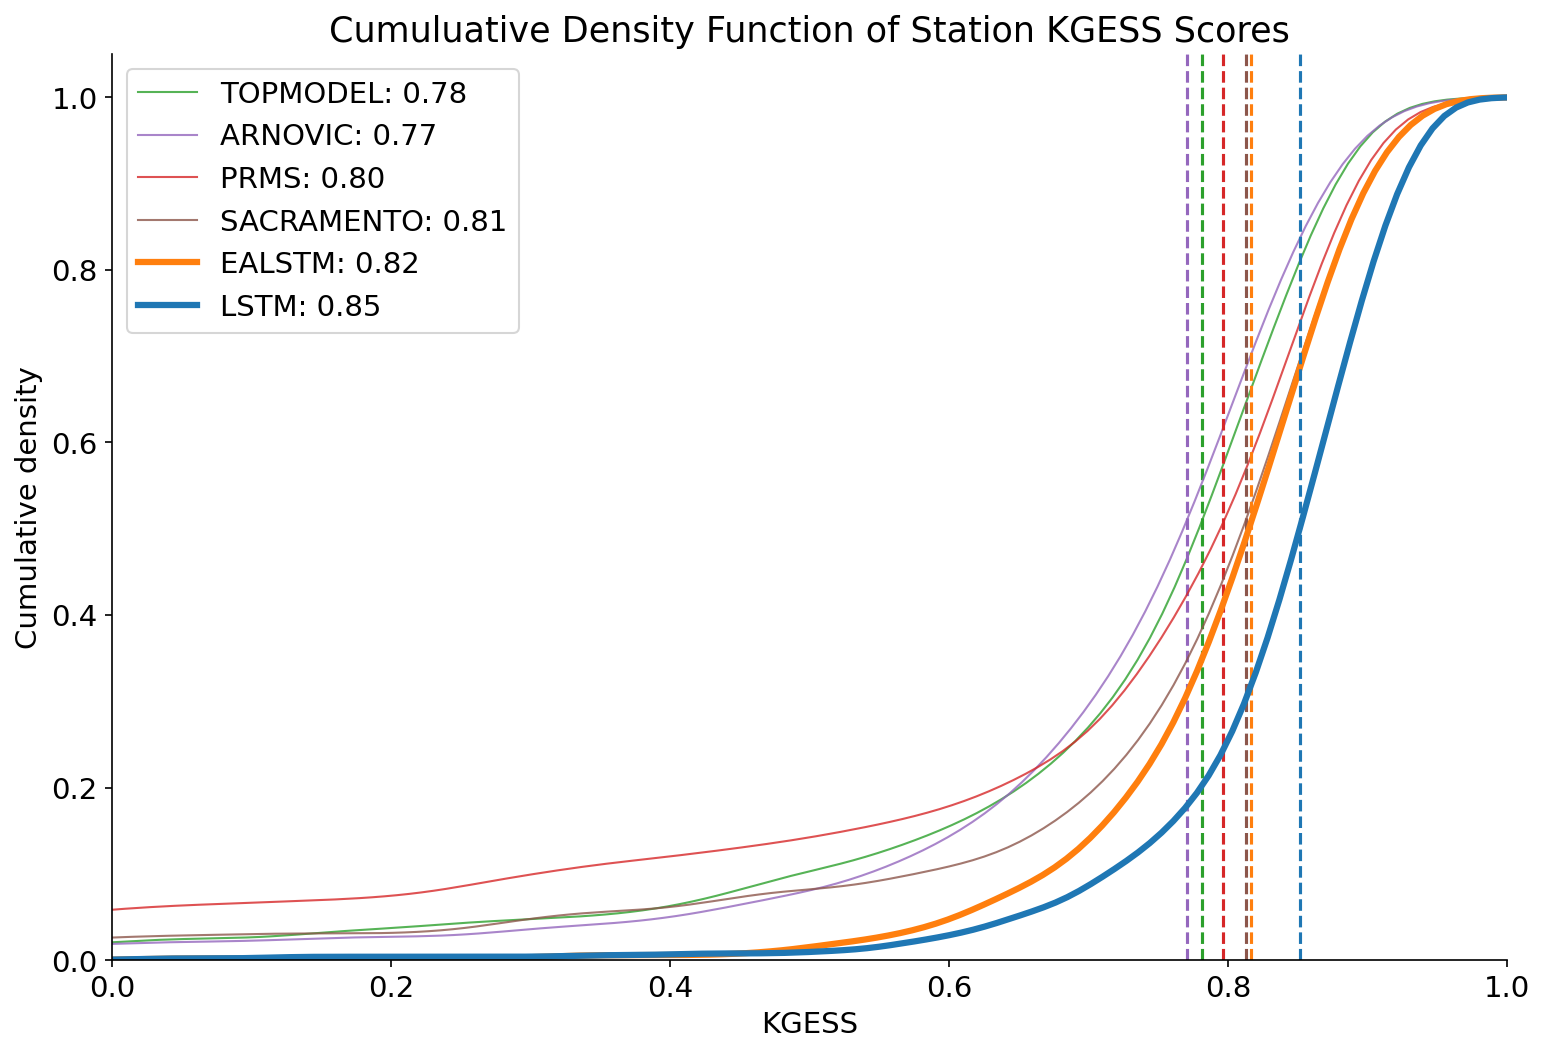

In [154]:
f, ax = plt.subplots(figsize=(12, 8))
plot_cdf(kge_ss, metric="KGESS", clip=(0, 1), ax=ax)

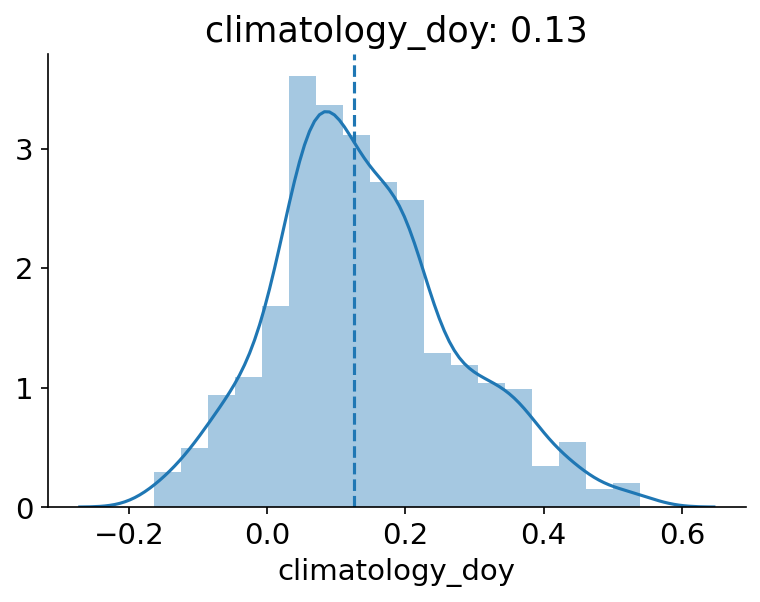

In [155]:
bmark = all_metrics["kge"].loc[:, "climatology_doy"]
sns.distplot(bmark)
ax = plt.gca()
ax.axvline(bmark.median(), ls="--")
ax.set_title(f"{bmark.name}: {bmark.median():.2f}")
sns.despine()

# DEmonstration Plot

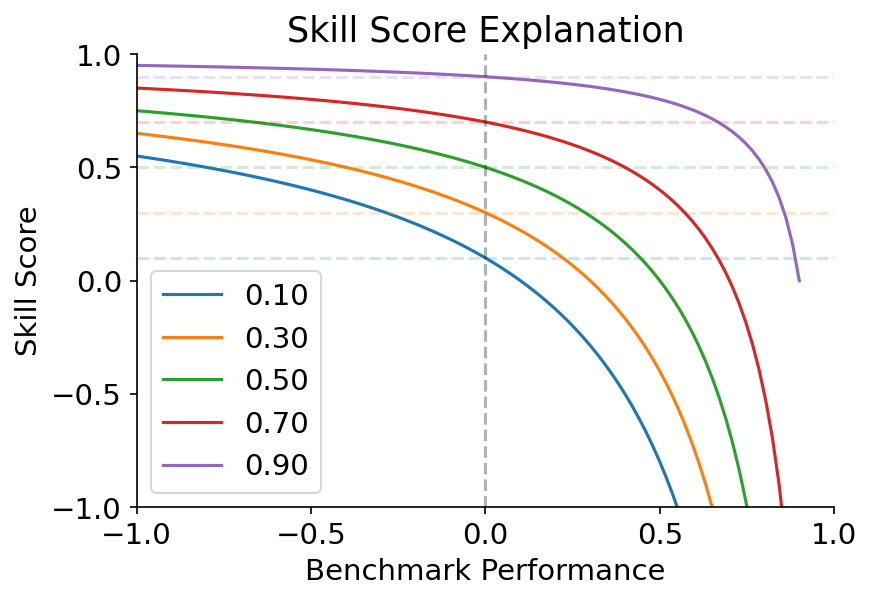

In [156]:
model = 0.5
bench = np.linspace(-1, 0.9, 100)
perf = 1 
y = lambda model, bench, perf: (model - bench) / (perf - bench)

f, ax = plt.subplots()

for ix, model in enumerate(np.linspace(0.1, 0.9, 5)):
    ax.plot(bench, y(model, bench, perf), label=f"{model:.2f}")
    ax.axhline(model, ls="--", alpha=0.2, c=f"C{ix}")
ax.axvline(0, ls="--", alpha=0.3, c="k")
ax.legend()
ax.set_xlabel("Benchmark Performance")
ax.set_ylabel("Skill Score")
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)
ax.set_title("Skill Score Explanation")
sns.despine()

# Explore Delta NSEs

In [157]:
lstm_delta_nse = lstm_delta["nse"]

In [158]:
# ?sns.boxplot

In [159]:
def boxplot_deltas(deltas: pd.DataFrame, metric: str, ylim=[-1 ,1], ref_model: str = "LSTM"):
    sns.boxplot(data=deltas[metric], palette=sns.color_palette()[2:], order=["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"])
    ax = plt.gca()
    ax.set_ylim(ylim)
    ax.axhline(0, ls=":", color="k", label="No Improvement")
    ax.set_ylabel(f"$\Delta${metric}")
    ax.legend()
    ax.set_title(f"$\Delta${metric} for each Model vs. {ref_model}")
    sns.despine()

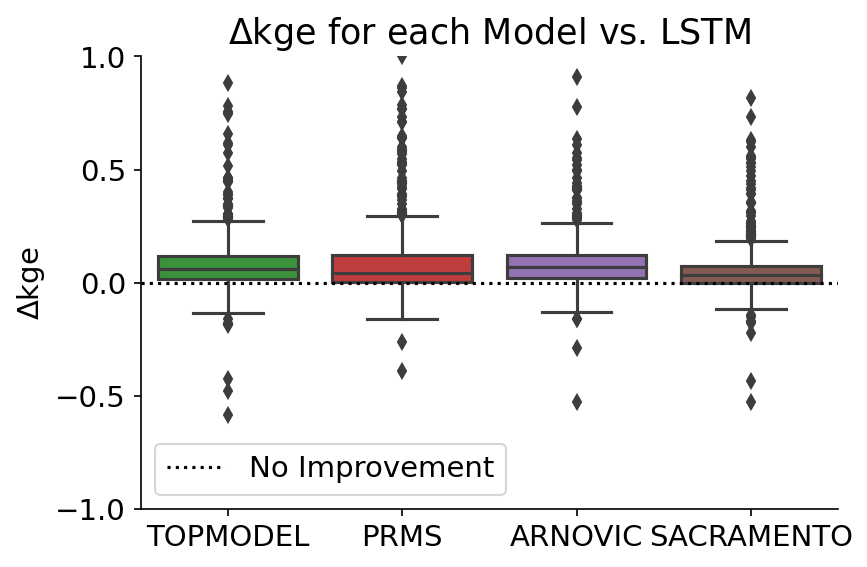

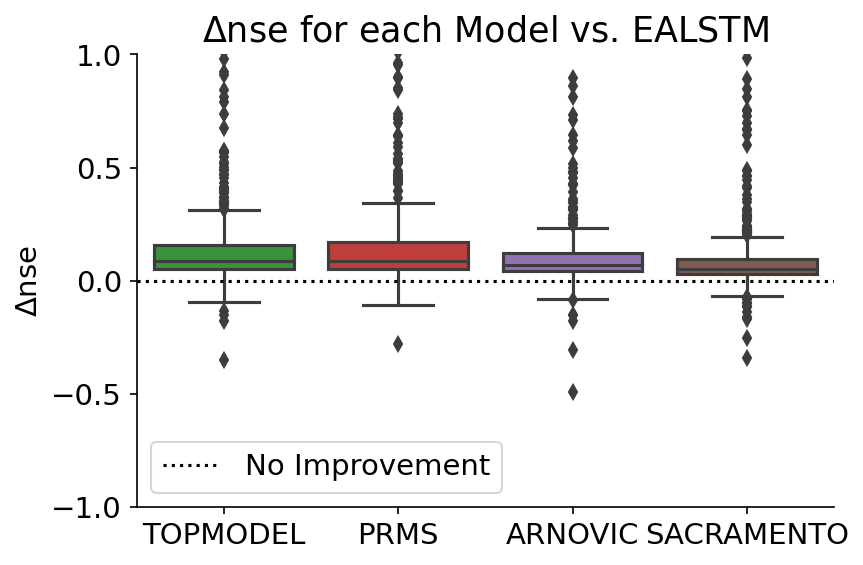

In [463]:
f, ax = plt.subplots()
boxplot_deltas(lstm_delta, metric="kge")
f, ax = plt.subplots()
boxplot_deltas(ealstm_delta, metric="nse", ref_model="EALSTM")

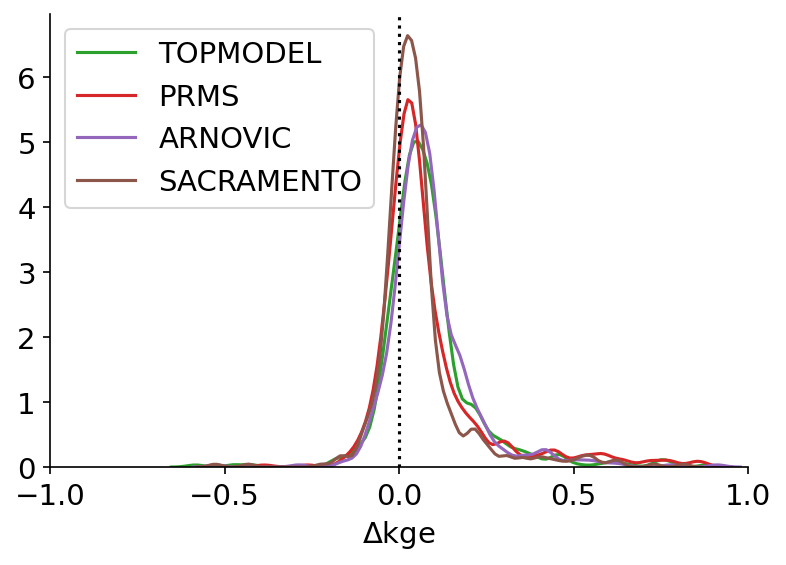

In [466]:
from typing import Tuple

color_lookup = {
    m: sns.color_palette()[2:][ix] for (ix, m) in enumerate(["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"])
}

def kde_plot_deltas(delta_df: pd.DataFrame, metric: str = "nse", xlim: Tuple[float] = (-1, 1), ax=None):
        kde_kws = {"clip": (-1, 1)}
        hist_kws = {"range": (-1, 1), "density": True}
        if ax is None:
            f, ax = plt.subplots()
        [
            sns.distplot(delta_df[c], ax=ax, kde_kws=kde_kws, hist_kws=hist_kws, hist=False, label=c, color=color_lookup[c])
            for c in ["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"]
        ]
        ax.set_xlim((-1, 1))
        ax.axvline(0, ls=":", color="k")
        ax.set_xlabel(f"$\Delta${metric}")
        ax.legend()
        sns.despine()


metric = "kge"
kde_plot_deltas(lstm_delta[metric], metric=metric, xlim=(-1, 1))

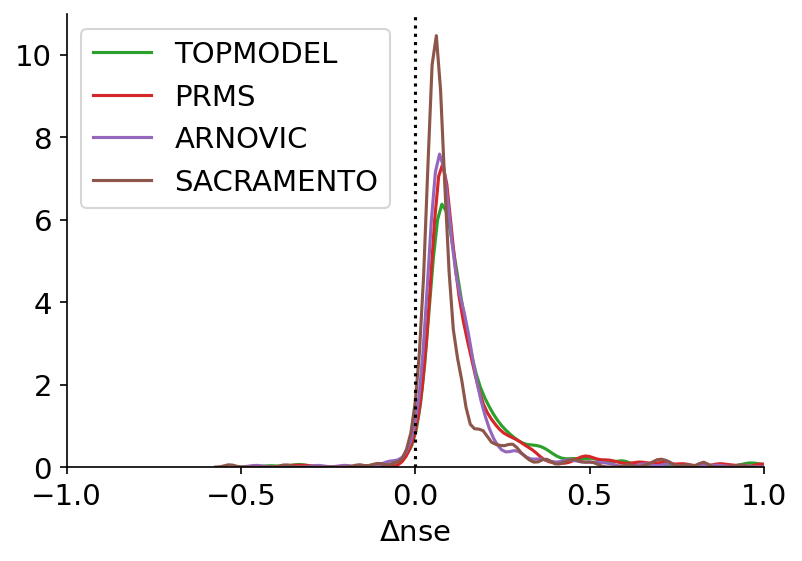

In [467]:
metric = "nse"
kde_plot_deltas(lstm_delta[metric], metric=metric, xlim=(-1, 1))

# Explore Deltas by Water Balance

In [468]:
from scripts.drafts.water_closure_levels import create_closure_masks, get_condition_sids

In [469]:
thresholds, (mean_closure, mean_precip) = create_closure_masks(ds, method="sum", closure_thresholds=[0.05, 0.1, 0.15, 0.2, 0.25, 1.0])
thresholds = thresholds.sel(station_id=all_preds.station_id)

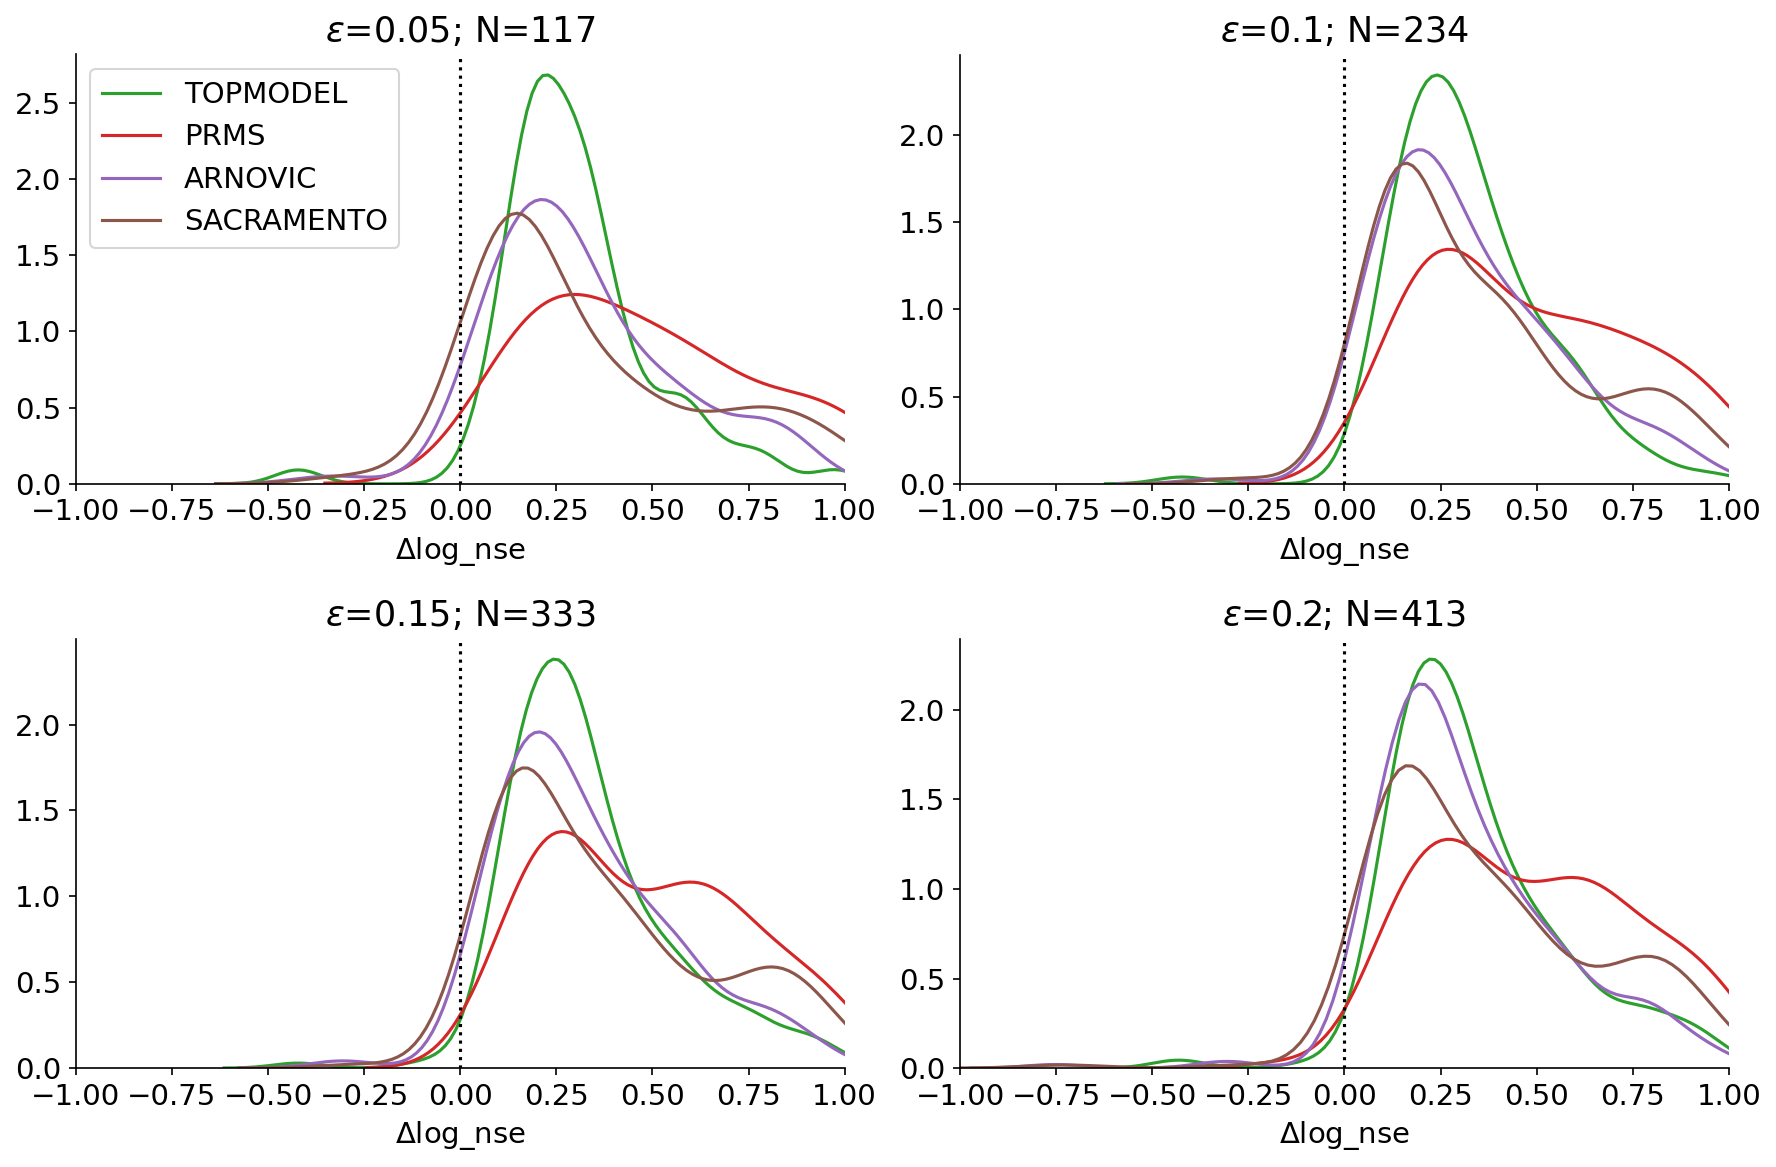

In [470]:
f, axs = plt.subplots(2, 2, figsize=(6*2, 4*2))

ix = 0
for ix, thresh in enumerate(thresholds.threshold.values[:4]):
    condition_sids = get_condition_sids(thresholds, thresh)

    ax = axs[np.unravel_index(ix, (2,2))]
    kde_plot_deltas(lstm_delta["log_nse"].loc[np.isin(lstm_delta["log_nse"].index, condition_sids)], metric="log_nse", xlim=(-1, 1), ax=ax)
    if ix != 0:
        ax.get_legend().remove()
    ax.set_title(f"$\epsilon$={thresh}; N={len(condition_sids)}")
    
plt.tight_layout()

In [471]:
(lstm_delta["kge"] < 0).mean()

TOPMODEL      0.191120
ARNOVIC       0.164093
PRMS          0.229730
SACRAMENTO    0.270270
EALSTM        0.196911
dtype: float64

# Groundwater

In [166]:
from typing import Dict


def plot_static_feature_ordered_scatter(
    delta_data: Dict[str, pd.DataFrame],
    metric: str = "nse", 
    ylim: Tuple[float] = (-0.5, 1.6), 
    feature: str = "aridity",
    kwargs: Dict = {},
):
    data = delta_data[metric].join(static[feature].to_dataframe())

    f, axs = plt.subplots(2, 2)

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax_ix = np.unravel_index(ix, (2, 2))
        ax = axs[ax_ix]
        sorted_index = data[model].sort_values().index
        s = ax.scatter(
            np.arange(len(data[model])), 
            data[model].sort_values().loc[sorted_index], 
            c=data[feature].loc[sorted_index],
            **kwargs
        )
        ax.axhline(ls=":", color="k", alpha=0.5, label="No Improvement")
        ax.set_title(f"{model} Delta {metric.upper()}")
        ax.set_ylim(ylim)
        ax.set_xticklabels([])
        ax.set_xticks([])

        sns.despine()
        if ax_ix[1] == 0:
            ax.set_ylabel("$\Delta$NSE")
        else:
            ax.set_yticklabels([])
            ax.set_yticks([])
        if ax_ix[0] == 1:
            ax.set_xlabel("Basin")

    
    # colorbar
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(s, cax=cbar_ax)
    cbar.set_label(feature.capitalize())

    
def plot_static_feature_scatter(
    delta_data: Dict[str, pd.DataFrame],
    metric: str = "nse", 
    ylim: Tuple[float] = (0, 1), 
    xlim: Tuple[float] = (-0.5, 1.6), 
    feature: str = "aridity",
    kwargs: Dict = {},
):
    data = delta_data[metric].join(static[feature].to_dataframe())

    f, axs = plt.subplots(2, 2)

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax_ix = np.unravel_index(ix, (2, 2))
        ax = axs[ax_ix]
        sorted_index = data[model].index
        s = ax.scatter(
            data[model].loc[sorted_index], 
            data[feature].loc[sorted_index],
            c=data[feature].loc[sorted_index],
            **kwargs
        )
        ax.axvline(0, ls=":", color="k", alpha=0.5, label="No Improvement")
        ax.set_title(f"{model} Delta {metric.upper()}")
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        sns.despine()
        if ax_ix[1] == 0:
            ax.set_ylabel(f"{feature}")
        else:
            ax.set_yticklabels([])
            ax.set_yticks([])
        if ax_ix[0] == 1:
            ax.set_xlabel("$\Delta$NSE")

    # colorbar
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(s, cax=cbar_ax)
    cbar.set_label(feature.capitalize())
    

In [167]:
# plot_static_feature_ordered_scatter(lstm_delta, metric="nse", feature="baseflow_index", kwargs={"s": None, "marker":"o", "s": 7})

In [168]:
# plot_static_feature_scatter(lstm_delta, metric="nse", feature="baseflow_index", kwargs={"vmin":None, "vmax":None, "s": 7})
# plot_static_feature_scatter(lstm_delta, metric="nse", feature="area")

### Discretize the DeltaNSE

In [169]:
# get the continuous static features with few nans
float_static = static.to_dataframe().loc[:, static.to_dataframe().dtypes == "float64"]
float_static = float_static.loc[:, ~(float_static.isnull().mean() > 0.25)]



def create_bins(data: pd.Series, n_bins: int=4) -> pd.DataFrame:
    # get the groups where greater than zero
    zero_indexes = data.loc[data < 0].index
    out_series = pd.concat([
        pd.qcut(data.loc[data > 0], q=n_bins),
        pd.Series([pd.Interval(-np.inf, 0) for _ in range((data < 0).sum())], index=zero_indexes).astype("category"),
    ])
    out_series.name = "group"
    
    # ordered categories
    out_series = out_series.astype("category")
    out_series = out_series.cat.as_ordered()
    # create 2 columns of categories and code
    df = pd.DataFrame({"category": out_series, "code": out_series.cat.codes})

    return df



def create_model_delta_bins_with_static(
    delta_data = lstm_delta,
    metric = "nse",
    model = "TOPMODEL",
    static_variable = "baseflow_index"
):
    model_delta = delta_data[metric][model]
    binned = create_bins(model_delta)
    
    # join to static data
    data = binned.join(float_static[static_variable])

    return data


def boxplot_discretized_delta_nse(data: pd.DataFrame, static_variable: str, model: str, ax, swarm: bool = True, swarm_kwargs: Dict = {"size": 2}):
    assert all(np.isin(["category", static_variable], data.columns)), "calculate discretized bins with `create_model_delta_bins_with_static` function"
    
    sns.boxplot(x="category", y=static_variable, data=data, ax=ax)
    if swarm:
        sns.swarmplot(x="category", y=static_variable, data=data, color=".25", ax=ax, **swarm_kwargs)

    # prettier labels
    labels = []
    for category in data["category"].cat.categories:
        labels.append(f"{category.left:.2f} > x < {category.right:.2f}")

    ax.set_xticklabels(labels, rotation = 45, ha="right")
    ax.set_xlabel("$\Delta$NSE Bin")
    ax.set_ylabel(static_variable)
    ax.set_title(f"{model} Discretized $\Delta$NSE")
    sns.despine()
    

delta_data = lstm_delta
metric = "nse"
model = "TOPMODEL"
static_variable = "baseflow_index"

# f, ax = plt.subplots()
# data = create_model_delta_bins_with_static(lstm_delta, metric, model, static_variable)
# boxplot_discretized_delta_nse(data, static_variable, model, ax=ax)

In [472]:
metric = "kge"

# join all into one big plot
d = lstm_delta[metric].drop("EALSTM", axis=1).melt()
index = np.tile(lstm_delta[metric].index, 4)
d.index = index

binned = create_bins(d.value, n_bins=6).join(float_static["baseflow_index"])

# f, ax = plt.subplots()
# boxplot_discretized_delta_nse(binned, "variable", "All Models", ax=ax, swarm=False)
# binned

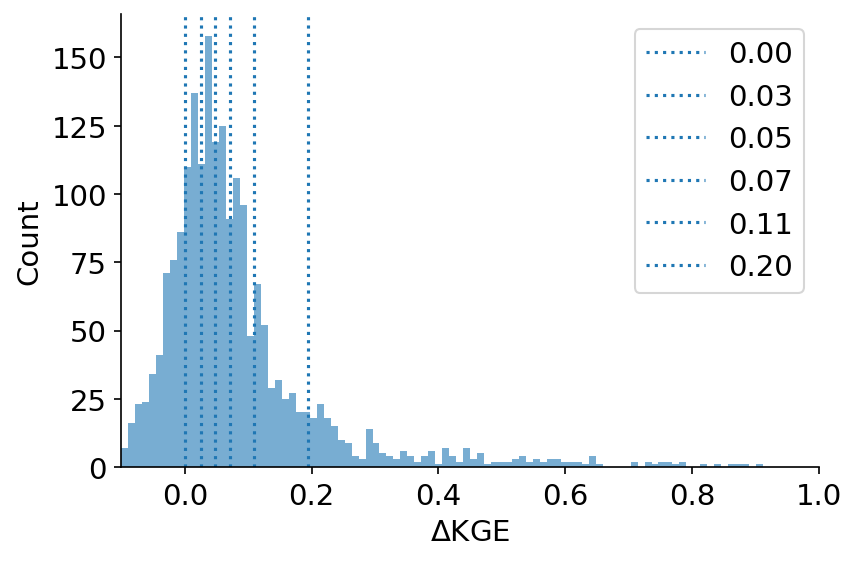

In [476]:
metric = "kge"

# histogram of all data from 
out = lstm_delta[metric].drop("EALSTM", axis=1).melt()
index = np.tile(lstm_delta[metric].index, 4)
out.index = index


# PLOT HIST
plt.hist(out["value"], bins=100, range=(-0.1, 1), alpha=0.6);
cutoffs = np.array(binned["category"].cat.categories.right)[:-1]
ax = plt.gca()
for c in cutoffs:
    ax.axvline(c, ls=":", label=f"{c:.2f}")
ax.legend()
ax.set_xlim(-0.1, 1)

ax.set_xlabel(f"$\Delta${metric.upper()}")
ax.set_ylabel("Count")

sns.despine()

In [477]:
create_bins(float_static["baseflow_index"], n_bins=6)

category  code
station_id                     
1001         (0.44, 0.51]     1
2001         (0.51, 0.56]     2
2002         (0.44, 0.51]     1
3003        (0.239, 0.44]     0
4001         (0.61, 0.71]     4
...                   ...   ...
101002       (0.61, 0.71]     4
101005       (0.61, 0.71]     4
102001       (0.44, 0.51]     1
106001       (0.51, 0.56]     2
107001       (0.51, 0.56]     2

[671 rows x 2 columns]

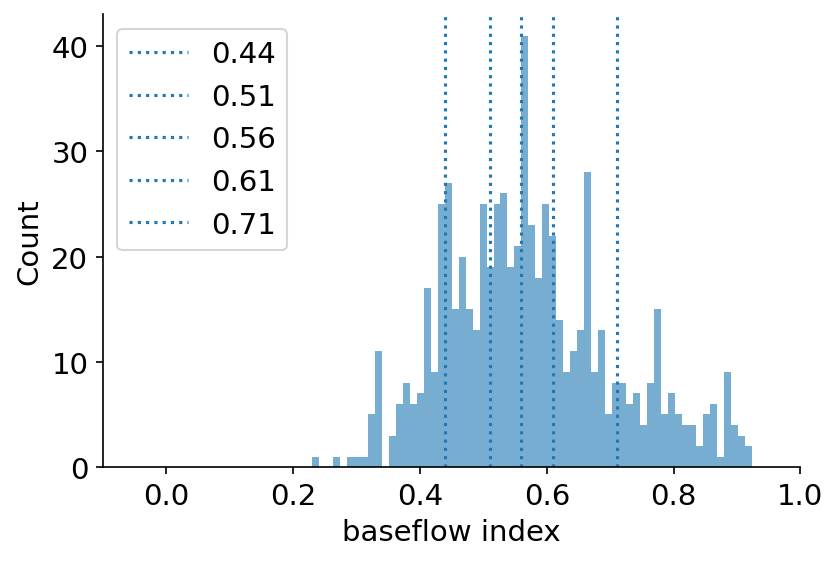

In [478]:
binned = create_bins(float_static["baseflow_index"], n_bins=6).join(float_static["baseflow_index"])

# PLOT HIST
plt.hist(binned["baseflow_index"], bins=100, range=(-0.1, 1), alpha=0.6);
cutoffs = np.array(binned["category"].cat.categories.right)[:-1]
ax = plt.gca()
for c in cutoffs:
    ax.axvline(c, ls=":", label=f"{c:.2f}")
ax.legend()
ax.set_xlim(-0.1, 1)

ax.set_xlabel("baseflow index")
ax.set_ylabel("Count")

sns.despine()

In [174]:
# # TO PLOT EACH MODEL SEPARATELY

# delta_data = lstm_delta
# metric = "nse"
# # model = "TOPMODEL"
# static_variable = "baseflow_index"

# f, axs = plt.subplots(2, 2, figsize=(6*1.5, 4*1.5))
# for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
#     ax_ix = np.unravel_index(ix, (2, 2))
#     ax = axs[ax_ix]

#     data = create_model_delta_bins_with_static(lstm_delta, metric, model, static_variable)
#     boxplot_discretized_delta_nse(data, static_variable, model, ax=ax, swarm_kwargs={"size": 2})
    
#     fig.tight_layout()

In [175]:
# lstm_errors

### SCATTER Plot

In [176]:
from typing import Callable

# SPLINE FUNCTIONS
from typing import Union
def sort_values_by_x(x: Union[np.ndarray, pd.Series], y: Union[np.ndarray, pd.Series]) -> Union[np.ndarray, pd.Series]:
    sort = np.argsort(x)
    try:
        x = x.iloc[sort]
        y = y.iloc[sort]
    except AttributeError:
        x = x[sort]
        y = y[sort]
    return x, y


def strict_increasing(x: pd.Series, y: pd.Series) -> Tuple[pd.Series]:
    # TODO: convert to using np.argsort to maintain x,y pairing
    x, y = sort_values_by_x(x, y)

    strictly_increasing_x = [True]
    strictly_increasing_x.extend(np.diff(x) > 0)
    x_inc = x[strictly_increasing_x]
    y_inc = y[strictly_increasing_x]
    
    return x_inc, y_inc


def return_finite_only(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray]:
    x = x[np.isfinite(x) & np.isfinite(y)]
    y = y[np.isfinite(x) & np.isfinite(y)]
    return x, y


def cubic_spline(x: pd.Series, y: pd.Series) -> Callable:
    from scipy.interpolate import CubicSpline
    # https://stackoverflow.com/a/43613728/9940782
    # dropnans
    x, y = return_finite_only(x, y)
    
    # strictly increasing
    x, y = strict_increasing(x, y)
    
    # fit cubic spline
    cs = CubicSpline(x, y, bc_type="natural")
    return cs


def gaussian_kernel_smoother(x: pd.Series, y: pd.Series, sigma: float = 2, dropnan: bool = False) -> Tuple[np.ndarray]:
    from scipy import ndimage
    if dropnan:
        x, y = return_finite_only(x, y)

    # https://stackoverflow.com/a/32905652/9940782
    x_g1d = ndimage.gaussian_filter1d(x, sigma, mode="reflect")
    y_g1d = ndimage.gaussian_filter1d(y, sigma, mode="reflect")
    
    return x_g1d, y_g1d


def univariate_spline(x: pd.Series, y: pd.Series, **kwargs) -> Callable:
    """
    kwargs:
        k: Degree of the smoothing spline
        s: smoothing parameter (often requires fitting)
    """
    from scipy import interpolate
    x, y = return_finite_only(x, y)

    # strictly increasing
    x, y = strict_increasing(x, y)

    spl = interpolate.UnivariateSpline(x, y, **kwargs)
    
    return spl


def smooth_lowess(x, y, kwargs: Dict = {}) -> Tuple[pd.Series]:
    from statsmodels.nonparametric.smoothers_lowess import lowess

    # wrapper for statsmodels lowess
    try:
        smooth_y = lowess(y, x, return_sorted=False, **kwargs)
    except AttributeError:
        x, y = x.values.flatten(), y.values.flatten()
        smooth_y = lowess(y, x, return_sorted=False, **kwargs)
    
    df = x.rename("x").to_frame()
    df["y"] = smooth_y
    df = df.dropna().sort_values("x")
    return df["x"], df["y"]

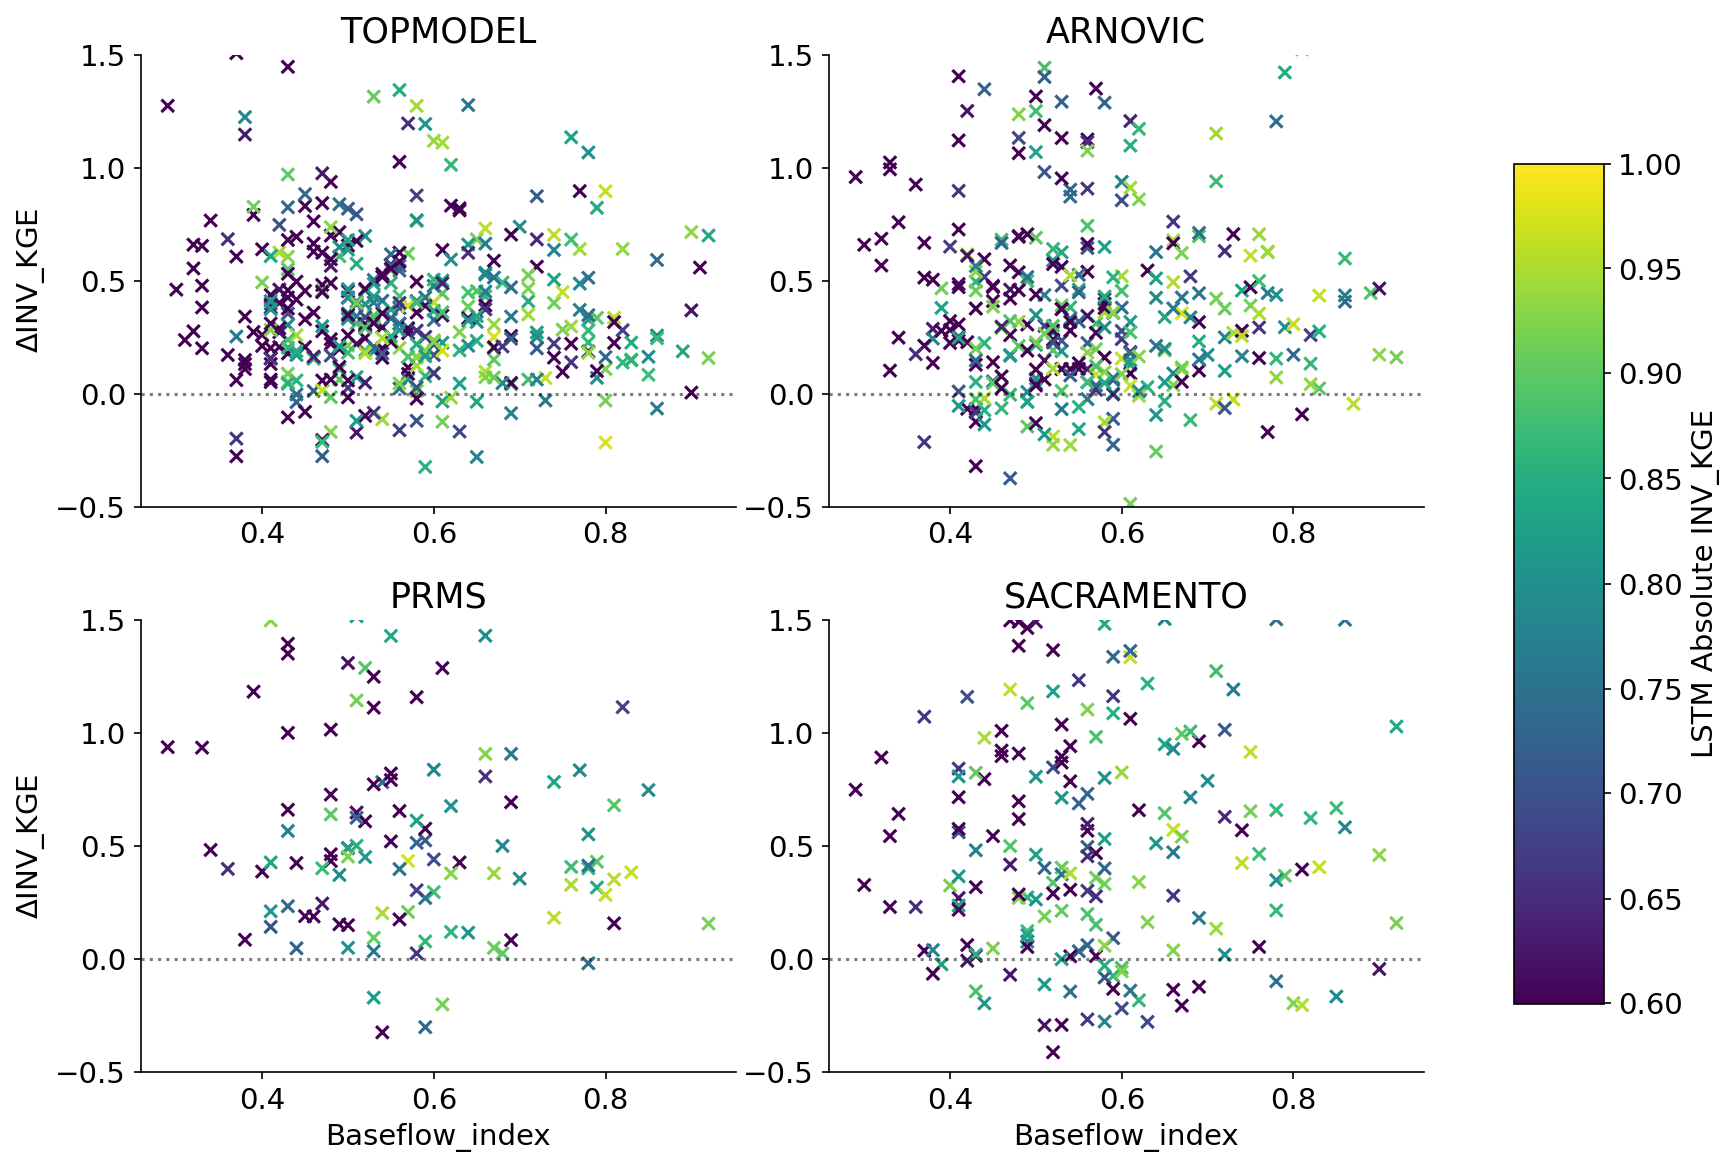

In [498]:
from typing import Optional


def plot_scatter_delta_nse_static(
    delta_data: pd.DataFrame, 
    metric: str = "nse", 
    feature: str = "baseflow_index", 
    ylim: Tuple[Optional[float]] = (None, None),
    absolute_data: pd.DataFrame = None,
    spline: bool = True,
    spline_kwargs: Dict = {"s": 9, "k": 3},
    kwargs: Dict = {}
):
    models = ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]
    assert all(np.isin(models, delta_data[metric].columns))
    # get X and y variables
    data = delta_data[metric].join(static[feature].to_dataframe())
    x = data[feature].astype("float64")
    
    # get the color variable (z)
    if absolute_data is not None:
        # set the color to be the absolute NSE for that basin (LSTM/EALSTM)
        absolute_data = absolute_data.loc[data.index, metric].astype("float64")
        
    f, axs = plt.subplots(2, 2, figsize=(6*2, 4*2))

    for ix, model in enumerate(models):
        y = data[model].astype("float64")

        ax = axs[np.unravel_index(ix, (2, 2))]
        s = ax.scatter(
            x, y,
            c=data[feature] if absolute_data is None else absolute_data,
            **kwargs
        )
        ax.axhline(ls=":", color="k", alpha=0.5, label="No Improvement")
        ax.set_title(f"{model}")
        ax.set_ylim(ylim)

        if np.unravel_index(ix, (2, 2))[1] == 0:
            ax.set_ylabel(f"$\Delta${metric.upper()}")
        if np.unravel_index(ix, (2, 2))[0] == 1:
            ax.set_xlabel(f"{feature.capitalize()}")
            
        if spline:
            sm_x, sm_y = smooth_lowess(x, y)
            ax.plot(sm_x, sm_y, c="k", ls="--")
        sns.despine()

    # colorbar
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(s, cax=cbar_ax)
    cbar.set_label(feature.capitalize() if absolute_data is None else f"LSTM Absolute {metric.upper()}")
    
    return f, axs, data
    


lstm_metric_df = all_errors["LSTM"]
metric = "inv_kge"
kwargs = {"vmin": 0.6, "vmax": 1, "marker": "x"}
feature = "baseflow_index"

f, axs, data = plot_scatter_delta_nse_static(
    lstm_delta, metric, feature, 
    absolute_data=lstm_metric_df,   # None
    kwargs=kwargs, 
    spline=False,
    spline_kwargs=dict(k=2, s=100),
    ylim=(-0.5, 1.5),
)

In [499]:
ealstm_metric_df = all_errors["EALSTM"]

d = static["baseflow_index"].to_dataframe().join(lstm_metric_df["nse"].rename("LSTM")).join(ealstm_metric_df["nse"].rename("EALSTM"))
d.head()

baseflow_index      LSTM    EALSTM
station_id                                    
1001                  0.49  0.875410  0.871396
2001                  0.56  0.795517  0.781072
2002                  0.45  0.796522  0.781357
3003                  0.40  0.879771  0.843745
4001                  0.69  0.873894  0.854027

### Fit splines ...

In [500]:
if False:
    # http://www.science.smith.edu/~jcrouser/SDS293/labs/lab13-py.html
    # https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/
    # https://stackoverflow.com/questions/51321100/python-natural-smoothing-splines

    from patsy import dmatrix, build_design_matrices
    import statsmodels.api as sm

    bfi = d.dropna()["baseflow_index"]
    X = dmatrix("bs(x, include_intercept=True, knots=[ 0.3, 0.4, 0.6, 0.8, 0.9])", data=dict(x=bfi))

    w = np.ones(6)
    w = w / w.sum(axis=0, keepdims=1)

    y = d.dropna()["LSTM"].values.reshape(-1, 1)
    fit = sm.GLM(y, X).fit()
    params = fit.params

    # dmatrix(X.design_info, data=dict(lstm=np.linspace(0.21, 0.89, 10)))
    # X

In [501]:
if False:
    """Basis spline testing code"""
    import matplotlib.pyplot as plt
    plt.title("B-spline basis example (degree=3)");
    x = np.linspace(0., 1., 100)
    y = dmatrix("bs(x, df=6, degree=3, include_intercept=True)", {"x": x})
    b = np.array([1, 1.3, 0.6, 0.9, 0.4, 1.6, 0.7])

    # b = params
    # x = lstm
    # y = X

    plt.plot(x, y*b);
    plt.plot(x, np.dot(y, b), color='k', linewidth=3);

In [191]:
nse_df = all_metrics["nse"]

d = static["baseflow_index"].to_dataframe().join(lstm_metric_df["nse"].rename("LSTM")).join(ealstm_metric_df["nse"].rename("EALSTM"))

d = nse_df.join(static["baseflow_index"].to_dataframe())
d = d.dropna()
d.head()

TOPMODEL   ARNOVIC      PRMS  SACRAMENTO    EALSTM      LSTM  \
station_id                                                                 
1001        0.360339  0.675836  0.474057    0.617577  0.934588  0.958316   
2001        0.866314  0.860317  0.816383    0.873808  0.924685  0.927525   
2002        0.508923  0.919535  0.801396    0.922242  0.942369  0.961437   
3003        0.536147  0.907952  0.837635    0.893386  0.924441  0.900817   
4001        0.857425  0.830071  0.821672    0.862439  0.903386  0.910409   

            persistence  climatology_doy  climatology_mon  baseflow_index  
station_id                                                                 
1001           0.986202         0.360178         0.353223            0.49  
2001           0.547425         0.160650         0.146828            0.56  
2002           0.985267         0.453534         0.442505            0.45  
3003           0.978724         0.406303         0.399523            0.40  
4001           0.542941         0.170832         0.148040            0.69

Text(0.5, 0, 'Aridity')

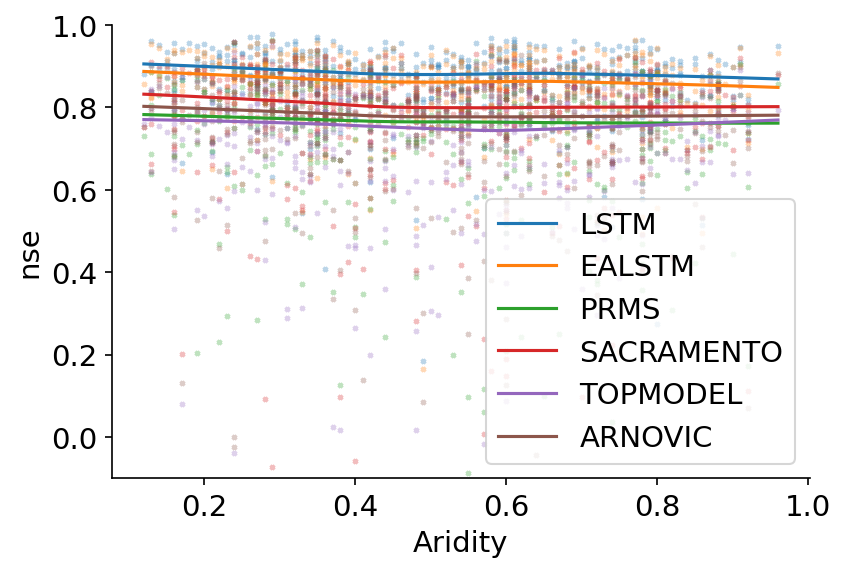

In [509]:
def plot_smooth_line(df: pd.DataFrame, feature: str, model: str, ax):
    px, py = smooth_lowess(df[feature], df[model])
    ax.plot(px, py, label=model, ls="-")
    return ax



def plot_scatter_lowess_feature(feature: str, metric: str):
    d = all_metrics[metric].join(static[feature].to_dataframe()).dropna()
    
    alpha_scatter = 0.3
    s = 4

    f, ax = plt.subplots()
    ax.scatter(d[feature], d["LSTM"], color=sns.color_palette()[0], marker="x", alpha=alpha_scatter, s=s)
    ax = plot_smooth_line(df=d, feature=feature, model="LSTM", ax=ax)

    ax.scatter(d[feature], d["EALSTM"], color=sns.color_palette()[1], marker="x", alpha=alpha_scatter, s=s)
    ax = plot_smooth_line(df=d, feature=feature, model="EALSTM", ax=ax)

    if "PRMS" in d.columns:
        ax.scatter(d[feature], d["PRMS"], color=sns.color_palette()[2], marker="x", alpha=alpha_scatter, s=s)
        ax = plot_smooth_line(df=d, feature=feature, model="PRMS", ax=ax)

        ax.scatter(d[feature], d["SACRAMENTO"], color=sns.color_palette()[3], marker="x", alpha=alpha_scatter, s=s)
        ax = plot_smooth_line(df=d, feature=feature, model="SACRAMENTO", ax=ax)

        ax.scatter(d[feature], d["TOPMODEL"], color=sns.color_palette()[4], marker="x", alpha=alpha_scatter, s=s)
        ax = plot_smooth_line(df=d, feature=feature, model="TOPMODEL", ax=ax)

        ax.scatter(d[feature], d["ARNOVIC"], color=sns.color_palette()[5], marker="x", alpha=alpha_scatter, s=s)
        ax = plot_smooth_line(df=d, feature=feature, model="ARNOVIC", ax=ax)

    ax.set_xlabel(feature)
    ax.set_ylabel(metric)
    ax.legend()
    sns.despine()
    return ax

    
ax = plot_scatter_lowess_feature("aridity", metric="nse")
ax.set_ylim(-0.1, 1)
# ax.set_ylim(-0.1, 50)
ax.set_xlabel("Aridity")

(0.0, 1.0)

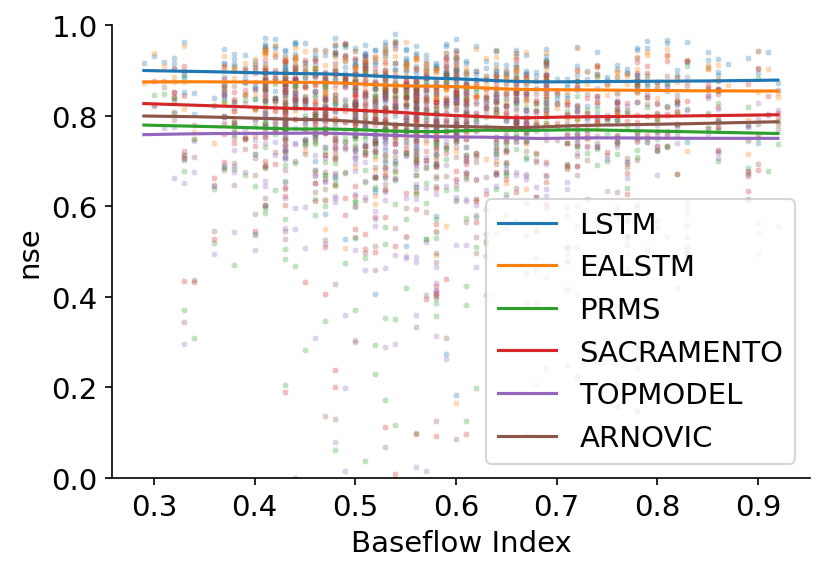

In [201]:
ax = plot_scatter_lowess_feature("baseflow_index", metric="nse")
ax.set_xlabel("Baseflow Index")
ax.set_ylim(0, 1)

# Calculate Runoff Coefficient

In [194]:
def assign_wateryear(dt):
    """https://stackoverflow.com/a/52615358/9940782"""
    dt = pd.Timestamp(dt)
    if dt.month >= 10:
        return(pd.datetime(dt.year+1,1,1).year)
    else:
        return(pd.datetime(dt.year,1,1).year)

ds_wy = ds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in ds.time.values]))
lstm_preds_wy = lstm_preds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in lstm_preds.time.values]))

In [195]:
wy_sum = ds_wy.groupby("wy").sum(dim="time")
runoff_coeff_obs = (wy_sum["discharge_spec"] / wy_sum["precipitation"]).mean("wy")
obs_rc = runoff_coeff_obs.to_dataframe("runoff_coeff")
obs_rc.head()

runoff_coeff
station_id              
1001            0.263388
2001            0.608132
2002            0.355424
3003            0.656335
4001            0.840136

In [202]:
lstm_wy_sum = lstm_preds_wy.groupby("wy").sum(dim="time")
runoff_coeff_sim = (lstm_wy_sum["sim"] / wy_sum["precipitation"].sel(wy=lstm_wy_sum["wy"])).mean("wy")
sim_rc = runoff_coeff_sim.to_dataframe("runoff_coeff")
sim_rc.head()

runoff_coeff
station_id              
1001            0.545960
2001            0.568096
2002            0.625478
3003            0.721610
4001            0.855345

In [203]:
rc_comparison = obs_rc.rename({"runoff_coeff": "obs",}, axis=1).join(sim_rc.rename({"runoff_coeff": "sim",}, axis=1))

(0.0, 1.0)

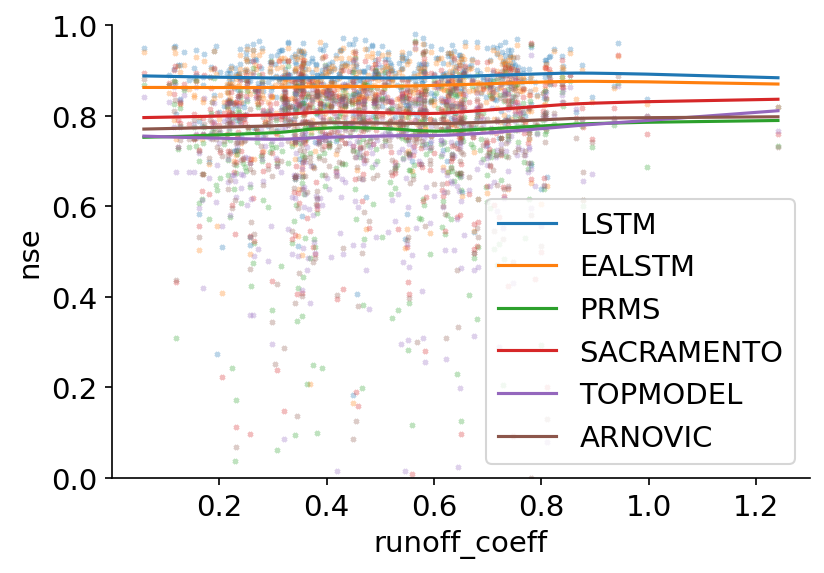

In [209]:
static = static.merge(obs_rc.to_xarray())
ax = plot_scatter_lowess_feature("runoff_coeff", metric="nse")
ax.set_ylim(0, 1)

(0.0, 1.0)

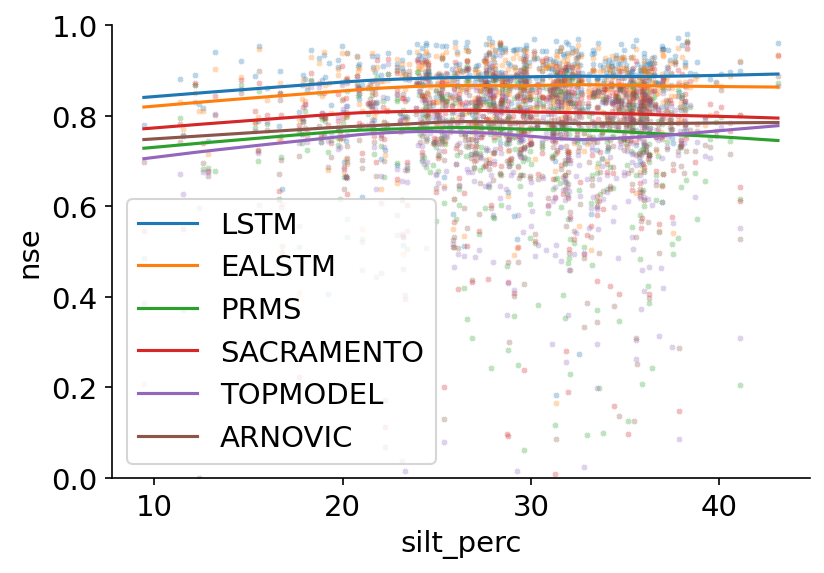

In [297]:
features_to_test = ["low_q_freq", "Q95", "baseflow_index_ceh", "aridity"]

feature = "silt_perc"
ax = plot_scatter_lowess_feature(feature, metric="nse")
ax.set_ylim(0, 1)
# f, axs, data = plot_scatter_delta_nse_static(
#     lstm_delta, "nse", feature, 
#     absolute_data=lstm_metric_df,
#     spline_kwargs=dict(k=3, s=100),
#     kwargs=kwargs, ylim=(-0.5, 1.5)
# )

## bin / discretize functions marginalia

In [211]:
# def bin_and_attach_static_features(delta_dict, metric: str = "nse"):
#     # create bin boundaries 
#     cutoff = np.linspace(0, 1, 6)
#     cutoff = np.insert(cutoff, 0, -np.inf)

#     # remove nans from the delta df
#     bin_data = delta_dict["nse"].dropna()

#     # split into groups
#     binned_data = pd.DataFrame(np.digitize(bin_data, cutoff, right=True))
#     binned_data.index = bin_data.index
#     binned_data.columns = bin_data.columns
#     binned_data = binned_data.join(float_static)
    
#     return binned_data, cutoff
    

# def discretize(data, bins):
#     split = np.array_split(np.sort(data), bins)
#     cutoffs = [x[-1] for x in split]
#     cutoffs = cutoffs[:-1]
# #     discrete = np.digitize(data, cutoffs, right=True)
#     return cutoffs

# # binned_data, cutoff = bin_and_attach_static_features(lstm_delta)
# # binned_data.head()

# Table of performances

In [212]:
ealstm_delta_nse = ealstm_delta["nse"]

In [213]:
display(lstm_delta_nse.mean())
display(ealstm_delta_nse.median())

TOPMODEL      0.157932
ARNOVIC       0.174872
PRMS          0.428587
SACRAMENTO    0.199857
EALSTM        0.019869
dtype: float64

TOPMODEL      0.085904
ARNOVIC       0.071856
PRMS          0.086638
SACRAMENTO    0.053325
LSTM         -0.016340
dtype: float64

### % Delta NSE > 0

In [214]:
lstm_delta_nse_ltx = lstm_delta_nse.dropna() #.drop("EALSTM", axis=1)
ealstm_delta_nse_ltx = ealstm_delta_nse.dropna() #.drop("LSTM", axis=1)

In [215]:
# "% Basins where $\Delta$NSE > 0"
latex_df = pd.concat(
    [
        ((lstm_delta_nse_ltx > 0).sum(axis=0) / lstm_delta_nse_ltx.count()).to_frame().rename({0: "LSTM"}, axis=1),
        ((ealstm_delta_nse_ltx > 0).sum(axis=0) / ealstm_delta_nse_ltx.count()).to_frame().rename({0: "EA LSTM"}, axis=1)
    ], axis=1
)
# latex_df.columns = [("% Basins where $\Delta$NSE > 0", "LSTM"), ("% Basins where $\Delta$NSE > 0", "EA LSTM")]
latex_df.mean()

LSTM       0.958687
EA LSTM    0.762548
dtype: float64

In [216]:
print(latex_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
{} &  LSTM &  EA LSTM \\
\midrule
TOPMODEL   &  0.98 &     0.95 \\
ARNOVIC    &  0.97 &     0.92 \\
PRMS       &  0.98 &     0.95 \\
SACRAMENTO &  0.97 &     0.89 \\
EALSTM     &  0.89 &      NaN \\
LSTM       &   NaN &     0.11 \\
\bottomrule
\end{tabular}



# Spatial Plots

In [217]:
import geopandas as gpd

assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
uk.head(2)

featurecla  scalerank  LABELRANK      SOVEREIGNT SOV_A3  ADM0_DIF  \
79  Admin-0 country          0          2  United Kingdom    GB1         1   

    LEVEL     TYPE           ADMIN ADM0_A3  ...  NAME_KO              NAME_NL  \
79      2  Country  United Kingdom     GBR  ...       영국  Verenigd Koninkrijk   

            NAME_PL      NAME_PT         NAME_RU         NAME_SV  \
79  Wielka Brytania  Reino Unido  Великобритания  Storbritannien   

             NAME_TR                                  NAME_VI NAME_ZH  \
79  Birleşik Krallık  Vương quốc Liên hiệp Anh và Bắc Ireland      英国   

                                             geometry  
79  MULTIPOLYGON (((-7.24710 55.06932, -7.25674 55...  

[1 rows x 95 columns]

In [226]:
matching_stations = list(set(fuse_data.station_id.values).intersection(set(lstm_preds.station_id.values)))
len(matching_stations)
# fuse_data

518

In [227]:
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

In [228]:
delta_df = lstm_delta_nse.reset_index()
# display(delta_df.head())

polygons = False

# create spatial dataframe
assert delta_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
delta_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(delta_df.set_index('station_id'))
).loc[matching_stations]


if not polygons:
    static_df = static.to_dataframe()
    d = static_df[["gauge_lat", "gauge_lon"]]

    points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
    points.name = "geometry"
    delta_gdf = delta_gdf.drop("geometry", axis=1).join(points)
    delta_gdf.crs = {'init' :'epsg:4326'}


delta_gdf = delta_gdf.to_crs(epsg=4326)

delta_gdf.head()

ID                       SOURCE VERSION    EXPORTED  TOPMODEL  \
ID_STRING                                                                       
43008      43008.0  National River Flow Archive     1.3  2018-02-12  0.766853   
43009      43009.0  National River Flow Archive     1.3  2018-02-12  0.201365   
43018      43018.0  National River Flow Archive     1.3  2018-02-12  0.388962   
43021      43021.0  National River Flow Archive     1.3  2018-02-12  0.286764   
84001      84001.0  National River Flow Archive     1.3  2018-02-12  0.254804   

            ARNOVIC      PRMS  SACRAMENTO    EALSTM                   geometry  
ID_STRING                                                                       
43008      0.565941  1.467017    0.706014 -0.021358  POINT (-1.88000 51.11000)  
43009     -0.003284  0.338268    0.721298  0.024923  POINT (-2.26000 50.93000)  
43018      0.216617  0.641337    0.274938  0.000969  POINT (-1.99000 50.81000)  
43021     -0.037879  0.645970    1.216353  0.035175  POINT (-1.78000 50.75000)  
84001      0.085670  0.145636    0.103543  0.030611  POINT (-4.31000 55.91000)

In [229]:
# poly["gauge_name"]

In [232]:
def create_spatial_dataframe(delta_df: pd.DataFrame, geo_df: gpd.GeoDataFrame, polygon: bool = False) -> gpd.GeoDataFrame:
    matching_stations = list(set(fuse_data.station_id.values).intersection(set(lstm_preds.station_id.values)))
    assert delta_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
    delta_gdf = gpd.GeoDataFrame(
        geo_df.set_index('ID_STRING').join(delta_df.set_index('station_id'))
    ).loc[matching_stations]
    if not polygons:
        static_df = static.to_dataframe()
        d = static_df[["gauge_lat", "gauge_lon"]]

        points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
        points.name = "geometry"
        delta_gdf = delta_gdf.drop("geometry", axis=1).join(points)
        delta_gdf.crs = {'init' :'epsg:4326'}


    delta_gdf = delta_gdf.to_crs(epsg=4326)
    
    return delta_gdf

In [233]:
lstm_delta_gdf = create_spatial_dataframe(delta_df=lstm_delta_nse.dropna().reset_index(), geo_df=geo_df)
ealstm_delta_gdf = create_spatial_dataframe(delta_df=ealstm_delta_nse.dropna().reset_index(), geo_df=geo_df)

# lstm_delta_gdf.to_file(data_dir / "RUNOFF/delta_shp_files/lstm.shp")
# ealstm_delta_gdf.to_file(data_dir / "RUNOFF/delta_shp_files/ealstm.shp")

# # write shapefile of locations
# gauge_names = static.to_dataframe()["gauge_name"]
# lstm_delta_gdf[["ID", "geometry"]].join(gauge_names).to_file(data_dir/"RUNOFF/point_shp.shp")

In [234]:
display(lstm_delta_gdf.head())
display(ealstm_delta_gdf.head())

ID                       SOURCE VERSION    EXPORTED  TOPMODEL  \
ID_STRING                                                                       
43008      43008.0  National River Flow Archive     1.3  2018-02-12  0.766853   
43009      43009.0  National River Flow Archive     1.3  2018-02-12  0.201365   
43018      43018.0  National River Flow Archive     1.3  2018-02-12  0.388962   
43021      43021.0  National River Flow Archive     1.3  2018-02-12  0.286764   
84001      84001.0  National River Flow Archive     1.3  2018-02-12  0.254804   

            ARNOVIC      PRMS  SACRAMENTO    EALSTM                   geometry  
ID_STRING                                                                       
43008      0.565941  1.467017    0.706014 -0.021358  POINT (-1.88000 51.11000)  
43009     -0.003284  0.338268    0.721298  0.024923  POINT (-2.26000 50.93000)  
43018      0.216617  0.641337    0.274938  0.000969  POINT (-1.99000 50.81000)  
43021     -0.037879  0.645970    1.216353  0.035175  POINT (-1.78000 50.75000)  
84001      0.085670  0.145636    0.103543  0.030611  POINT (-4.31000 55.91000)

ID                       SOURCE VERSION    EXPORTED  TOPMODEL  \
ID_STRING                                                                       
43008      43008.0  National River Flow Archive     1.3  2018-02-12  0.788211   
43009      43009.0  National River Flow Archive     1.3  2018-02-12  0.176442   
43018      43018.0  National River Flow Archive     1.3  2018-02-12  0.387993   
43021      43021.0  National River Flow Archive     1.3  2018-02-12  0.251590   
84001      84001.0  National River Flow Archive     1.3  2018-02-12  0.224192   

            ARNOVIC      PRMS  SACRAMENTO      LSTM                   geometry  
ID_STRING                                                                       
43008      0.587298  1.488375    0.727371  0.021358  POINT (-1.88000 51.11000)  
43009     -0.028206  0.313345    0.696375 -0.024923  POINT (-2.26000 50.93000)  
43018      0.215647  0.640368    0.273969 -0.000969  POINT (-1.99000 50.81000)  
43021     -0.073054  0.610795    1.181178 -0.035175  POINT (-1.78000 50.75000)  
84001      0.055059  0.115025    0.072931 -0.030611  POINT (-4.31000 55.91000)

The lighter colors are the basins that have a higher delta NSE than the 

In [235]:
bool_wb = xr.open_dataset(data_dir / "RUNOFF/bool_water_balance_20pct.nc")
bool_wb = bool_wb.to_array().isel(variable=0).drop("variable")
wb_stations = bool_wb.where(bool_wb, drop=True).station_id
non_wb_stations = bool_wb.where(~bool_wb, drop=True).station_id
wb_stations

<xarray.DataArray 'station_id' (station_id: 411)>
array([  2001,   4001,   4003, ...,  96002,  97002, 101002])
Coordinates:
  * station_id  (station_id) int64 2001 4001 4003 6007 ... 96002 97002 101002

In [236]:
delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values)].head()

ID                       SOURCE VERSION    EXPORTED  TOPMODEL  \
ID_STRING                                                                       
43008      43008.0  National River Flow Archive     1.3  2018-02-12  0.766853   
43009      43009.0  National River Flow Archive     1.3  2018-02-12  0.201365   
43018      43018.0  National River Flow Archive     1.3  2018-02-12  0.388962   
43021      43021.0  National River Flow Archive     1.3  2018-02-12  0.286764   
84001      84001.0  National River Flow Archive     1.3  2018-02-12  0.254804   

            ARNOVIC      PRMS  SACRAMENTO    EALSTM                   geometry  
ID_STRING                                                                       
43008      0.565941  1.467017    0.706014 -0.021358  POINT (-1.88000 51.11000)  
43009     -0.003284  0.338268    0.721298  0.024923  POINT (-2.26000 50.93000)  
43018      0.216617  0.641337    0.274938  0.000969  POINT (-1.99000 50.81000)  
43021     -0.037879  0.645970    1.216353  0.035175  POINT (-1.78000 50.75000)  
84001      0.085670  0.145636    0.103543  0.030611  POINT (-4.31000 55.91000)

In [237]:
from typing import Optional, List, Tuple


def _cdf_plot(data, label: str, ax, **kwargs) -> ax:
    sns.kdeplot(
        data,
        cumulative=True,
        legend=False, ax=ax,
        label=label,
        **kwargs
    )

    return ax

def plot_cdf(error_data, metric: str, models: List[str], clip: Optional[Tuple] = None, ax = None):
    colors = sns.color_palette()
    kwargs_dict = {
        "TOPMODEL": {"linewidth": 2, "alpha":0.8, "color": colors[2], "clip": clip},
        "PRMS": {"linewidth": 2, "alpha":0.8, "color": colors[3], "clip": clip},
        "ARNOVIC": {"linewidth": 2, "alpha":0.8, "color": colors[4], "clip": clip},
        "VIC": {"linewidth": 2, "alpha":0.8, "color": colors[4], "clip": clip},
        "SACRAMENTO": {"linewidth": 2, "alpha":0.8, "color": colors[5], "clip": clip},
        "EALSTM": {"linewidth": 3, "alpha": 1, "color": colors[1], "clip": clip},
        "LSTM": {"linewidth": 3, "alpha": 1, "color": colors[0], "clip": clip},
    }
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))

    for ix, model in enumerate(models):
        data = error_data[model].dropna()
        label = f"{model}: {error_data[model].median():.2f}"
        kwargs = kwargs_dict[model]
        ax = _cdf_plot(data, label, ax=ax, **kwargs) 

        ax.axvline(error_data[model].dropna().median(), ls="--", color=kwargs_dict[model]["color"])

    ax.set_xlim(clip)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cumulative density")
    title = f"Cumuluative Density Function of Station {metric} Scores"
    ax.set_title(title)
    sns.despine()
    ax.legend()
    
    return ax

# ax = plot_cdf(q95_rmse_df, metric="RMSE", sids=ml_sids, clip=None)

In [238]:
np.isin(delta_gdf["ID"], wb_stations.values).sum()
(~np.isin(delta_gdf["ID"], wb_stations.values)).sum()

195

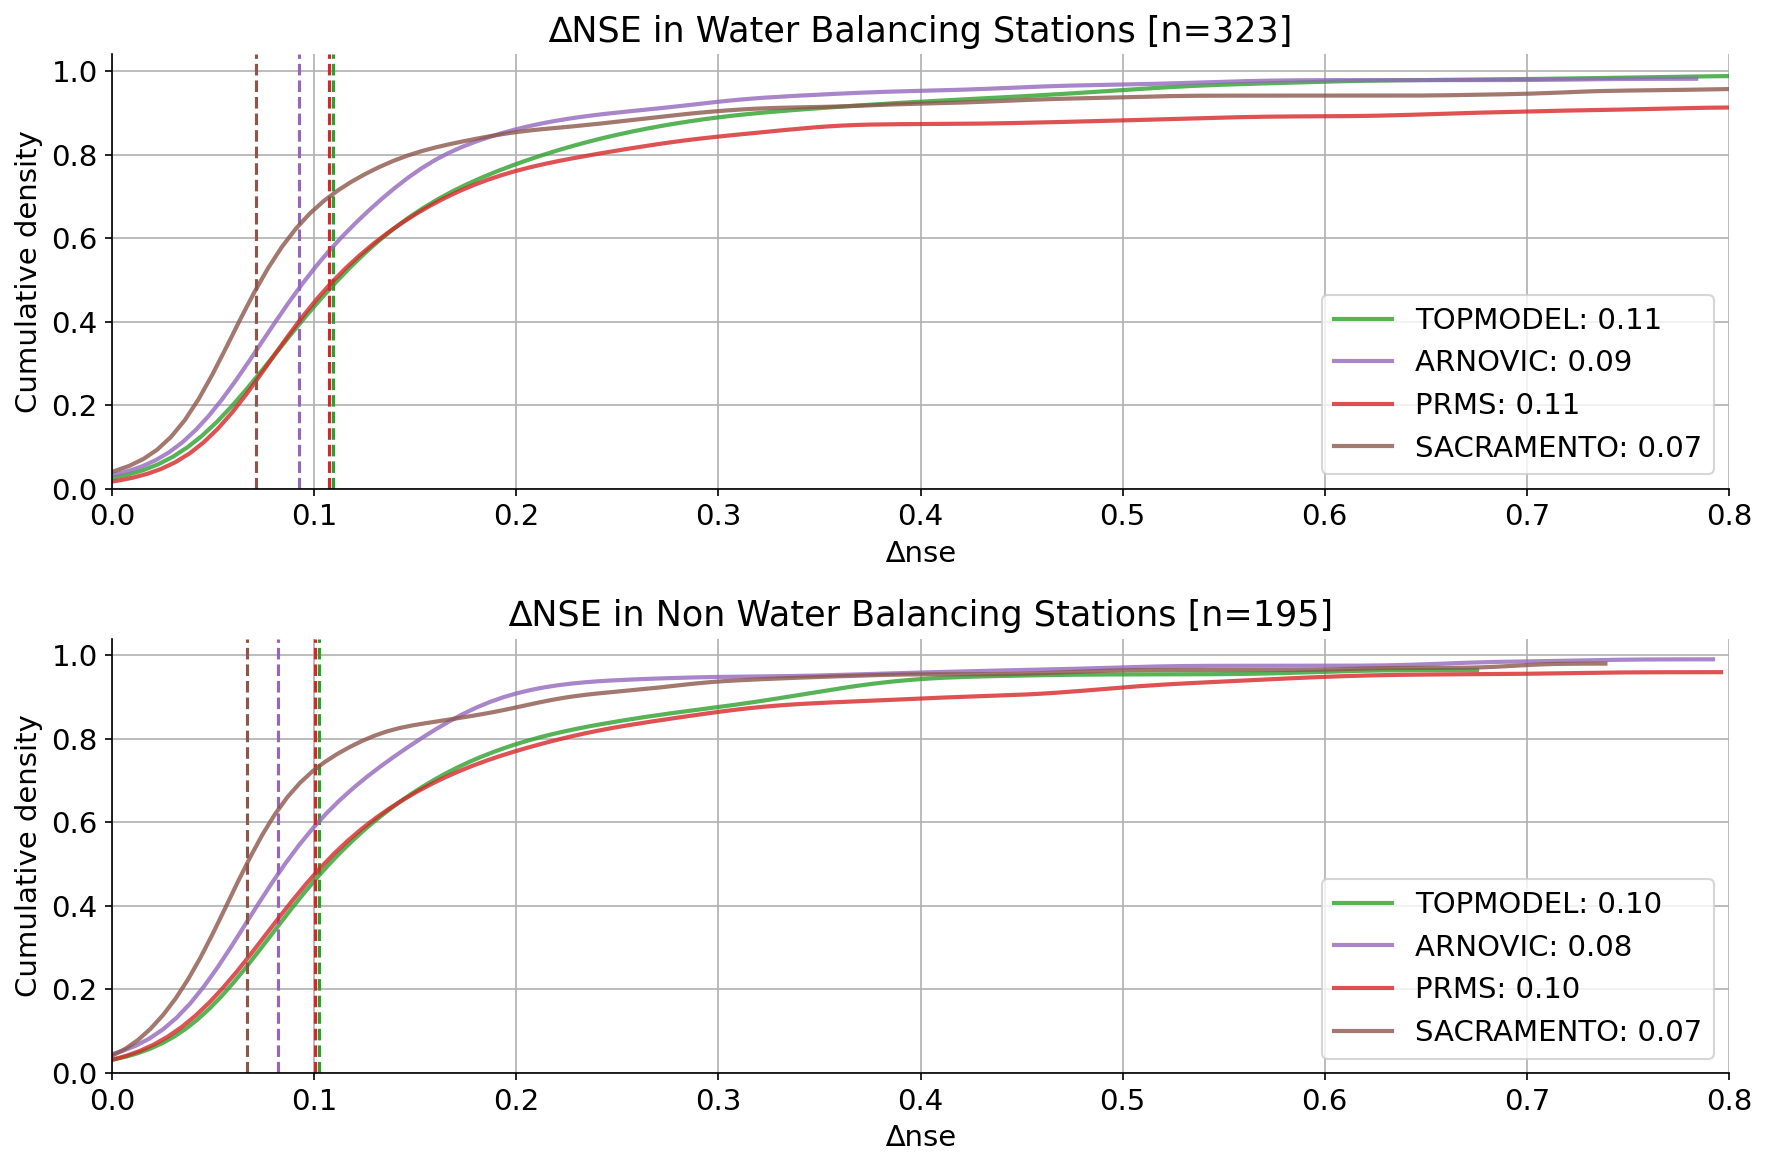

In [239]:
models = ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]

f, axs = plt.subplots(2, 1, figsize=((12, 4*2)))
ax = axs[0]
plot_cdf(delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values)], metric="∆nse", models=models, clip=(0, 0.8), ax=ax)
ax.set_title("∆NSE in Water Balancing Stations [n=323]")
ax.grid()

ax = axs[1]
plot_cdf(delta_gdf.loc[~np.isin(delta_gdf["ID"], wb_stations.values)], metric="∆nse", models=models, clip=(0, 0.8), ax=ax)
ax.set_title("∆NSE in Non Water Balancing Stations [n=195]")
ax.grid()

plt.tight_layout()

In [240]:
# delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values), "TOPMODEL"]
# delta_gdf.loc[(~np.isin(delta_gdf["ID"], wb_stations.values)), "TOPMODEL"]

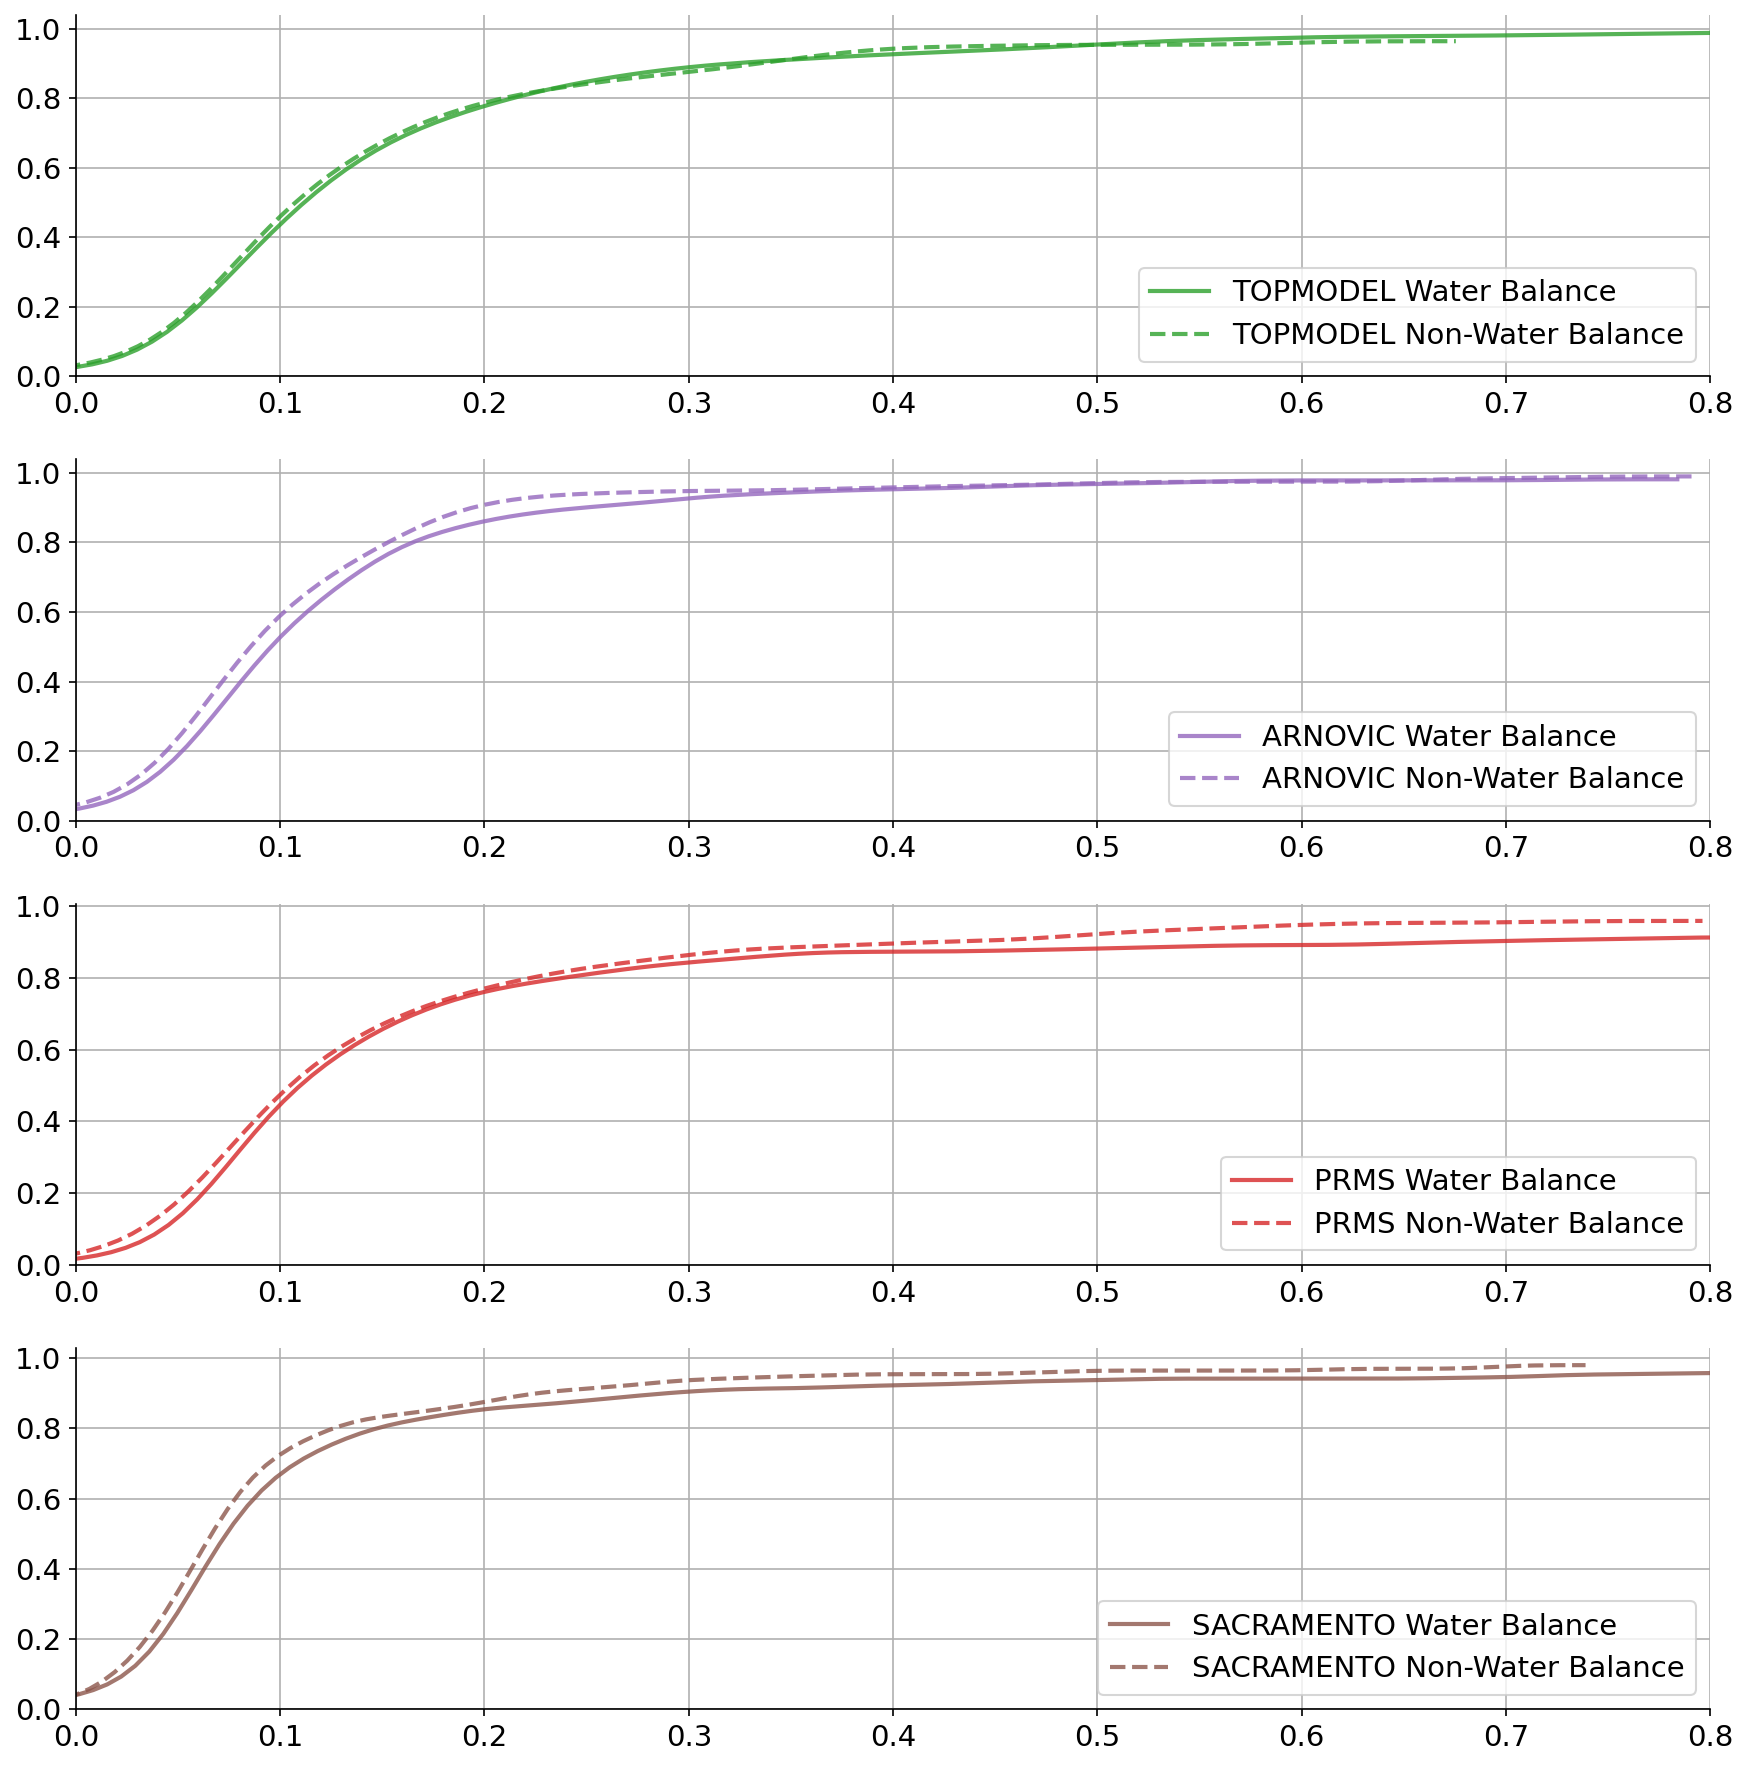

In [241]:
clip=(0, 0.8)
colors = sns.color_palette()
linewidth = 2
wb_kwargs = {
    "TOPMODEL": {"linewidth": linewidth, "alpha": 0.8, "color": colors[2], "clip": clip},
    "PRMS": {"linewidth": linewidth, "alpha": 0.8, "color": colors[3], "clip": clip},
    "ARNOVIC": {"linewidth": linewidth, "alpha": 0.8, "color": colors[4], "clip": clip},
    "VIC": {"linewidth": linewidth, "alpha": 0.8, "color": colors[4], "clip": clip},
    "SACRAMENTO": {"linewidth": linewidth, "alpha": 0.8, "color": colors[5], "clip": clip},
}
nonwb_kwargs = {
    "TOPMODEL": {"linewidth": linewidth, "alpha": 0.8, "color": colors[2], "clip": clip, "ls": "--"},
    "PRMS": {"linewidth": linewidth, "alpha": 0.8, "color": colors[3], "clip": clip, "ls": "--"},
    "ARNOVIC": {"linewidth": linewidth, "alpha": 0.8, "color": colors[4], "clip": clip, "ls": "--"},
    "VIC": {"linewidth": linewidth, "alpha": 0.8, "color": colors[4], "clip": clip, "ls": "--"},
    "SACRAMENTO": {"linewidth": linewidth, "alpha": 0.8, "color": colors[5], "clip": clip, "ls": "--"},
}



f, axs = plt.subplots(len(models), 1, figsize=((12, 3 * len(models))))
for ix, model in enumerate(models):
    ax = axs[ix]
    _wb_data = delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values), model]
    _non_wb_data = delta_gdf.loc[~np.isin(delta_gdf["ID"], wb_stations.values), model]
    _cdf_plot(data=_wb_data, label=f"{model} Water Balance", ax=ax, **wb_kwargs[model])
    _cdf_plot(data=_non_wb_data, label=f"{model} Non-Water Balance", ax=ax, **nonwb_kwargs[model])
    ax.set_xlim(clip)
    ax.legend()
    ax.grid()
    sns.despine()
plt.tight_layout()

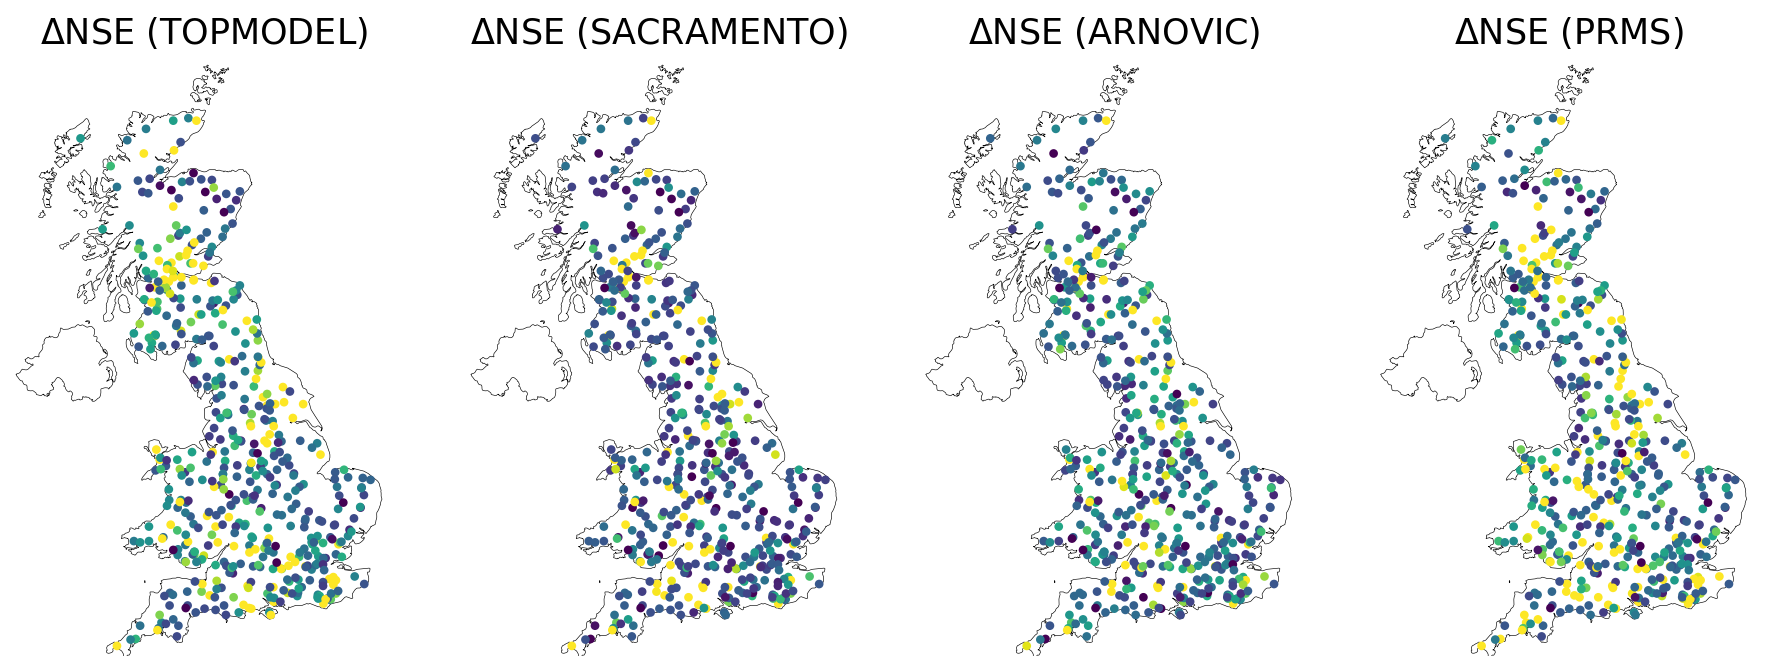

In [242]:
WATER_BALANCE_ONLY = False

markersize = 10
kwargs = {"vmin": 0, "vmax": 0.25, "cmap": "viridis", "markersize": markersize}
models = ["TOPMODEL", "SACRAMENTO", "ARNOVIC", "PRMS"]

from mpl_toolkits.axes_grid1 import make_axes_locatable
f, axs = plt.subplots(1, 4, figsize=(15, 6*4))


for model, ax in zip(models, axs):
#     delta_gdf.plot(model, ax=ax, **kwargs)
    ax.set_title(f"$\Delta$NSE ({model})")
    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    # plot the chloropleth
    if WATER_BALANCE_ONLY:
        delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values)].plot(model, ax=ax, **kwargs);
    else:
        delta_gdf.plot(model, ax=ax, **kwargs);
    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])


# divider = make_axes_locatable(axs[3])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# uk.plot(facecolor='none', edgecolor='k', ax=axs[3], linewidth=0.3)
# delta_gdf.plot("PRMS", ax=axs[3], legend=True, cax=cax, **kwargs)

for ax in axs:
    ax.axis('off')

(50.0, 59.5)

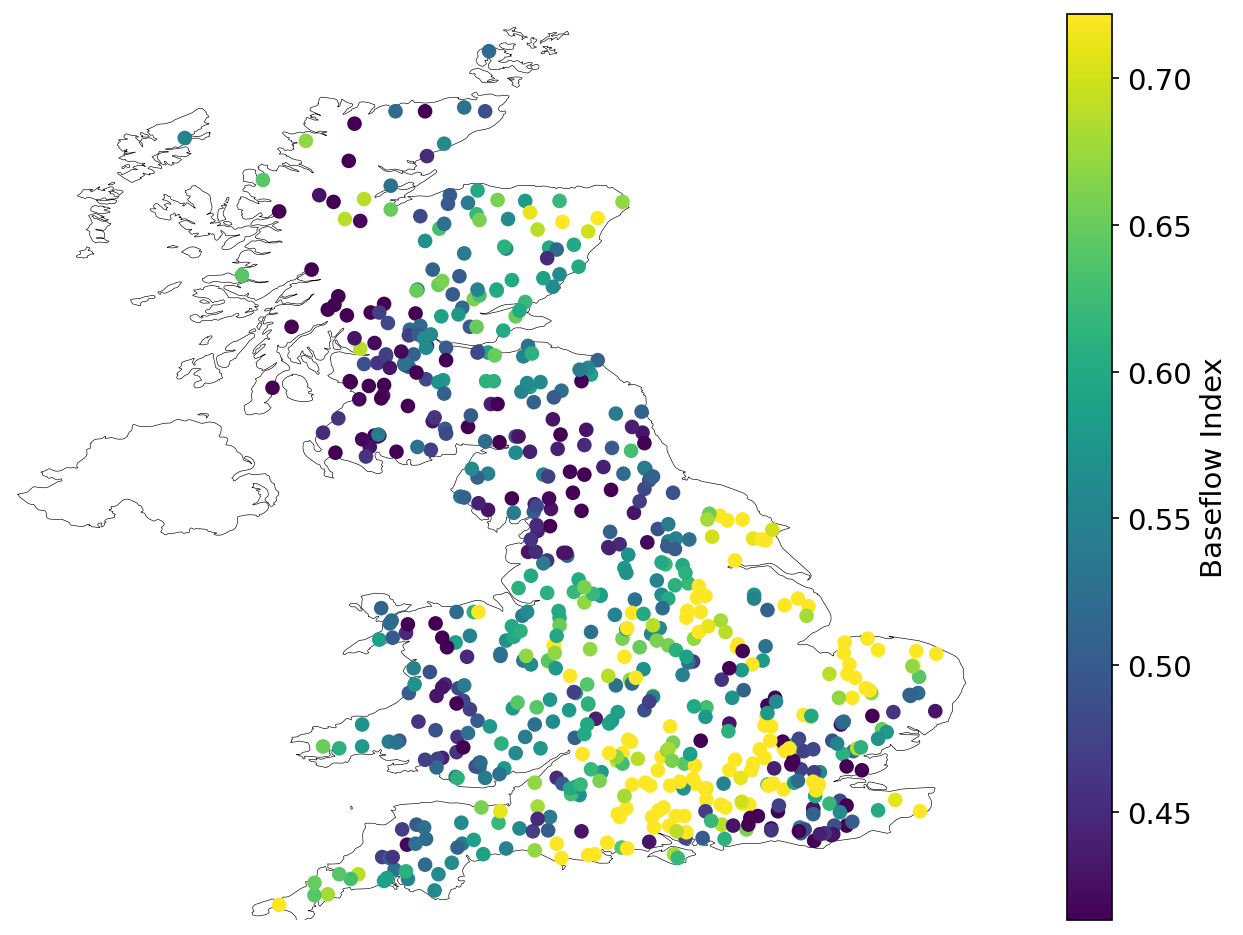

In [243]:
def make_point_static_gdf(feature: str) -> gpd.GeoDataFrame:
    gdf = geo_df.set_index("ID").join(static[feature].to_dataframe()).to_crs(epsg=4326)
    gdf = gpd.GeoDataFrame(gdf.drop("geometry", axis=1).join(points))
    return gdf




variable = "baseflow_index"
vrange = (None, None)

g = make_point_static_gdf(variable)
vrange = (
    np.max([0, g[variable].describe()["25%"] - (g[variable].describe()["std"] * 0.5)]),
    g[variable].describe()["75%"] + (g[variable].describe()["std"] * 0.5)
)
label = "Baseflow Index"
# label = "$\Delta$NSE"


f, ax = plt.subplots(figsize=(12, 8))
# gplt.polyplot(uk, ax=ax)
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
g.plot(variable, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap="viridis", legend=True, legend_kwds={"label": label})
# delta_gdf.plot(model, ax=ax, legend=True, legend_kwds={"label": label}, **kwargs);
ax.axis('off');
ax.set_xlim([-8.2, 2.1])
ax.set_ylim([50, 59.5])


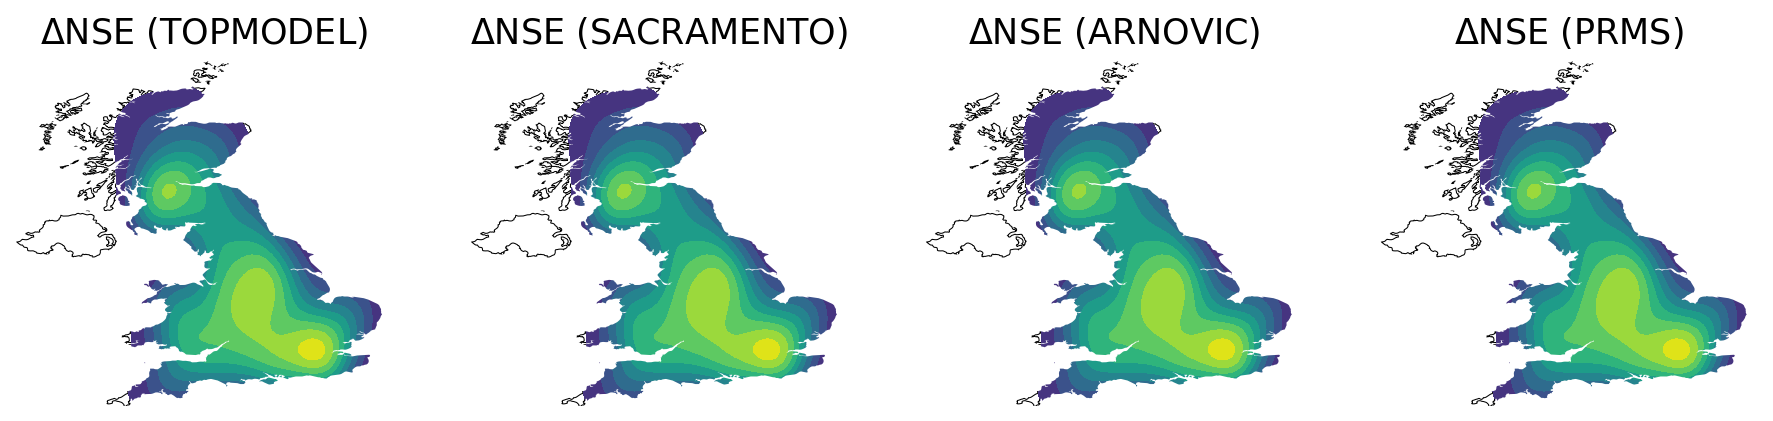

In [244]:
import geoplot as gplt
import matplotlib
# https://github.com/ResidentMario/geoplot/blob/bdffcd6763b8c948ce4d0308855a4df7ef9b7f1e/geoplot/geoplot.py#L467
# https://residentmario.github.io/geoplot/plot_references/plot_reference.html
# Note: can't get the legend for this data

f, axs = plt.subplots(1, 4, figsize=(15, 6*4))

for model, ax in zip(models, axs):
#     delta_gdf.plot(model, ax=ax, **kwargs)
    ax.set_title(f"$\Delta$NSE ({model})")
    
    gplt.polyplot(uk, ax=ax)
#     delta_gdf.plot(model, ax=ax, vmin=0, vmax=0.15)
    cmap = matplotlib.cm.get_cmap('viridis')
    gplt.kdeplot(
        delta_gdf[[model, "geometry"]], 
        cmap=cmap, 
        shade=True, 
        shade_lowest=False, clip=uk, ax=ax, 
#         **{"vmin": 0, "vmax": 0.05}
    )
    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])


In [245]:
def make_point_static_gdf(feature: str) -> gpd.GeoDataFrame:
    gdf = geo_df.set_index("ID").join(static[feature].to_dataframe()).to_crs(epsg=4326)
    gdf = gpd.GeoDataFrame(gdf.drop("geometry", axis=1).join(points))
    return gdf



In [246]:
# # geo_df
# q_mean = geo_df.set_index("ID").join(static["q_mean"].to_dataframe()).to_crs(epsg=4326)
# q_mean = gpd.GeoDataFrame(q_mean.drop("geometry", axis=1).join(points))
q_mean = make_point_static_gdf("q_mean")

# # q_mean.crs = {'init' :'epsg:4326'}

# f, ax = plt.subplots()
# cmap = matplotlib.cm.get_cmap('plasma')
# gplt.polyplot(uk, ax=ax)
# gplt.kdeplot(
#     q_mean[["q_mean", "geometry"]], 
#     cmap=cmap, 
#     shade=True, 
#     shade_lowest=True, clip=uk, ax=ax, 
#     **{"vmin": None, "vmax": 2.640000}
# )
# # ax.set_xlim([-8.2, 2.1])
# # ax.set_ylim([50, 59.5])

(50.0, 59.5)

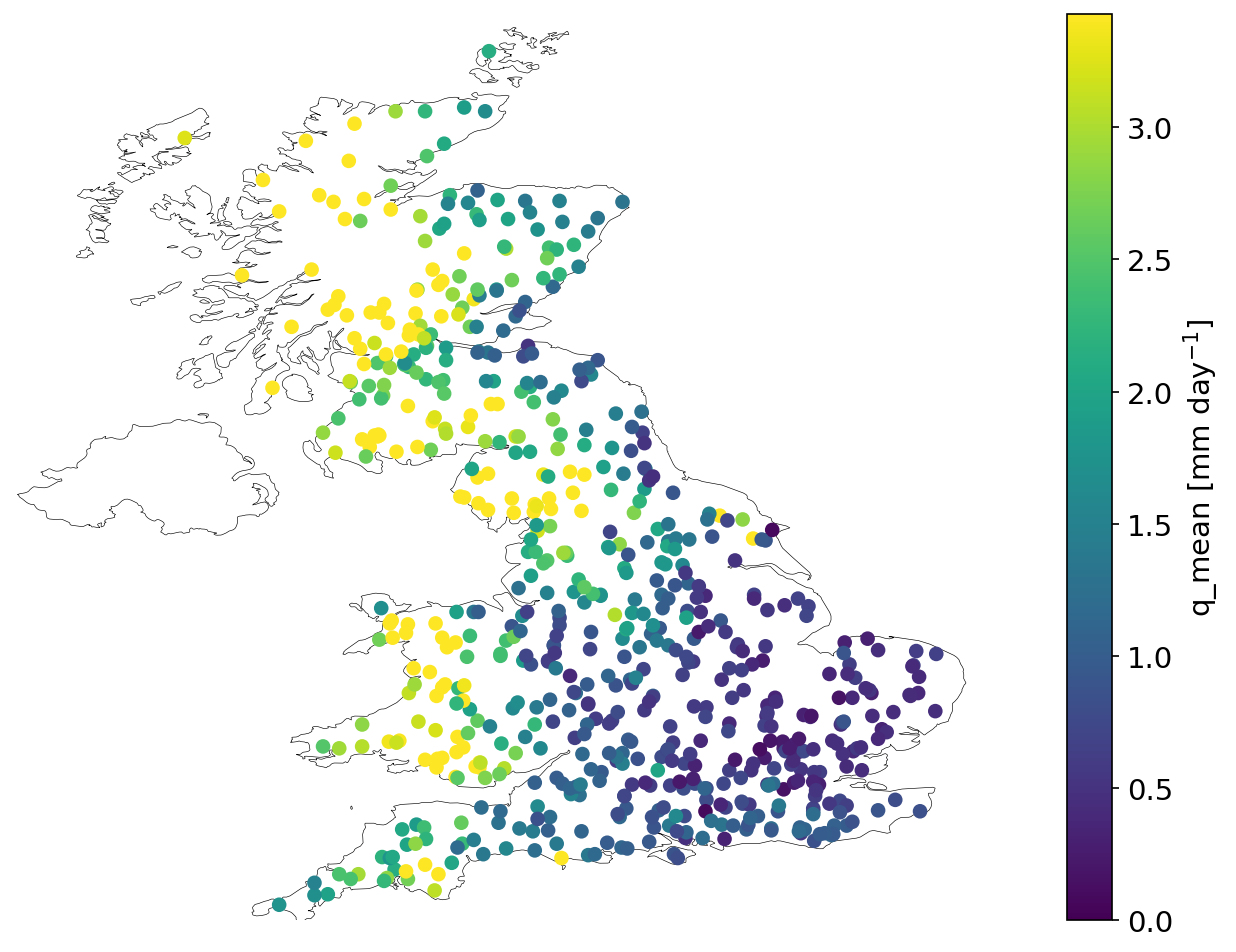

In [247]:
variable = "q_mean"
vrange = (None, None)

g = make_point_static_gdf(variable)
vrange = (
    np.max([0, g[variable].describe()["25%"] - (g[variable].describe()["std"] * 0.5)]),
    g[variable].describe()["75%"] + (g[variable].describe()["std"] * 0.5)
)
label = variable + " [mm day$^{-1}$]"


f, ax = plt.subplots(figsize=(12, 8))
# gplt.polyplot(uk, ax=ax)
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
g.plot(variable, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap="viridis", legend=True, legend_kwds={"label": label})
ax.axis('off');
ax.set_xlim([-8.2, 2.1])
ax.set_ylim([50, 59.5])


In [248]:
# variable = "low_prec_freq"

# g = make_point_static_gdf(variable)
# vrange = (None, None)
# vrange = (
#     np.max([0, g[variable].describe()["25%"] - (g[variable].describe()["std"] * 0.5)]),
#     g[variable].describe()["75%"] + (g[variable].describe()["std"] * 0.5)
# )
# label = variable + " [mm day$^{-1}$]"

# f, ax = plt.subplots(figsize=(12, 8))
# # gplt.polyplot(uk, ax=ax)
# uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
# g.plot(variable, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap="viridis", legend=True, legend_kwds={"label": label})
# ax.axis('off');
# ax.set_xlim([-8.2, 2.1])
# ax.set_ylim([50, 59.5])

In [249]:
# variable = "low_prec_freq"

# g = make_point_static_gdf(variable)
# vrange = (None, None)
# vrange = (
#     np.max([0, g[variable].describe()["25%"] - (g[variable].describe()["std"] * 0.5)]),
#     g[variable].describe()["75%"] + (g[variable].describe()["std"] * 0.5)
# )
# label = variable + " [mm day$^{-1}$]"

# f, ax = plt.subplots(figsize=(12, 8))
# # gplt.polyplot(uk, ax=ax)
# uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
# g.plot(variable, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap="viridis", legend=True, legend_kwds={"label": label})
# ax.axis('off');

In [250]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_static_feature_map(feature: str, label: str = None, ax = None, cmap: str = "viridis"):
    if ax is None:
        f, ax = plt.subplots()
    else:
        f = plt.gcf()
    g = make_point_static_gdf(feature)

    vrange = (
        np.max([0, g[feature].describe()["25%"] - (g[feature].describe()["std"] * 0.5)]),
        g[feature].describe()["75%"] + (g[feature].describe()["std"] * 0.5)
    )
    
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
    f.add_axes(cax)

    g.plot(feature, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap=cmap, legend=True, cax=cax, legend_kwds={"label": label, "orientation": "horizontal"})
    ax.axis('off');
    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])

    return ax

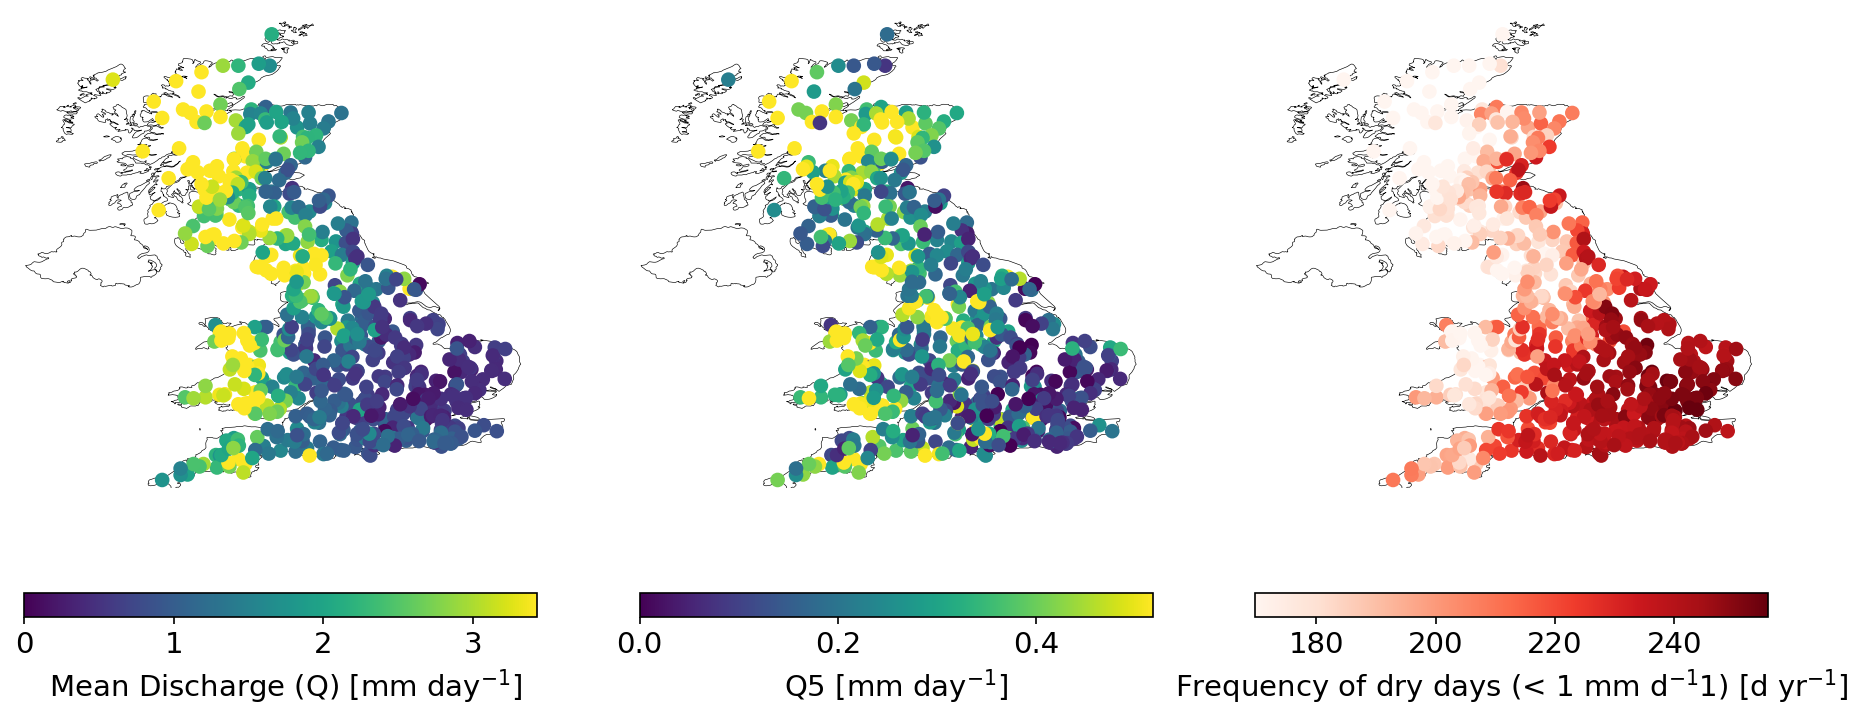

In [251]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

feature = "q_mean"
label = " Mean Discharge (Q) [mm day$^{-1}$]"
plot_static_feature_map(feature=feature, label=label, ax=axs[0])

feature = "Q5"
label = feature + " [mm day$^{-1}$]"
plot_static_feature_map(feature=feature, label=label, ax=axs[1])

feature = "low_prec_freq"
label = "Frequency of dry days (< 1 mm d$^{-1}$1) [d yr$^{-1}$]"
plot_static_feature_map(feature=feature, label=label, ax=axs[2], cmap="Reds")

# calculate seasonal deltas

In [252]:
assert False, "This takes a long time. Only run if required "

AssertionError: This takes a long time. Only run if required 

In [308]:
all_metrics.keys()

dict_keys(['nse', 'kge', 'mse', 'bias', 'log_nse', 'inv_kge', 'abs_pct_bias', 'mape', 'mam30_ape', 'rmse', 'flv'])

In [253]:
seasonal_deltas = defaultdict(dict)
for season in ["DJF", "MAM", "JJA", "SON"]:
    _preds = all_preds.sel(time=all_preds["time.season"] == season)
    seasonal_errors = processor.calculate_all_errors(_preds)
    _flv_model = processor.calc_kratzert_error_functions(_preds, metrics=["flv"])
    _flv_metric = get_metric_dataframes_from_output_dict(_flv_model)
    seasonal_errors["flv"] = _flv_metric["FLV"]
    
    seasonal_deltas[season]["LSTM"], seasonal_deltas[season]["EALSTM"] = processor.calculate_all_delta_dfs(seasonal_errors)
    seasonal_deltas[season]["raw"] = seasonal_errors

    
    
# seasonal_deltas = processor.calculate_seasonal_deltas(all_preds)

9it [01:04,  7.15s/it]
climatology_mon: 100%|██████████| 669/669 [00:03<00:00, 204.68it/s]
9it [01:05,  7.26s/it]
climatology_mon: 100%|██████████| 669/669 [00:03<00:00, 191.48it/s]
9it [01:08,  7.57s/it]
climatology_mon: 100%|██████████| 669/669 [00:03<00:00, 205.09it/s]
9it [01:04,  7.19s/it]
climatology_mon: 100%|██████████| 669/669 [00:03<00:00, 207.03it/s]


In [254]:
lstm_seasonal_dfs = {}
for season in ["DJF", "MAM", "JJA", "SON"]:
    lstm_seasonal_dfs[season] = seasonal_deltas[season]["LSTM"]["nse"]
    
ealstm_seasonal_dfs = {}
for season in ["DJF", "MAM", "JJA", "SON"]:
    ealstm_seasonal_dfs[season] = seasonal_deltas[season]["EALSTM"]["nse"]

In [255]:
display(lstm_seasonal_dfs["DJF"].head())
display(lstm_seasonal_dfs["MAM"].head())

TOPMODEL   ARNOVIC      PRMS  SACRAMENTO    EALSTM  persistence  \
station_id                                                                    
1001        0.255718  0.212321  0.190034    0.172069  0.022550     0.384543   
2001        0.312530  0.200088  0.195227    0.207088  0.026270     0.532334   
2002        0.202037  0.184820  0.209241    0.177478  0.025360     0.421191   
3003        0.115763  0.113059  0.140336    0.118772  0.048039     0.878163   
4001        0.213008  0.097541  0.151052    0.105561  0.034135     0.195449   

            climatology_doy  climatology_mon  
station_id                                    
1001               0.772682         0.804039  
2001               0.706866         0.729439  
2002               0.692630         0.719977  
3003               0.857613         0.867104  
4001               0.880280         0.892131

TOPMODEL   ARNOVIC      PRMS  SACRAMENTO    EALSTM  persistence  \
station_id                                                                    
1001        0.204691  0.170797  0.151625    0.135331  0.006783     0.352704   
2001        0.195695  0.138069  0.135978    0.132255 -0.020792     0.252894   
2002        0.190932  0.178501  0.194355    0.161794 -0.006863     0.190532   
3003        0.100091  0.118325  0.106390    0.098360  0.033258     0.680281   
4001        0.115441  0.081100  0.184549    0.119276  0.031092     0.054934   

            climatology_doy  climatology_mon  
station_id                                    
1001               0.664516         0.714727  
2001               0.568942         0.604968  
2002               0.592918         0.667351  
3003               0.776311         0.838517  
4001               0.600384         0.649528

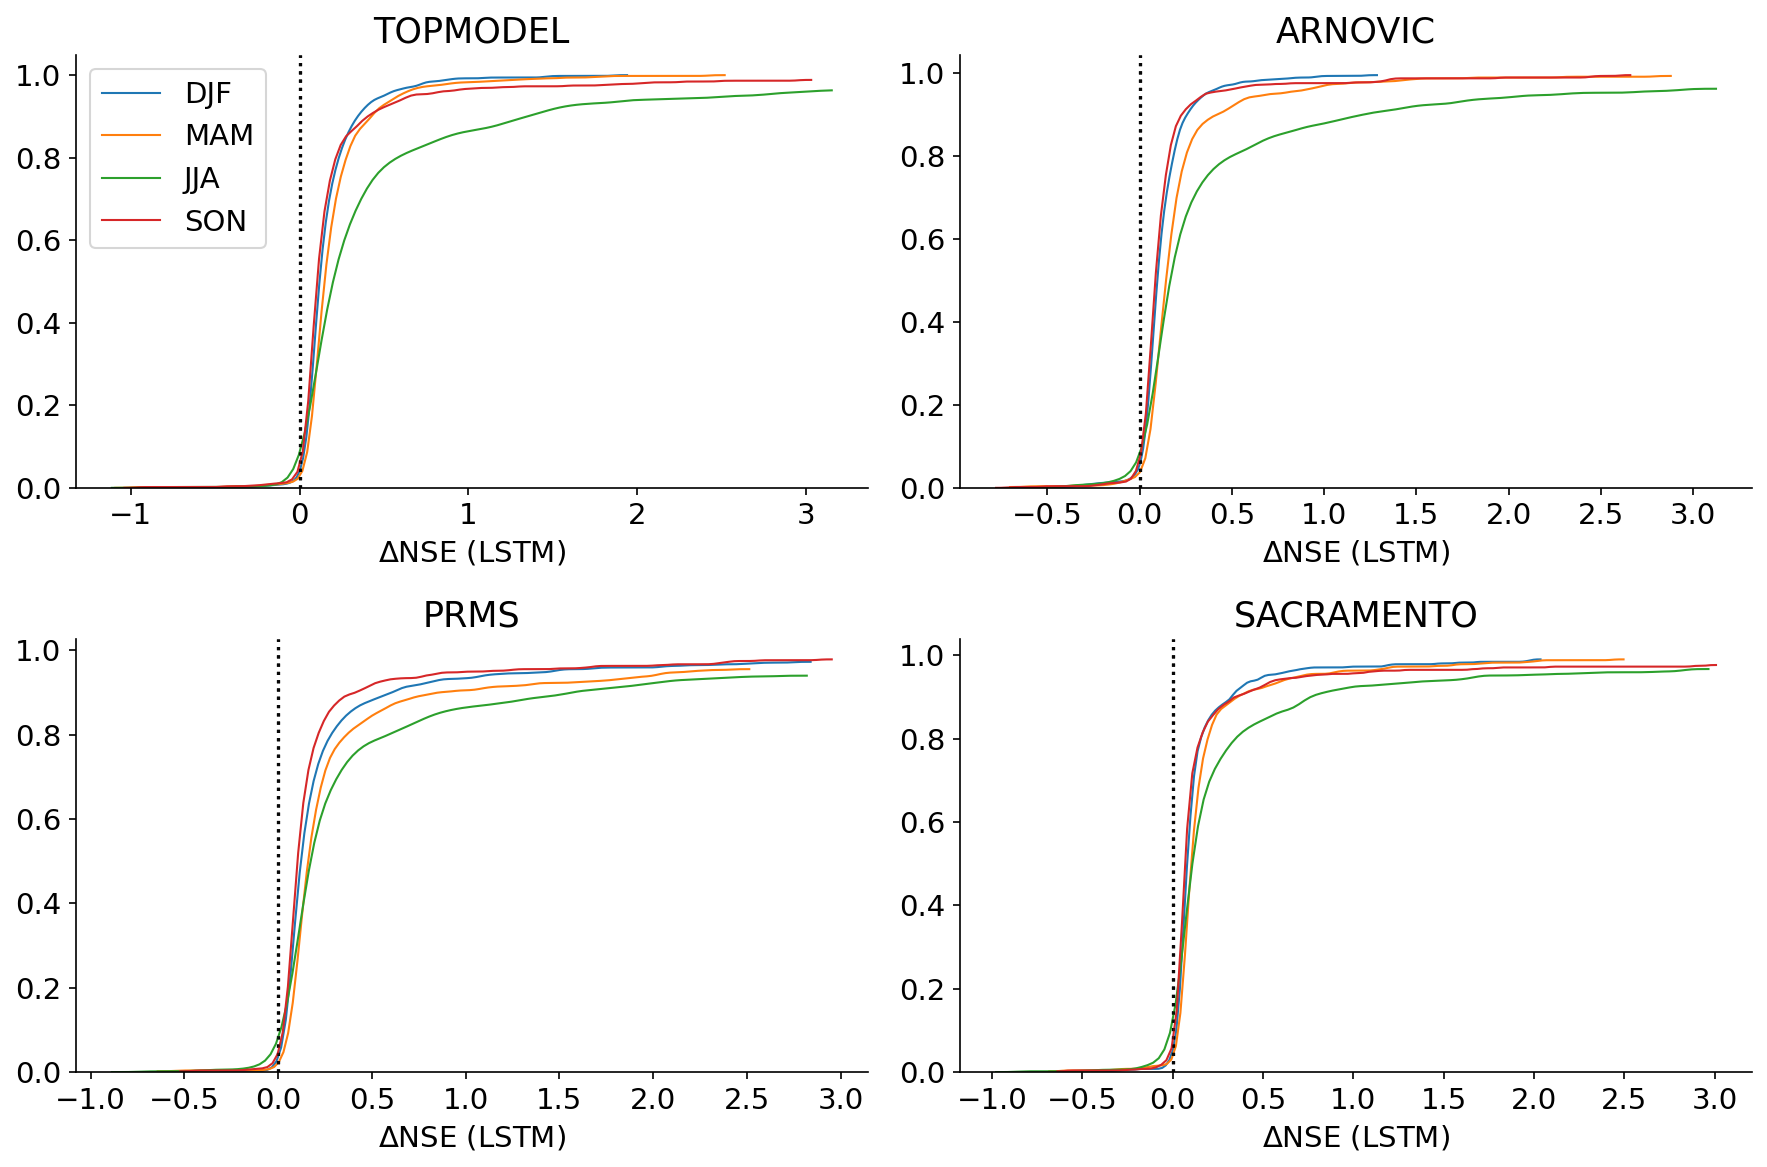

In [256]:
from typing import DefaultDict

# LSTM
metric = "nse"
ref_model = "LSTM"

def plot_seasonal_ecdfs(seasonal_deltas: DefaultDict, metric: str = "nse", ref_model: str = "LSTM", clip: Tuple[float] = (-1, 3)):
    fig, axs = plt.subplots(2, 2, figsize=(6*2, 4*2))

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax = axs[np.unravel_index(ix, (2, 2))]
        for season in ["DJF", "MAM", "JJA", "SON"]:
            sns.distplot(
                seasonal_deltas[season][ref_model][metric].loc[:, model].dropna(), 
                label=season, 
                kde_kws = {"clip": (-1, 3), "linewidth":1, "cumulative": True}, 
                hist=False, ax=ax
            )

            ax.axvline(0, ls=":", color="k", alpha=0.6)
            ax.set_xlabel(f"$\Delta${metric.upper()} ({ref_model})")
            ax.set_title(model)
            if ix != 0:
                ax.get_legend().remove()

            sns.despine()

    plt.tight_layout()
    
plot_seasonal_ecdfs(seasonal_deltas, metric="nse", ref_model="LSTM")

In [311]:
seasonal_deltas["DJF"]["raw"]["nse"]

TOPMODEL   ARNOVIC      PRMS  SACRAMENTO    EALSTM      LSTM  \
station_id                                                                 
1001        0.546502  0.589899  0.612186    0.630152  0.779670  0.802220   
2001        0.409973  0.522415  0.527277    0.515415  0.696233  0.722503   
2002        0.521230  0.538447  0.514025    0.545788  0.697906  0.723267   
3003        0.751007  0.753711  0.726434    0.747998  0.818731  0.866770   
4001        0.653768  0.769235  0.715724    0.761215  0.832641  0.866776   
...              ...       ...       ...         ...       ...       ...   
101002      0.691658  0.673261  0.631232    0.723864  0.675979  0.694724   
101005      0.612655  0.735056  0.479644    0.646389  0.770464  0.782306   
102001      0.651861  0.702097  0.651659    0.672561  0.737897  0.773064   
106001      0.794375  0.837179  0.843922    0.849083  0.862847  0.883634   
107001           NaN       NaN       NaN         NaN  0.566938  0.794810   

            persistence  climatology_doy  climatology_mon  
station_id                                                 
1001           0.417678         0.029538        -0.001819  
2001           0.190170         0.015638        -0.006935  
2002           0.302076         0.030637         0.003290  
3003          -0.011393         0.009157        -0.000334  
4001           0.671327        -0.013504        -0.025355  
...                 ...              ...              ...  
101002         0.123838         0.011182        -0.008170  
101005         0.045565         0.021646         0.007259  
102001         0.066924         0.075123         0.034806  
106001         0.630338         0.064062         0.019062  
107001         0.418938         0.066653         0.016266  

[667 rows x 9 columns]

In [257]:
# def create_bins(data: pd.Series, n_bins: int=4) -> pd.DataFrame:
#     assert all(np.isfinite(data)), "Weird behaviour with nans. Drop them. `data.dropna()`"
#     # get the groups where greater than zero
#     zero_indexes = data.loc[data < 0].index
#     out_series = pd.concat([
#         pd.qcut(data.loc[data > 0], q=n_bins),
#         pd.Series([pd.Interval(-np.inf, 0) for _ in range((data < 0).sum())], index=zero_indexes).astype("category"),
#     ])
#     out_series.name = "group"
    
#     # ordered categories
#     out_series = out_series.astype("category")
#     out_series = out_series.cat.as_ordered()
#     # create 2 columns of categories and code
#     df = pd.DataFrame({"category": out_series, "code": out_series.cat.codes})

#     return df


def create_custom_binned_data(data) -> pd.DataFrame:
    bins = pd.IntervalIndex.from_tuples([(-np.inf, 0), (0, 0.05), (0.05, 0.1), (0.1, 0.2), (0.2, np.inf)])
    bin_vals = pd.cut(season_deltanse["value"], bins, retbins=False)
    bin_vals = bin_vals.cat.as_ordered()
    bin_codes = bin_vals.cat.codes
    
    df = pd.DataFrame({"category": bin_vals, "code": bin_codes})
    return df

In [258]:
seasonal_deltas["DJF"]["LSTM"]["nse"]
seasonal_deltas["MAM"]["LSTM"]["nse"]
seasonal_deltas["SON"]["LSTM"]["nse"]
dd = seasonal_deltas["JJA"]["LSTM"]["nse"]

# flattened.pivot_table(values=['value'], index="station_id", columns=['variable'], aggfunc=lambda x: x)
all_season_deltanse = []
for season in ["DJF", "MAM", "JJA", "SON"]:
    dd = seasonal_deltas[season]["LSTM"]["nse"]
    flattened = dd.reset_index().melt(id_vars=["station_id"])
    flattened["season"] = season
    all_season_deltanse.append(flattened)

season_deltanse = pd.concat(all_season_deltanse).dropna()
# season_deltanse.join(create_custom_binned_data(season_deltanse["value"]))
binned_ = create_custom_binned_data(season_deltanse["value"])
season_deltanse["category"] = binned_["category"]
season_deltanse["code"] = binned_["code"]

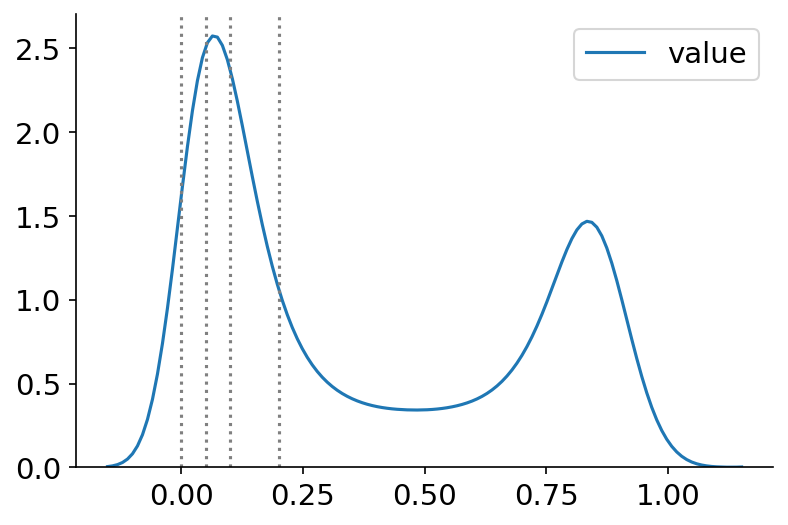

In [259]:
sns.kdeplot(season_deltanse["value"], clip=(0, 1))
ax = plt.gca()
for boundary in season_deltanse["category"].cat.categories.left[1:]:
    ax.axvline(boundary, ls=":", alpha=1, color="grey")
    
sns.despine()

In [260]:
C = season_deltanse.groupby(["category", "season"]).count()["code"].reset_index().rename(dict(code="count"), axis=1)
C["pct"] = (C["count"] / C.groupby("season").sum()["count"].loc[C["season"]].values) * 100
C["season"] = pd.Categorical(C["season"], ordered=True)
C["season"] = C["season"].cat.reorder_categories(["SON", "DJF", "MAM", "JJA"])

C.head()

category season  count        pct
0  (-inf, 0.0]    DJF    245   5.168776
1  (-inf, 0.0]    JJA    445   9.388186
2  (-inf, 0.0]    MAM    218   4.599156
3  (-inf, 0.0]    SON    295   6.223629
4  (0.0, 0.05]    DJF    780  16.455696

In [261]:
# print(dir(pd.Categorical(C["season"], ordered=True)))

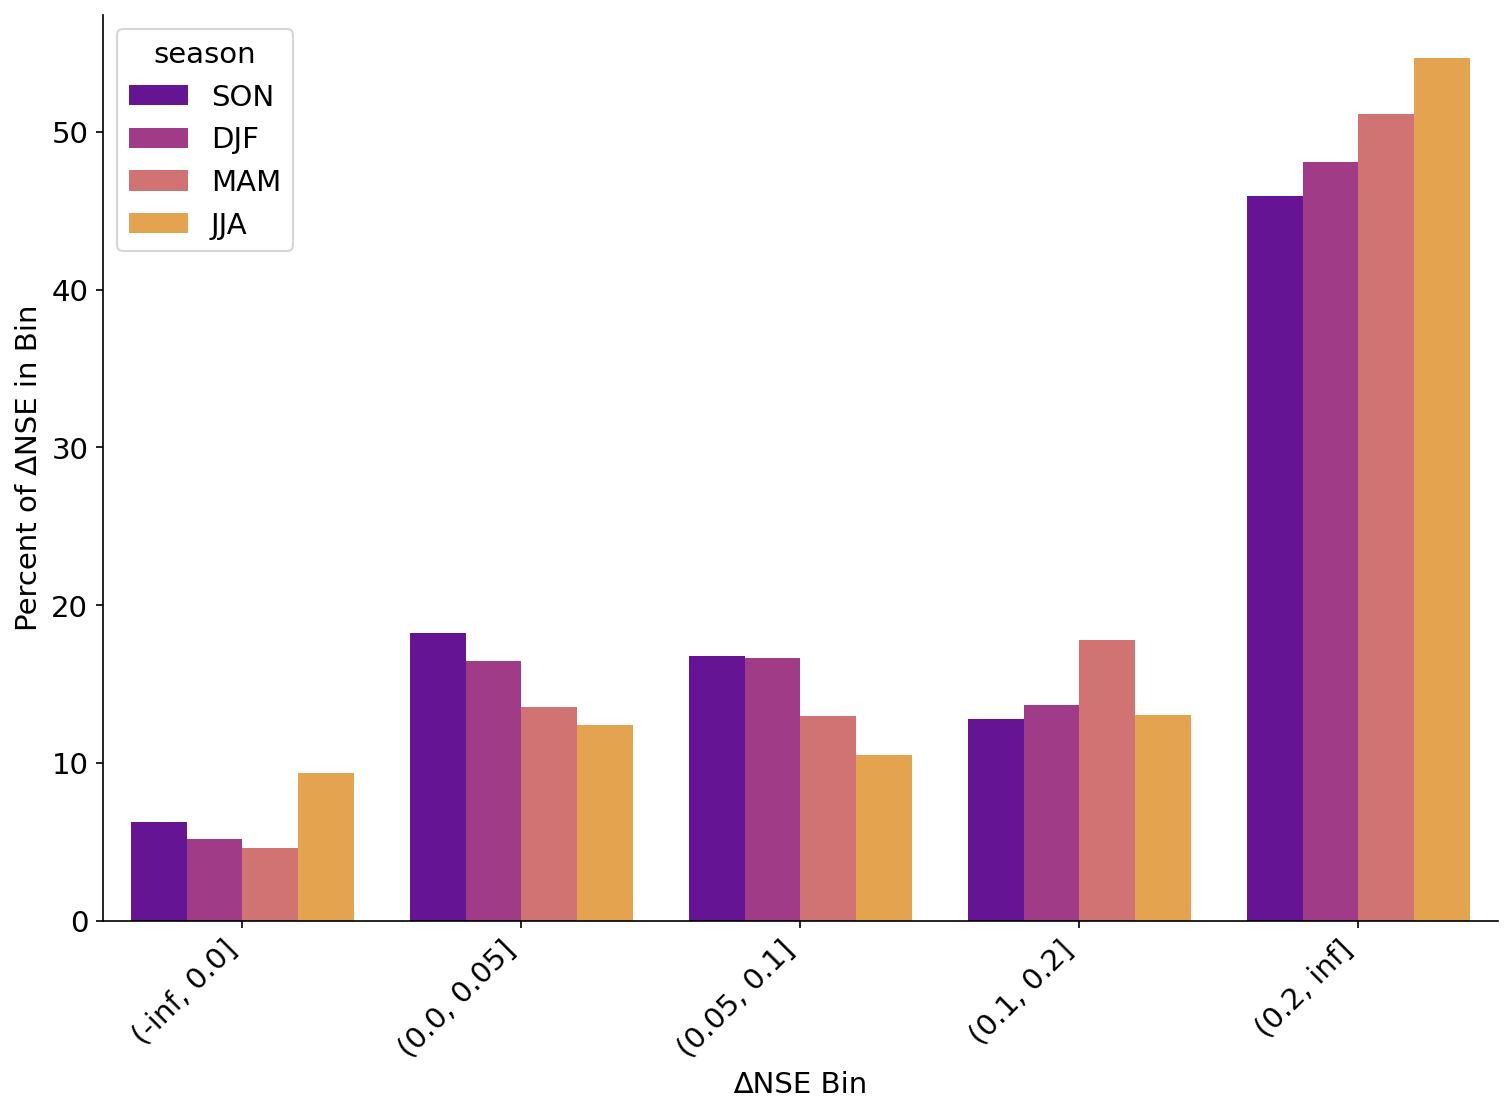

In [262]:
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(y="pct", x="category", hue="season", data=C, palette="plasma", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right");
ax.set_ylabel("Percent of ∆NSE in Bin")
ax.set_xlabel("∆NSE Bin")
sns.despine()

In [263]:
flattened.set_index("station_id").stack

<bound method DataFrame.stack of                    variable     value season
station_id                                  
1001               TOPMODEL  0.050051    SON
2001               TOPMODEL  0.037544    SON
2002               TOPMODEL  0.006324    SON
3003               TOPMODEL  0.025768    SON
4001               TOPMODEL  0.280844    SON
...                     ...       ...    ...
101002      climatology_mon  0.737241    SON
101005      climatology_mon  0.794009    SON
102001      climatology_mon  0.715245    SON
106001      climatology_mon  0.749078    SON
107001      climatology_mon  0.624621    SON

[5336 rows x 3 columns]>

# Explore Delta NSE

# What patterns in delta nse

# Spearmans Rank Correlation between static features & DeltaNSE

In [264]:
from scipy.stats import spearmanr
from collections import defaultdict

In [535]:
from typing import Optional, List, Dict, Tuple, DefaultDict
import pandas as pd
import numpy as np


def rank_correlation_static_metric(metric_df: pd.DataFrame, static: Optional[xr.Dataset] = None):
    if static is None:
        static = xr.open_dataset("/cats/datstore/data/RUNOFF/")
    
    static_df = static.to_dataframe()
    # numerical non nan rows
    static_ = static_df.loc[stations, (static_df.dtypes == "float64")]
    static_ = static_df.loc[:, ~(static_df.isnull().mean(axis=0) > 0)]
    
    # calculate rank correlation between all static features and performance metric
    all_spearmans: Dict[str, pd.DataFrame] = {}
    for model in models:
        spearmans_rank: DefaultDict[str, Dict[str, float]] = defaultdict(dict)
        for static_feature in static_.columns:
            a = static_df.loc[stations, static_feature]
            b = delta_metric.loc[stations, model]
            assert a.isnull().mean() == 0, f"{static_feature}"

            res = spearmanr(a, b)
            spearmans_rank[static_feature]["correlation"] = res.correlation
            spearmans_rank[static_feature]["pvalue"] = res.pvalue
            spearmans_rank[static_feature]["model"] = model

        spear_df = pd.DataFrame(spearmans_rank).T.reset_index().rename({"index": "feature"}, axis=1)
        all_spearmans[model] = spear_df
        
    return all_spearmans

In [536]:
spearmans2 = rank_correlation_static_metric(metric_df, static)

In [520]:
metric = "kge"

delta_metric = lstm_delta[metric]
stations = [sid for sid in delta_nse["TOPMODEL"].dropna().index]
models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]

# numerical non nan rows
static_ = static_df.loc[stations, (static_df.dtypes == "float64")]
static_ = static_df.loc[:, ~(static_df.isnull().mean(axis=0) > 0)]

all_spearmans = {}
for model in models:
    spearmans_rank = defaultdict(dict)
    for static_feature in static_.columns:
        a = static_df.loc[stations, static_feature]
        b = delta_metric.loc[stations, model]
        assert a.isnull().mean() == 0, f"{static_feature}"

        res = spearmanr(a, b)
        spearmans_rank[static_feature]["correlation"] = res.correlation
        spearmans_rank[static_feature]["pvalue"] = res.pvalue

    spear_df = pd.DataFrame(spearmans_rank).T.reset_index().rename({"index": "feature"}, axis=1)
    all_spearmans[model] = spear_df

In [521]:
from typing import List


def get_intersection_of_significant_features(all_spearmans: Dict[str, pd.DataFrame],p=0.01) -> List[str]:
    # get the features that have a significant correlation (p<0.01)
    all_features = []
    
    models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]
    for ix, model in enumerate(models):
        sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < p]
        all_features.append(sign_df["feature"].to_list())

    intersecting_features = set.intersection(*[set(feat) for feat in all_features])
    return list(intersecting_features)

intersecting_features = get_intersection_of_significant_features(all_spearmans, 0.01)

In [522]:
def create_long_form_dataset(all_spearmans: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    # create long form dataset
    all_correlations = []
    models = [k for k in all_spearmans.keys()]
    for ix, model in enumerate(models):
        df = all_spearmans[model]
        df["model"] = [model for _ in range(len(df))]
        all_correlations.append(df)

    all_correlations = pd.concat(all_correlations)
    return all_correlations

all_correlations = create_long_form_dataset(all_spearmans)

In [523]:
n_largest = 100
# def plot_the_10_significant_highest_correlations(all_spearmans: Dict[str, pd.DataFrame], p_value: float = 0.01, n_largest:int = 10):

# 1. get intersection of features for all models that have p<p_value
intersecting_features = get_intersection_of_significant_features(all_spearmans, 0.05)

# 2. create long form dataframe
all_correlations = create_long_form_dataset(all_spearmans)

# 3. subset the features that are significant for all models
all_correlations = all_correlations.loc[np.isin(all_correlations["feature"], intersecting_features)]
# drop the matching baseflow index
all_correlations = all_correlations[~np.isin(all_correlations["feature"], ["baseflow_index_ceh", ""])]

# 4. subset the n features with the largest mean correlation (across the 4 models)
n_largest_features = all_correlations.groupby("feature").median()["correlation"].abs().nlargest(n_largest).index
all_correlations = all_correlations.loc[np.isin(all_correlations["feature"], n_largest_features)]
all_correlations = all_correlations.sort_values(["correlation"])

# 5. subset the n largest features
all_correlations

Empty DataFrame
Columns: [feature, correlation, pvalue, model]
Index: []

In [524]:
sig_level = 0.05
significant = {}
for model in all_spearmans.keys():
    d = all_spearmans[model]
    print(f"{model}: {(d['pvalue'] < sig_level).mean():.2f}")
    significant[model] = (d.loc[(d['pvalue'] < sig_level)])
    
all_significant = pd.concat(significant.values())

TOPMODEL: 0.15
PRMS: 0.08
SACRAMENTO: 0.14
ARNOVIC: 0.03


In [526]:
all_significant.sort_values("pvalue")

feature  correlation    pvalue       model
23                silt_perc     0.149256  0.000655    TOPMODEL
23                silt_perc     0.145172  0.000921  SACRAMENTO
46        porosity_hypres_5     0.137476  0.001711    TOPMODEL
53    conductivity_cosby_95    -0.137071  0.001767    TOPMODEL
79               low_q_freq     0.132693  0.002477    TOPMODEL
41         porosity_cosby_5     0.128046  0.003508  SACRAMENTO
33              bulkdens_95    -0.127913  0.003543    TOPMODEL
59               root_depth    -0.123743  0.004797        PRMS
41         porosity_cosby_5     0.123540  0.004867    TOPMODEL
85            p_seasonality    -0.123473  0.004890    TOPMODEL
61             root_depth_5    -0.122263  0.005330        PRMS
5             frac_low_perc    -0.122018  0.005423  SACRAMENTO
53    conductivity_cosby_95    -0.119738  0.006364  SACRAMENTO
42        porosity_cosby_50     0.115888  0.008288  SACRAMENTO
3            frac_high_perc     0.115036  0.008779  SACRAMENTO
49       conductivity_cosby    -0.114164  0.009307    TOPMODEL
29                 bulkdens    -0.113561  0.009689    TOPMODEL
39           porosity_cosby     0.112933  0.010101    TOPMODEL
85            p_seasonality    -0.110834  0.011596        PRMS
44          porosity_hypres     0.110753  0.011657    TOPMODEL
21                sand_perc    -0.109446  0.012687    TOPMODEL
0           inter_high_perc    -0.107656  0.014229    TOPMODEL
59               root_depth    -0.107002  0.014833     ARNOVIC
89         high_prec_timing    -0.105703  0.016098    TOPMODEL
46        porosity_hypres_5     0.105169  0.016645  SACRAMENTO
102            station_type    -0.103865  0.018049  SACRAMENTO
39           porosity_cosby     0.103741  0.018188  SACRAMENTO
12            gauge_easting    -0.102757  0.019322        PRMS
33              bulkdens_95    -0.099709  0.023237  SACRAMENTO
11                gauge_lon    -0.099534  0.023481        PRMS
80                low_q_dur     0.098353  0.025188     ARNOVIC
23                silt_perc     0.097373  0.026686        PRMS
21                sand_perc    -0.094774  0.031032  SACRAMENTO
101          dom_land_cover    -0.094689  0.031184     ARNOVIC
89         high_prec_timing    -0.094468  0.031581        PRMS
27             organic_perc     0.093125  0.034092    TOPMODEL
101          dom_land_cover    -0.091231  0.037922  SACRAMENTO
37                  tawc_50     0.091157  0.038078    TOPMODEL
0           inter_high_perc    -0.090569  0.039343        PRMS
74                 hfd_mean    -0.089994  0.040616    TOPMODEL
17                  elev_10    -0.088611  0.043816  SACRAMENTO
57   conductivity_hypres_50    -0.088259  0.044665  SACRAMENTO
62            root_depth_50    -0.087189  0.047325        PRMS
93               dwood_perc     0.087070  0.047630  SACRAMENTO

ValueError: min() arg is an empty sequence

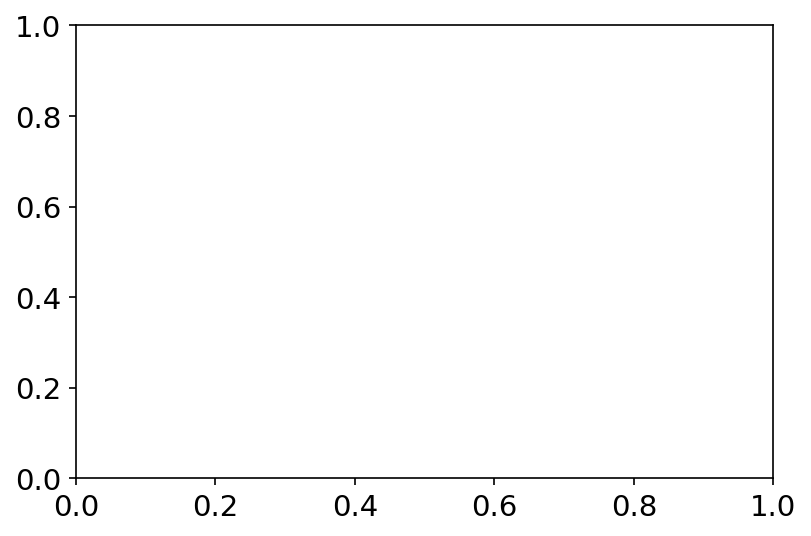

In [527]:
fig, ax = plt.subplots()
sns.barplot(x="feature", y="correlation", data=all_correlations, ax=ax, color="grey")   # hue="model", 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title(f"Top {n_largest} features: Abs(Correlation($\Delta$NSE, Feature))")
ax.set_ylabel("$\\rho$($\Delta$NSE, feature)")
sns.despine()

In [312]:
# plot correlation for top n features for each model (split by model delta nse)
if False:
    f, axs = plt.subplots(4, 1, figsize=(12, 4*4))
    plot_all = False
    nlargest = 10

    for ix, model in enumerate(models):
        ax = axs[ix]
        if plot_all:
            # only select those with p values below X point
            sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]
            sign_df.sort_values("correlation").set_index("feature")["correlation"].plot.bar(ax=ax)
        else:
            # Plot Intersecting features
            intersect_df = all_spearmans[model].set_index("feature").loc[list(intersecting_features)]
            n_largest_features = intersect_df["correlation"].abs().nlargest(nlargest).index
            sort_df = intersect_df.loc[n_largest_features].sort_values("correlation")["correlation"]
            sort_df.plot.bar(ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_title("Correlation($Delta$NSE$_{" + model + "}$, Static Features)")
        ax.set_ylabel("$\\rho$")
        sns.despine()

    plt.tight_layout()

In [313]:
# sign_df.set_index("feature")["correlation"]

In [314]:
# all_spearmans["TOPMODEL"]["feature"]

In [315]:
sign_features = {}
for model in models:
    # only select those with p values below X point
    sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]
    sign_features[model] = sign_df["feature"].values

# features across all four models
sets = [set(v) for v in sign_features.values()]
features_for_analysis = list(sets[0].intersection(sets[1]).intersection(sets[2]).intersection(sets[3]))
features_for_analysis
len(features_for_analysis)

0

### Other correlation plots

In [316]:
# plot ordered plot of correlation of features for EACH model and ALL significant  features
if False:
    for model in models:
        # only select those with p values below X point
        sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]

        f, ax = plt.subplots(figsize=(12, 4))
        # spear_df.reindex(spear_df["correlation"].abs().sort_values(ascending=False).index)
        sign_df.sort_values("correlation").set_index("feature")["correlation"].plot.bar(ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_title("Correlation($Delta$NSE$_{" + model + "}$, Static Features)")
        ax.set_ylabel("$\\rho$")
        sns.despine()

In [317]:
#  Plot the normalised values of NSE vs. static feature - regression plots
if False:
    from sklearn.preprocessing import normalize, MinMaxScaler
    stations = [sid for sid in delta_nse["TOPMODEL"].dropna().index]

    norm_static = pd.DataFrame(MinMaxScaler().fit_transform(static))
    norm_static.columns = static.columns
    norm_static.index = static.index

    delta_nse_nonans = delta_nse.dropna()
    norm_nse = pd.DataFrame(MinMaxScaler().fit_transform(delta_nse_nonans))
    norm_nse.columns = delta_nse_nonans.columns
    norm_nse.index = delta_nse_nonans.index

    n_rows = (len(features_for_analysis) // 2) + (len(features_for_analysis) % 2)
    f, axs = plt.subplots(n_rows, 2, figsize=(3*2, 2*n_rows))
    for ix, static_feature in enumerate(features_for_analysis):
        ax_ix = np.unravel_index(ix, (n_rows, 2))
        ax = axs[ax_ix]

        # get the X, y data
        sort_index = norm_nse.loc[stations, model].sort_values(ascending=True).index
        y = norm_static.loc[stations, static_feature].reindex(sort_index)
        x = norm_nse.loc[stations, model].reindex(sort_index)
        ax.scatter(x, y)

        # plot regression
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef) 
        y_hat = poly1d_fn(x)
        ax.plot(x, y_hat, ls=":", color="k", label=f"{coef[0]:.2f}")

        ax.set_title(static_feature)
        ax.legend()

        if ax_ix[0] == n_rows - 1:
            ax.set_xlabel("$\Delta$NSE")
        sns.despine()

    plt.tight_layout()

# Where does the LSTM do worse?

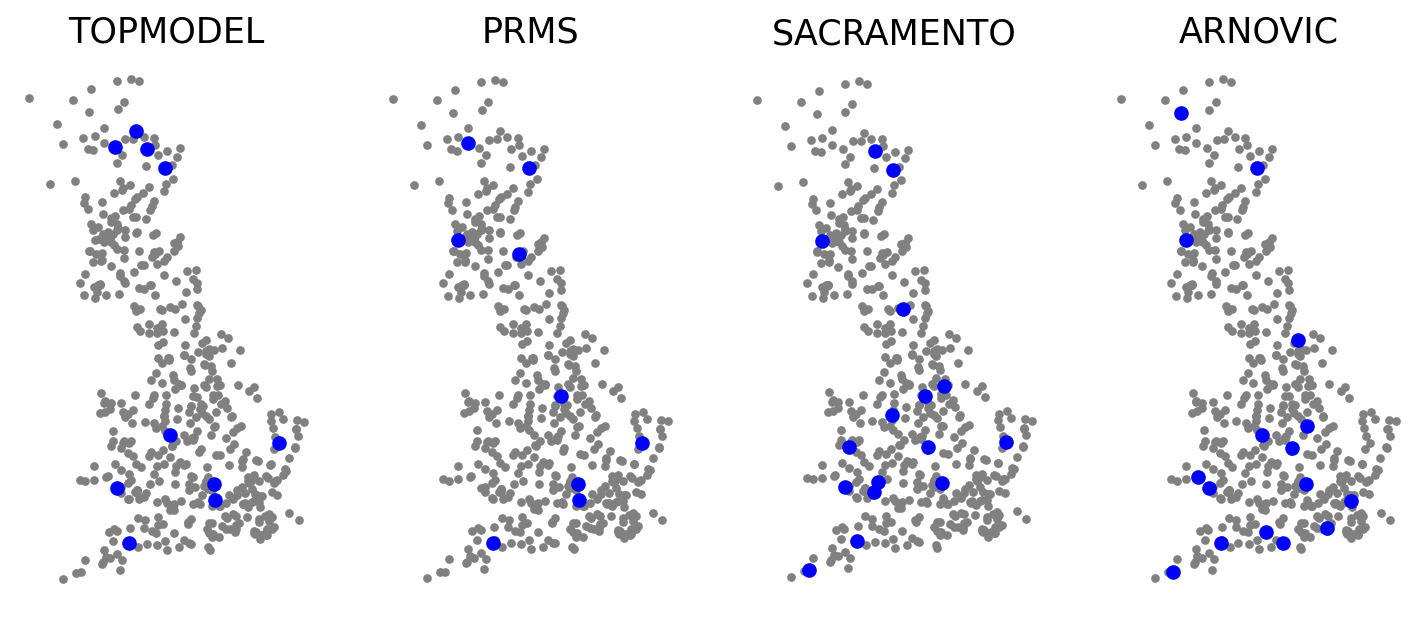

In [381]:
from matplotlib import colors

cmap = colors.ListedColormap(["grey", sns.color_palette()[0]])

f, axs = plt.subplots(1, 4, figsize=(12, 8*4))

worse_basins = {}
models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]
for ix, model in enumerate(models):
    ax = axs[ix]
    ax.set_title(model)
    delta_gdf[f"{model}_bool"] = delta_gdf[model] < 0
    # delta_gdf.plot(f"{model}_bool", ax=ax, cmap=cmap, markersize=10)
    delta_gdf.loc[delta_gdf[model] > 0].plot(f"{model}_bool", ax=ax, color="grey", markersize=10)
    delta_gdf.loc[delta_gdf[model] < 0].plot(f"{model}_bool", ax=ax, color="blue", markersize=None)
    
    worse_basins[model] = delta_gdf.loc[delta_gdf[model] < 0].index
    
for ax in axs:
    ax.axis('off')

In [382]:
flatten = lambda t: [item for sublist in t for item in sublist]

all_worse_sids = set(flatten(worse_basins.values()))

In [383]:
print(f"{len(all_worse_sids)} Catchments that LSTMs Worse (than ANY conceptual)")

30 Catchments that LSTMs Worse (than ANY conceptual)


In [384]:
# def smooth_lowess(x, y, kwargs: Dict = {}) -> Tuple[pd.Series]:
#     from statsmodels.nonparametric.smoothers_lowess import lowess

#     # wrapper for statsmodels lowess
#     try:
#         smooth_y = lowess(y, x, return_sorted=False, **kwargs)
#     except AttributeError:
#         x, y = x.values.flatten(), y.values.flatten()
#         smooth_y = lowess(y, x, return_sorted=False, **kwargs)
    
#     df = x.rename("x").to_frame()
#     df["y"] = smooth_y
#     df = df.dropna().sort_values("x")
#     return df["x"], df["y"]

# import patsy
# patsy.dmatrix("")

def lr_line(x: pd.Series, y: pd.Series) -> np.array:
    x_unique = np.unique(x)
    
    # fit the coefficients
    reg = np.polyfit(x, y, 1)
    # make a prediction
    lm = np.poly1d(reg)
    y_hat = lm(x_unique)

    return x_unique, y_hat

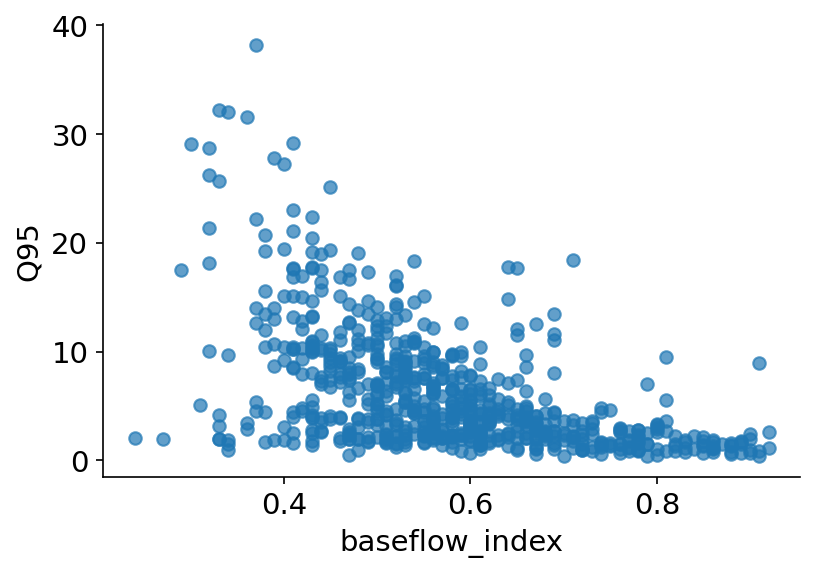

In [385]:
xvar = "baseflow_index"
yvar = "q_mean"
yvar = "Q95"
spline = True

# f, axs = plt.subplots(1, 2)

# ax = axs[0]

f, ax = plt.subplots()
x = static[xvar].to_dataframe()
y = static[yvar].to_dataframe()

ax.scatter(x, y, alpha=0.7)
# x_uq, y_hat = lr_line(x[xvar], y[yvar])
# ax.plot(x_uq, y_hat, color="k", ls="--")

ax.set_xlabel(xvar)
ax.set_ylabel(yvar)

sns.despine()

## Which basins do all 3 of the conceptual models outperform the LSTM

In [388]:
conceptual_better = delta_gdf[[c for c in delta_gdf.columns if "bool" in c]]
# conceptual_better[np.any(conceptual_better, axis=1)]
worse_stations = [sid for sid in conceptual_better[np.all(conceptual_better, axis=1)].index if sid in matching_stations]
len(conceptual_better[np.all(conceptual_better, axis=1)])
worse_stations
len(worse_stations)

3

In [389]:
def plot_stations(stations):
    f, ax = plt.subplots() 

    delta_gdf.loc[~np.isin(delta_gdf.index, stations)].plot(f"{model}_bool", ax=ax, color="grey", markersize=10)
    delta_gdf.loc[np.isin(delta_gdf.index, stations)].plot(f"{model}_bool", ax=ax, color="blue", markersize=None)
    ax.axis('off')

(-6.814, 1.854, 49.742, 58.938)

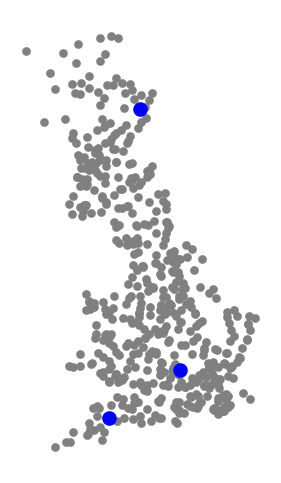

In [390]:
f, ax = plt.subplots() 

delta_gdf.loc[~np.isin(delta_gdf.index, worse_stations)].plot(f"{model}_bool", ax=ax, color="grey", markersize=10)
delta_gdf.loc[np.isin(delta_gdf.index, worse_stations)].plot(f"{model}_bool", ax=ax, color="blue", markersize=None)
ax.axis('off')

In [391]:
# fuse_errors_fp = data_dir / "RUNOFF/0_fuse_errors.pkl"
# fuse_class_fp = data_dir / "RUNOFF/0_fuse_class.pkl"
# 
# f_class = pickle.load(fuse_class_fp.open("rb"))
# fuse_errors = pickle.load(fuse_errors_fp.open("rb"))
# vic_error = f_class.get_model_df("VIC")
# prms_error = f_class.get_model_df("PRMS")
# top_error = f_class.get_model_df("TOPMODEL")
# sac_error = f_class.get_model_df("Sacramento")

In [450]:
vic_error = all_errors["ARNOVIC"]
prms_error = all_errors["PRMS"]
top_error = all_errors["TOPMODEL"]
sac_error = all_errors["SACRAMENTO"]

In [429]:
d = nse_df.loc[[int(sid) for sid in all_worse_sids]] 
d.head()

TOPMODEL   ARNOVIC      PRMS  SACRAMENTO    EALSTM      LSTM  \
station_id                                                                 
43009       0.709393  0.914042  0.572491    0.189460  0.885836  0.910758   
54019       0.489338  0.597212  0.418837    0.629786  0.533578  0.512641   
48003       0.458522  0.701263 -0.147260    0.717137  0.549988  0.619979   
54024       0.556848  0.712022 -0.486424    0.223346  0.407519  0.510047   
33034       0.531106  0.460639  0.532530    0.533316  0.495333  0.513938   

            persistence  climatology_doy  climatology_mon  
station_id                                                 
43009          0.986187         0.350678         0.341289  
54019          0.913775         0.291314         0.281179  
48003          0.886763         0.112356         0.108707  
54024          0.703067        -0.062181        -0.077980  
33034          0.351712         0.059887         0.031822

In [431]:
# (d["LSTM"] - d.drop("LSTM", axis=1).T).min().sort_values()

In [432]:
# worse_df
models = ["LSTM", "EALSTM", "TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]
order_ = nse_df.loc[[int(sid) for sid in all_worse_sids], models] # .drop("Name", axis=1)
order_ = (order_["LSTM"] - order_.drop("LSTM", axis=1).T).min().sort_values()

print(f"Median Absolute Delta NSE for the Stations where DeltaNSE < 0: {order_.abs().median():.02f}")
print(order_.index)

Median Absolute Delta NSE for the Stations where DeltaNSE < 0: 0.02
Int64Index([39105, 12008,  7003, 54024, 59001, 54019, 60010, 48003, 45012,
            27071,  9005, 54044, 43021,  7001, 28024, 39027,  3003, 25012,
            33034, 56002, 28043, 40016, 84017, 28091, 56001, 63004, 41014,
             6007, 43009, 21006],
           dtype='int64', name='station_id')


In [433]:
worse_nse = nse_df.loc[[int(sid) for sid in all_worse_sids]]

Int64Index([43009, 54019, 48003, 54024, 33034, 28043, 43021, 21006, 54044,
            63004,  9005, 84017, 25012, 41014, 28091,  3003, 27071, 39105,
            56001, 56002, 40016, 45012,  7001,  7003, 12008, 60010, 39027,
             6007, 28024, 59001],
           dtype='int64', name='station_id')

In [434]:
# lstm_metric_df
# worse_nse = nse_df.loc[[int(sid) for sid in all_worse_sids]]

# worse_df = worse_nse.reset_index().set_index(["index", "Name"]).stack().reset_index(-1).rename({"level_2": "model", 0: "nse"}, axis=1).reset_index("Name")
# worse_df = worse_df.reset_index().rename({"index": "station_id"}, axis=1).astype({"station_id": str})

# order from greatest difference to minimum difference
# worse_df = worse_df.set_index("station_id").loc[[str(sid) for sid in order_.index]]

# len(worse_df)
worse_df = worse_nse[models + ["EALSTM", "LSTM"]]
worse_df = worse_df.stack().reset_index(-1).rename({"level_1": "model", 0: "nse"}, axis=1)

names = static[["gauge_name"]].to_dataframe()
names = names.loc[np.isin(names.index, worse_df.index)]
worse_df = names.join(worse_df).rename({"gauge_name": "Name"}, axis=1).loc[[int(sid) for sid in order_.index]]

## Plot the RAW NSEs for the comparison models

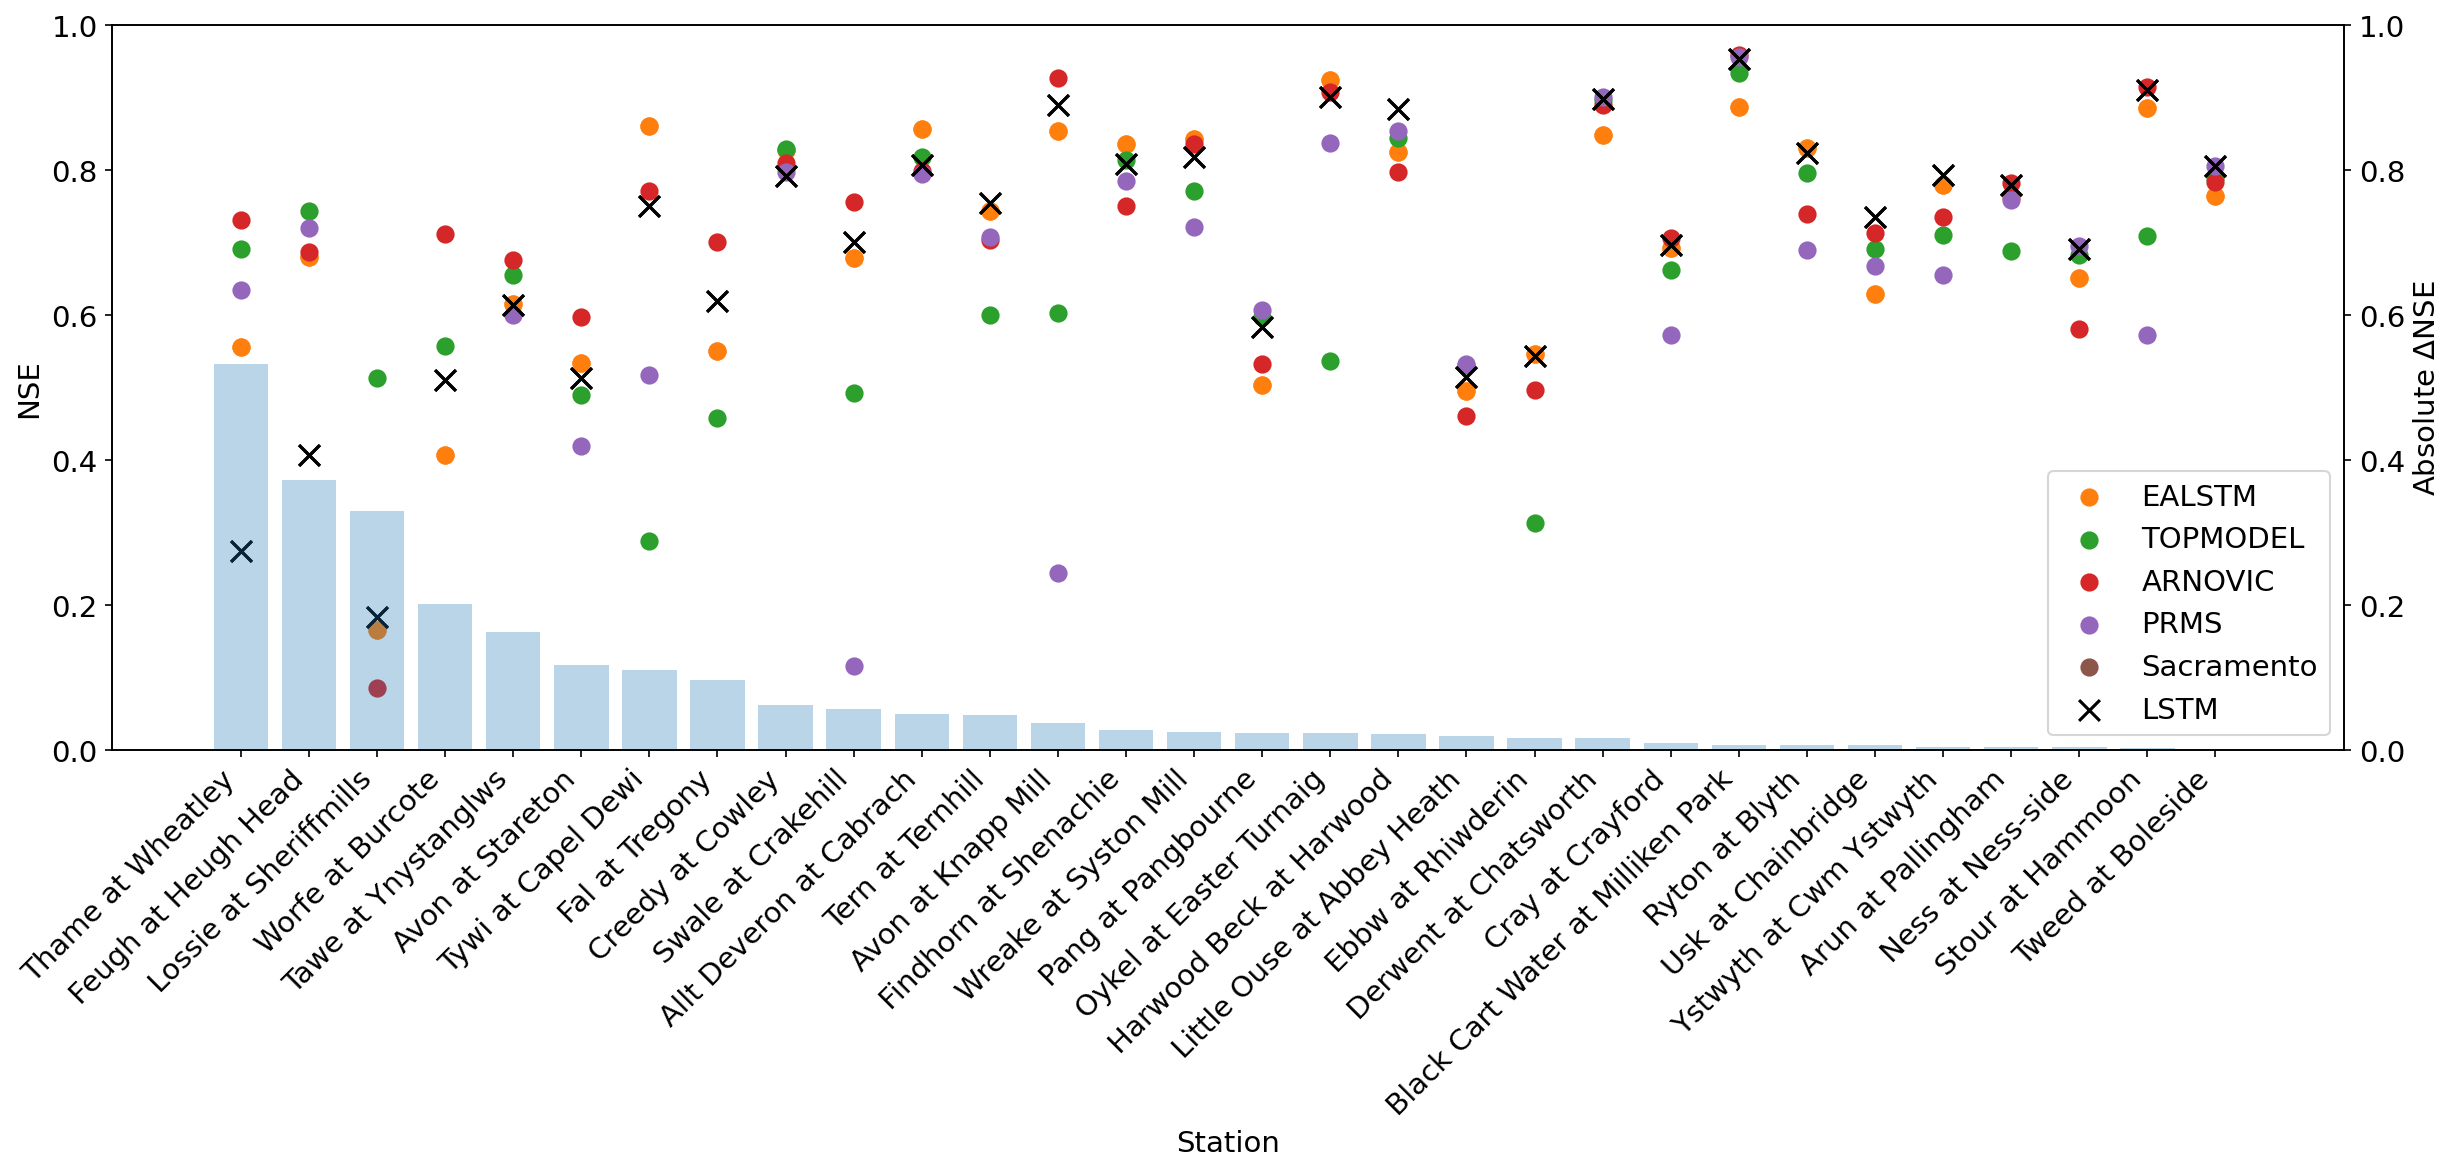

In [446]:
scale = 1.6

# plot_data = worse_df 
# plot_data["nse"] = plot_data["nse"] + np.random.normal(0, 0.01, len(plot_data["nse"]))
# TOPMODEL (green), VIC (red), PRMS (purple), Sacramento
model_order = ["LSTM", "EALSTM", "TOPMODEL", "ARNOVIC", "PRMS", "Sacramento"]
abs_ = True
f, ax = plt.subplots(figsize=(12*scale, 4*scale))

# PLOT THE CONCEPTUAL MODEL NSE PERFORMANCE
colors = sns.color_palette()[1: len(model_order)]
for ix, model in enumerate(model_order[1:]):
    plot_data = worse_df.loc[worse_df["model"] == model]
    ax.scatter(plot_data["Name"], plot_data["nse"], color=colors[ix], s=60, label=model)

# PLOT THE LSTM MODEL NSE PERFORMANCE
plot_data = worse_df.loc[worse_df["model"] == "LSTM"]
ax.scatter(plot_data["Name"], plot_data["nse"], color="k", marker="x", s=100, label="LSTM")
plt.xticks(rotation=45, ha="right")

ax.set_xlabel("Station")
ax.set_ylabel("NSE")
ax.set_ylim(0, 1)
ax.legend()

# Plot the raw difference
ax2 = ax.twinx()
if abs_:
    ax2.bar(plot_data.drop_duplicates()["Name"], abs(order_), alpha=0.3)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Absolute $\Delta$NSE")
else:
    ax2.bar(plot_data.drop_duplicates()["Name"], order_, alpha=0.3)
    ax2.set_ylim(-0.7, 0)
    ax2.set_ylabel("$\Delta$NSE")
# sns.despine()

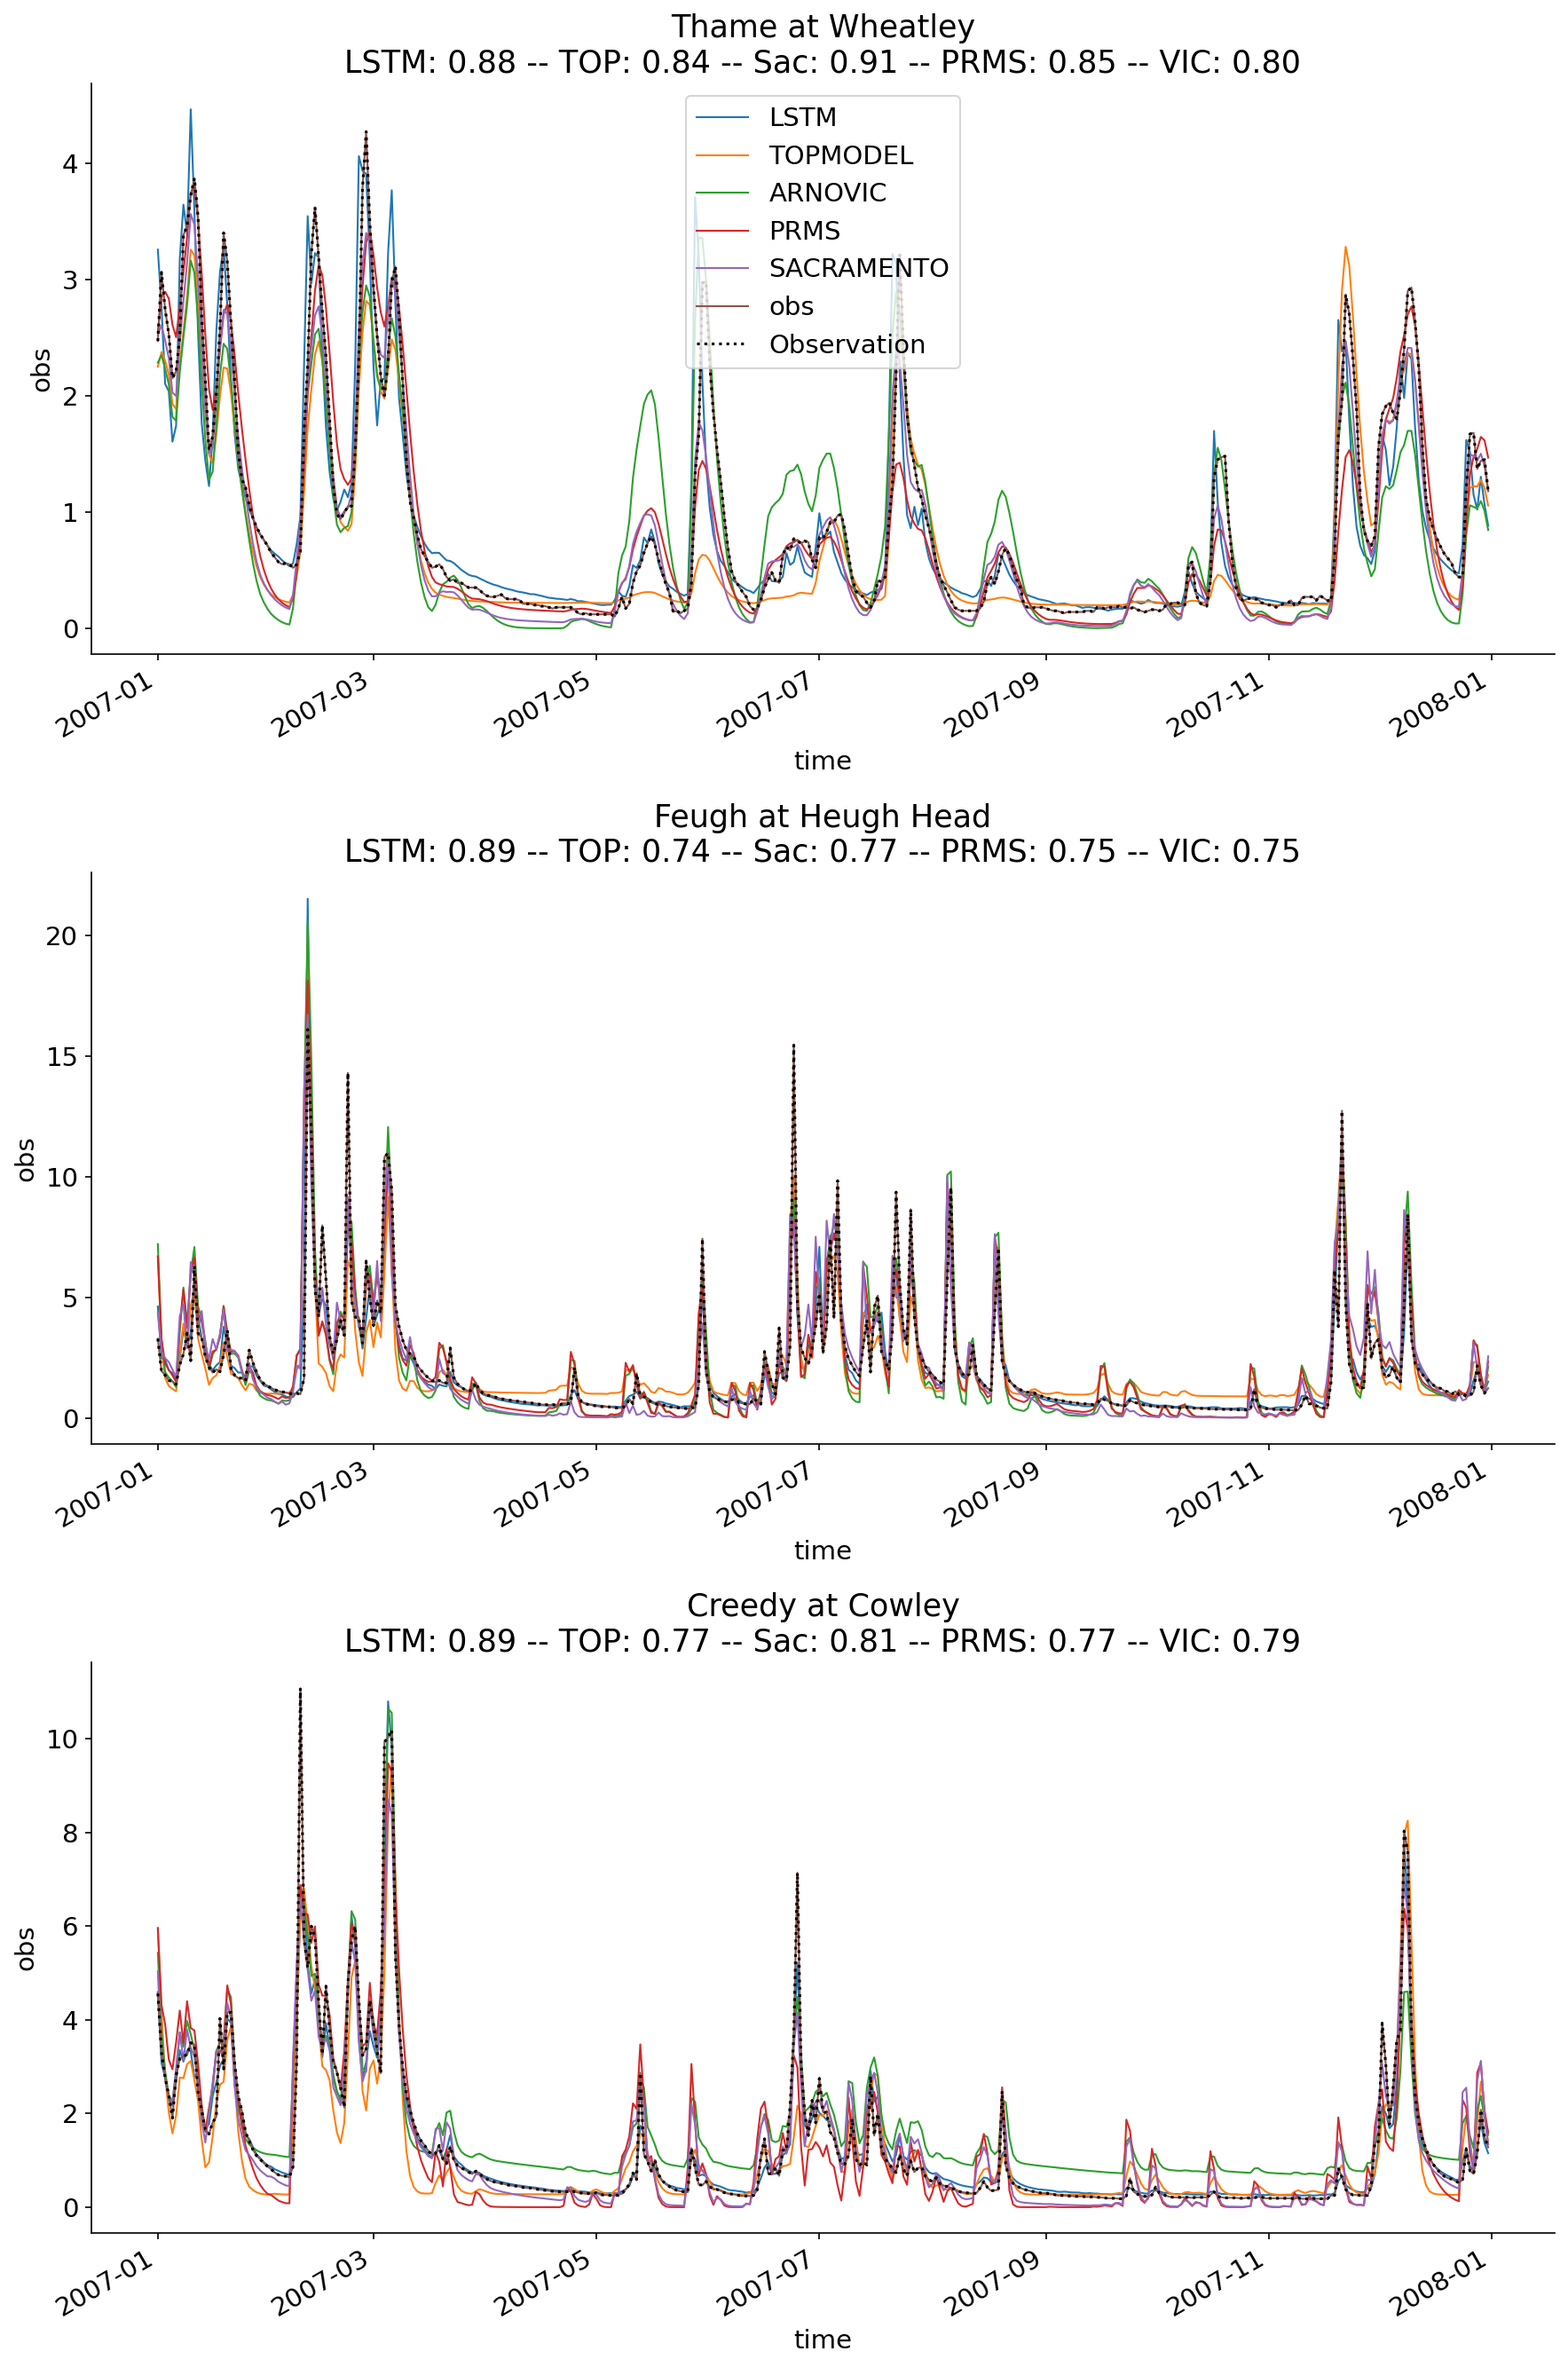

In [452]:
static = all_static
station_names = static["gauge_name"].to_dataframe()

worse_stations_ = worse_stations
# ANY worse basins = 33
# worse_stations = [int(sid) for sid in all_worse_sids]
# ALL worse basins = 3
# worse_stations = [int(sid) for sid in worse_stations_]

f, axs = plt.subplots(len(worse_stations), 1, figsize=(12, 6*len(worse_stations)))
for ix, sid in enumerate(lstm_preds.sel(station_id=worse_stations).station_id):
    ax = axs[ix]
    # LSTM
    lstm_preds.sel(station_id=sid, time=lstm_preds["time.year"] == 2007)["sim"].plot(ax=ax, **{"label": "LSTM", "linewidth": 1})

    # conceptual models
    fuse_d = fuse_data.sel(station_id=sid, time=fuse_data["time.year"] == 2007)
    for v in [str(v) for v in fuse_d.data_vars]:
        fuse_d[v].plot(ax=ax, **{"label": str(v).replace("SimQ_", ""), "linewidth": 1})
    
    # obs
    lstm_preds.sel(station_id=sid, time=lstm_preds["time.year"] == 2007)["obs"].plot(ax=ax, color="k", ls=":", **{"label": "Observation"})
    
    # title
    name = str(station_names.loc[int(sid)][0])
    nse = float(lstm_metric_df.loc[int(sid), "nse"])
    top_nse = top_error.loc[int(sid)]["nse"]
    vic_nse = vic_error.loc[int(sid)]["nse"]
    prm_nse = prms_error.loc[int(sid)]["nse"]
    sac_nse = sac_error.loc[int(sid)]["nse"]
    ax.set_title(
        f"{name}\n"
        f"LSTM: {nse:.2f} -- TOP: {top_nse:.2f} -- Sac: {sac_nse:.2f} -- PRMS: {prm_nse:.2f} -- VIC: {vic_nse:.2f}"
    )
    if ix == 0:
        ax.legend()

plt.tight_layout()
sns.despine()

worse_stations = worse_stations_

## Measure the difference between Catchments - KS Test 
- [Scipy implementation](https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets)
- This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution. The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’.
- If the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same


In [453]:
from scipy.stats import ks_2samp
from collections import defaultdict

In [454]:
# (static_df.dtypes == "float64").sum()
better_stations = np.isin(static_df.index, conceptual_better.any(axis=1).index[conceptual_better.any(axis=1)])

In [455]:
wilcoxon_results = defaultdict(dict)
for static_feature in static_df.loc[:, static_df.dtypes == "float64"].columns:
    test_result = ks_2samp(
        static_df.loc[better_stations, static_feature],
        static_df.loc[[ix for ix in static_df.index if ix not in better_stations], static_feature]
    )
    wilcoxon_results[static_feature]["statistic"] = test_result.statistic
    wilcoxon_results[static_feature]["pvalue"] = test_result.pvalue
    
ks_df = pd.DataFrame(wilcoxon_results).T.reset_index().rename({"index": "static_feature"}, axis=1)
ks_df.sort_values("pvalue").head(20)

static_feature  statistic    pvalue
12                  area   0.351813  0.001108
48    conductivity_cosby   0.242871  0.056081
20             sand_perc   0.232141  0.076109
38        porosity_cosby   0.230651  0.079318
24             clay_perc   0.228217  0.084806
4          frac_mod_perc   0.219573  0.106886
97          inwater_perc   0.215648  0.118377
116           discharges   0.212419  0.128482
105     q25_uncert_lower   0.198460  0.180971
94            shrub_perc   0.198261  0.181888
1         inter_mod_perc   0.196374  0.190196
107     q50_uncert_lower   0.196026  0.191624
18               elev_90   0.194883  0.196922
121    abs_industry_perc   0.194536  0.198391
22             silt_perc   0.191356  0.213560
80             low_q_dur   0.188127  0.229720
53   conductivity_hypres   0.187730  0.231719
88         high_prec_dur   0.180427  0.271793
118   abs_amenities_perc   0.180030  0.274116
99    flow_perc_complete   0.179583  0.276888

In [456]:
static_for_worse = static_df.loc[better_stations, ks_df.loc[ks_df["pvalue"] < 0.05, "static_feature"]]
static_for_better = static_df.loc[[ix for ix in static_df.index if ix not in better_stations], ks_df.loc[ks_df["pvalue"] < 0.05, "static_feature"]]
display(static_for_better.head())
display(static_for_worse.head())

area
station_id        
1001        158.18
2001        553.24
2002        423.48
3003        331.67
4001        962.45

area
station_id         
3003         331.67
6007        1830.73
7001         415.59
7003         216.66
9005          68.08

# Plot ECDFs for features with significant difference
1. Get the basins where ANY of the conceptual models outperform the LSTM models
1. calculate the KS statistic for all of the continuous static features 
1. Select the static features that KS statistic is p < 0.05
1. Plot those as ECDFs

In [457]:
def ecdf(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate empirical cummulative density function

    Parameters
    ----------
    x : np.ndarray
        Array containing the data

    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys

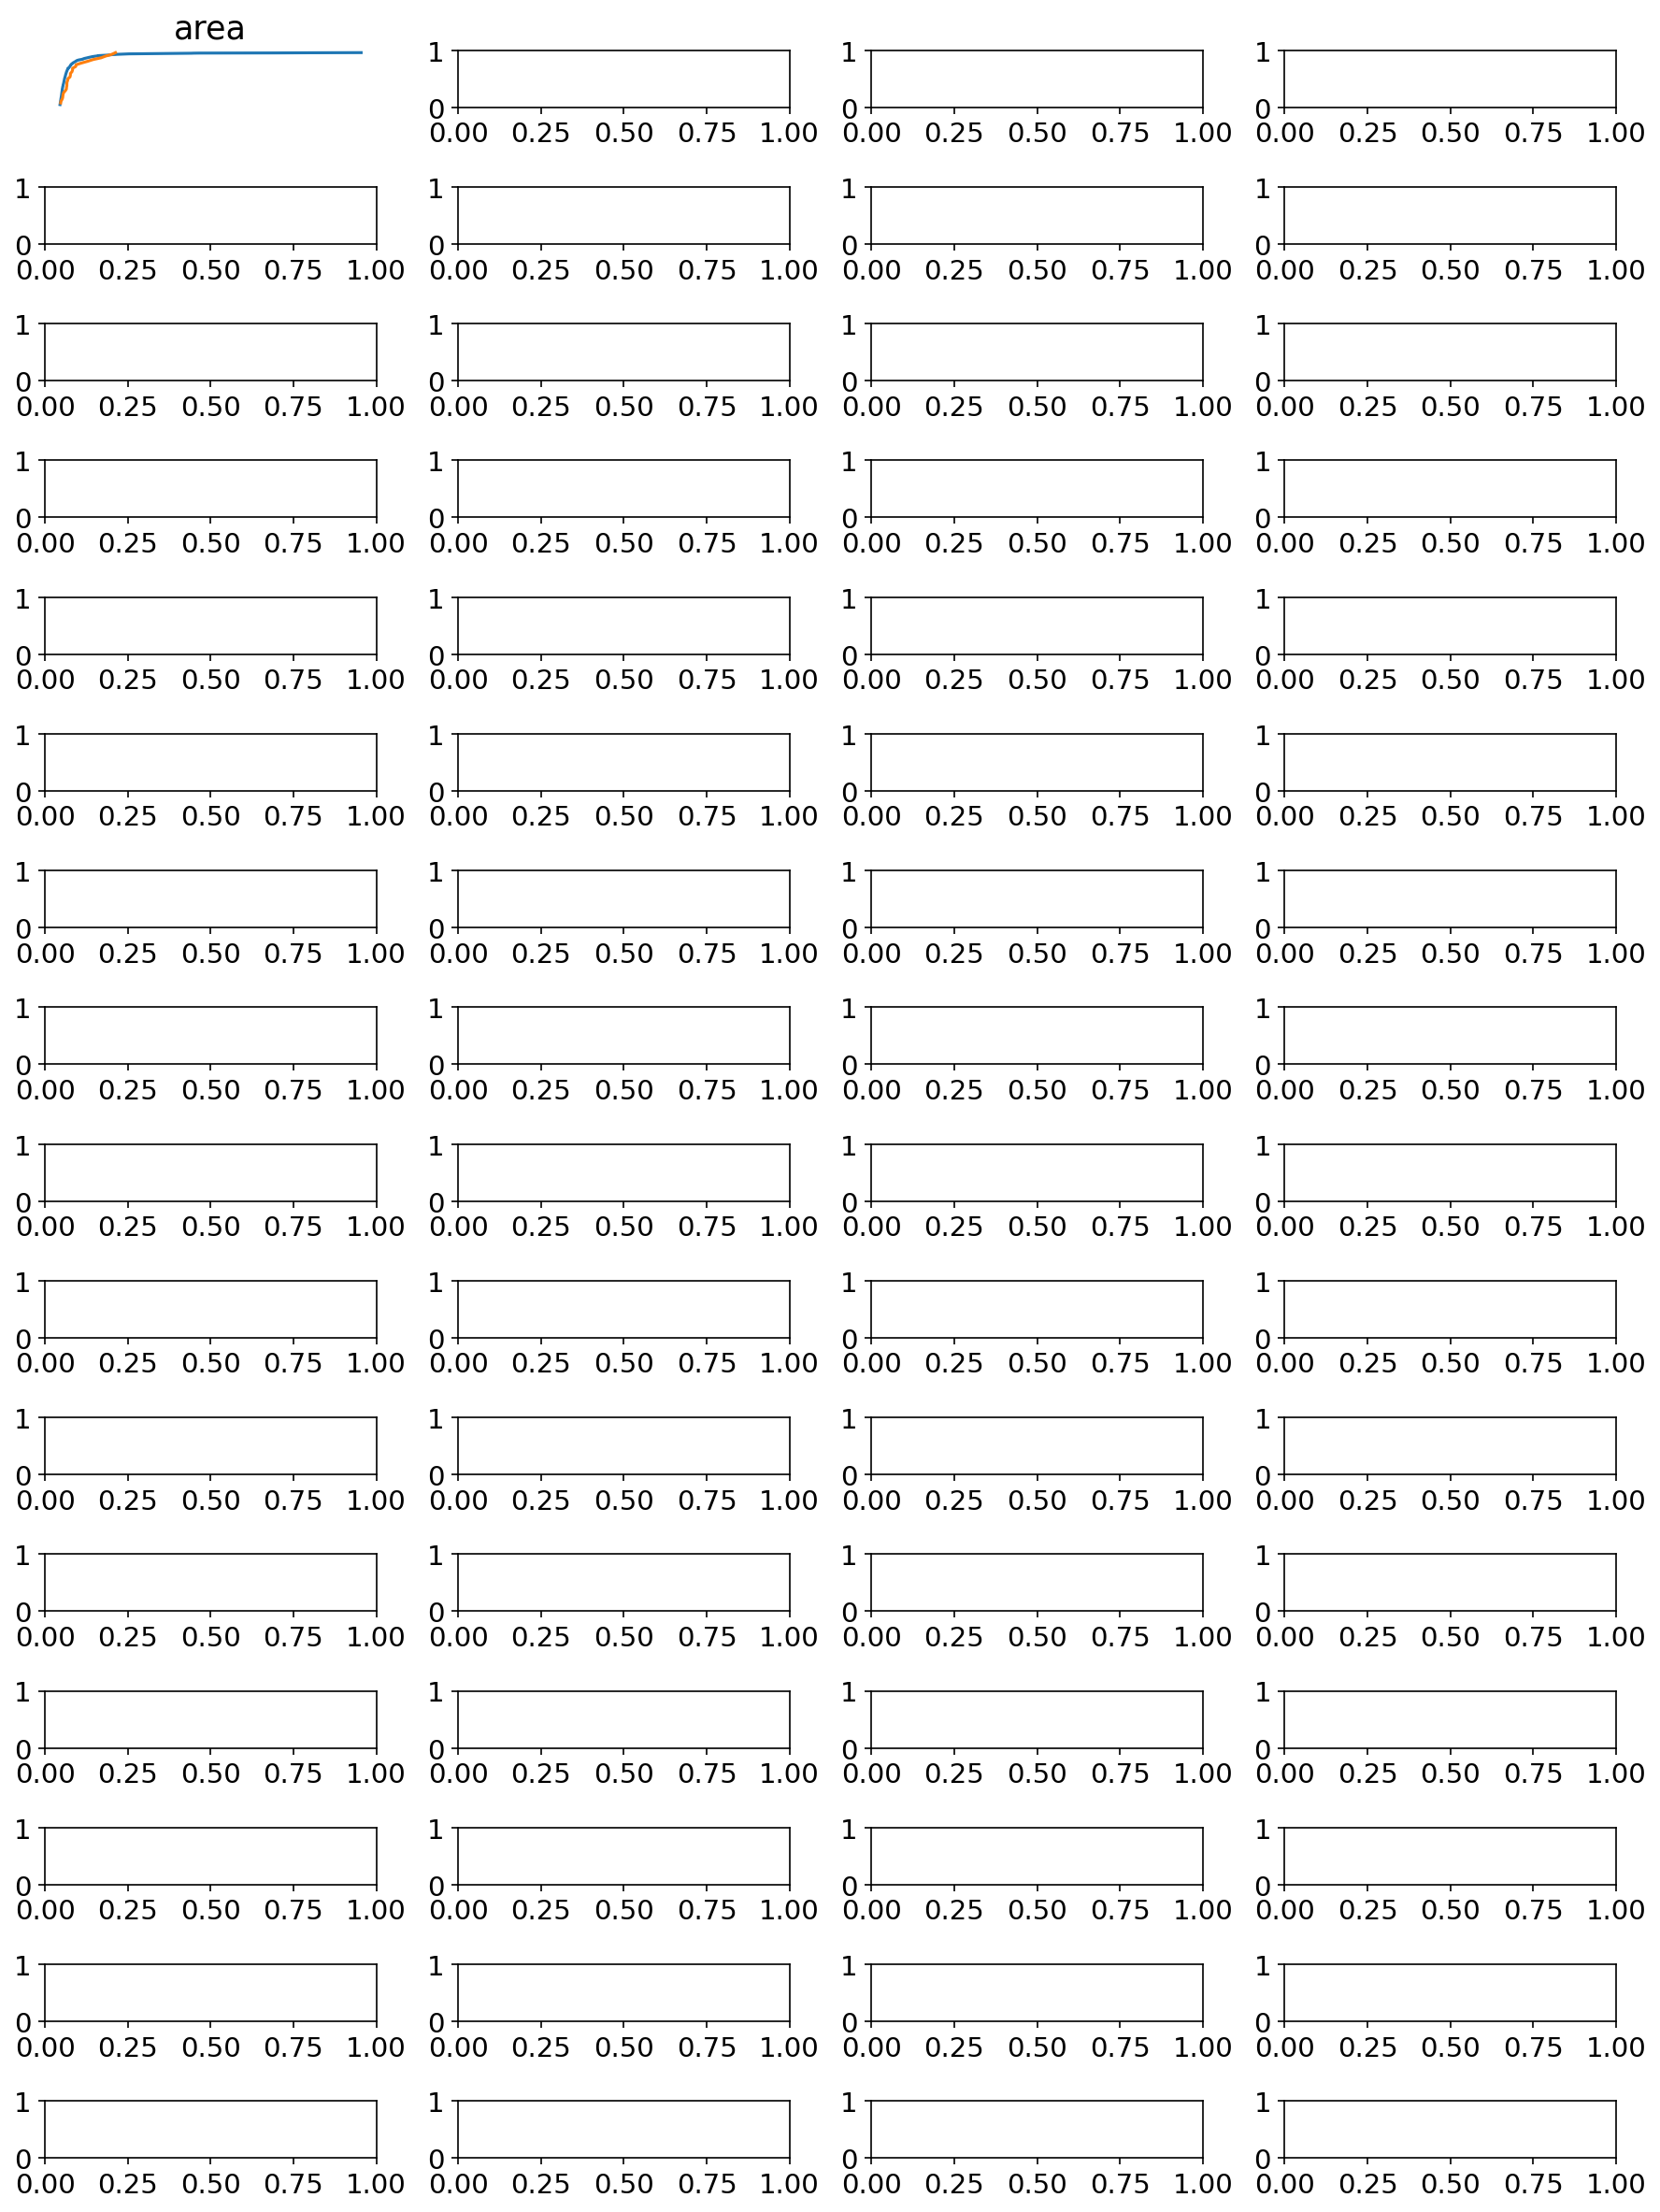

In [458]:
f, axs = plt.subplots(16, 4, figsize=(3*4, 1*16))

static_feature = "frac_high_perc"

for ix, static_feature in enumerate(static_for_better.columns):
    ax = axs[np.unravel_index(ix, (16, 4))]
    # sns.kdeplot(static_for_better.loc[:, static_feature].dropna(), ax=ax, label="Better", shade=False, cumulative=True, legend=False if ix != 0 else True)
    # sns.kdeplot(static_for_worse.loc[:, static_feature].dropna(), ax=ax, label="Worse", shade=False, cumulative=True, legend=False if ix != 0 else True)
    ax.plot(*ecdf(static_for_better.loc[:, static_feature].dropna()), label="Better")
    ax.plot(*ecdf(static_for_worse.loc[:, static_feature].dropna()), label="Worse")

    ax.set_title(static_feature)
    ax.axis("off")
    
plt.tight_layout()


# Central Belt of Scotland

In [462]:
# # import folium
# g = make_point_static_gdf("baseflow_index")
# gjson = g.to_json()

In [460]:
def plot_stations(stations):
    f, ax = plt.subplots() 
    isin_stations = delta_gdf.loc[np.isin(delta_gdf.index, stations)].index
    
    delta_gdf.loc[~np.isin(delta_gdf.index, stations)].plot(f"{model}_bool", ax=ax, color="grey", markersize=10)
    delta_gdf.loc[np.isin(delta_gdf.index, stations)].plot(f"{model}_bool", ax=ax, color="blue", markersize=None)
    ax.axis('off')
    return isin_stations

27


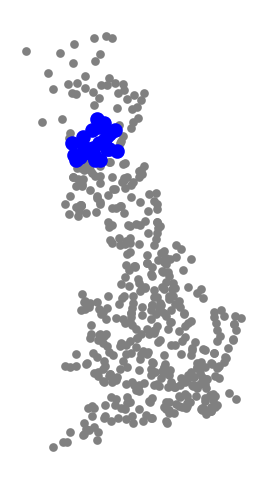

In [461]:
stations = np.append(np.arange(84000, 84100), np.arange(83000, 83100))
# stations = 
stations = np.append(np.arange(15000, 18100), np.arange(85000, 85100))
# stations = np.arange(15000, 15100)
# plot_stations(stations=stations)

c_scotland_stations = plot_stations(stations=stations)
print(len(c_scotland_stations))

In [ ]:
KDEPLOT = True
metric = "nse"

f, ax = plt.subplots()
if KDEPLOT:
    sns.kdeplot(metric_df[metric], ax=ax, clip=(0, 1), cumulative=True, label="All of GB")
    sns.kdeplot((metric_df.set_index("station_id").loc[c_scotland_stations, metric]), ax=ax, clip=(0, 1), cumulative=True, label="Scotland")
else:
    sns.distplot(metric_df[metric], ax=ax, label="All of GB")
    sns.distplot((metric_df.set_index("station_id").loc[c_scotland_stations, metric]), ax=ax, label="Scotland")

ax.set_xlim(0, 1)
sns.despine()
ax.set_xlabel(metric)
ax.legend()

In [ ]:
stations = np.concatenate([np.arange(40000, 41100), np.arange(39010, 39020)])
# stations = np.arange(38000, 41100)
# stations = np.arange(41000, 41100)
# stations = np.arange(39010, 39020)
if True:
    se_stations = plot_stations(stations=stations)
    print(len(se_stations))
#     se_stations

In [ ]:
# metric_df
# lstm_error_df
# lstm_metric_df

In [ ]:
(lstm_metric_df.loc[se_stations, "nse"]).median()

In [ ]:
KDEPLOT = False
metric = "bias"

f, ax = plt.subplots()
if KDEPLOT:
    sns.kdeplot(lstm_metric_df[metric], ax=ax, clip=(0, 1) if metric in ["nse", "kge"] else None, cumulative=True, label="All of GB")
    sns.kdeplot((lstm_metric_df.loc[se_stations, metric]), ax=ax, clip=(0, 1) if metric in ["nse", "kge"] else None, cumulative=True, label="SE England")
else:
    sns.distplot(lstm_metric_df[metric], ax=ax, label="All of GB")
    sns.distplot((lstm_metric_df.loc[se_stations, metric]), ax=ax, label="SE England")

if metric in ["nse", "kge"]:
    ax.set_xlim(0, 1)
elif metric == "bias":
    ax.axvline(0, ls="--", alpha=0.5, color="grey")
sns.despine()
ax.set_xlabel(metric)
ax.legend()

In [ ]:
lstm_delta["nse"]

KDEPLOT = True
metric = "nse"
model = "TOPMODEL"
f, ax = plt.subplots()


if KDEPLOT:
    sns.kdeplot(lstm_delta[metric][model], ax=ax, clip=(0, 1) if metric in ["nse", "kge"] else None, cumulative=True, label="All of GB")
    sns.kdeplot((lstm_delta[metric].loc[se_stations, model]), ax=ax, clip=(0, 1) if metric in ["nse", "kge"] else None, cumulative=True, label="SE England")
else:
    sns.distplot(lstm_delta[metric][model], ax=ax, label="All of GB", bins=20, norm_hist=True)
    sns.distplot(lstm_delta[metric].loc[se_stations, model], ax=ax, label="SE England", bins=20, norm_hist=True)

if metric in ["nse", "kge"]:
    if KDEPLOT:
        ax.set_xlim(0, 1)
    else:
        ax.set_xlim(-1, 1)
elif metric == "bias":
    ax.axvline(0, ls="--", alpha=0.5, color="grey")
sns.despine()
ax.set_xlabel("∆" + metric)
ax.legend()

In [ ]:
?sns.distplot

In [ ]:
all_metric_se = []
all_metric = 
metric = "nse"
for model in models:
    all_metric_se.append(lstm_delta[metric].loc[se_stations, model])
    all_metric.append(lstm_delta[metric][model])
    print(f"SE Stations Median {model} ∆{metric}: {lstm_delta[metric].loc[se_stations, model].median():.2f}")
    print(f"ALL Stations Median {model}  ∆{metric}: {lstm_delta[metric][model].median():.2f}")

In [ ]:
print(f"SE Median ∆: {(pd.concat(all_metric_se)).median():.2f}")
print(f"SE Median ∆: {(pd.concat(all_metric)).median():.2f}")

# Bayesian Analysis supersedes the T Test (BEST)
- [BEST Python tool](https://best.readthedocs.io/en/latest/)
- [BEST in PyMC3](https://docs.pymc.io/notebooks/BEST.html)
- [Using R and Stan w/BRMS](https://vuorre.netlify.app/post/2017/01/02/how-to-compare-two-groups-with-robust-bayesian-estimation-using-r-stan-and-brms/)
- [Original Paper](https://jkkweb.sitehost.iu.edu/BEST/BEST.pdf)

# What characteristics where we do better / worse

In [ ]:
# Worse?
worse_cments_top = static_df[(lstm_delta_nse < 0)["TOPMODEL"]]
worse_cments_sac = static_df[(lstm_delta_nse < 0)["Sacramento"]]
worse_cments_vic = static_df[(lstm_delta_nse < 0)["VIC"]]
worse_cments_prms = static_df[(lstm_delta_nse < 0)["PRMS"]]

In [ ]:
# sns.distplot(worse_cments_top["aridity"], label="TOPMODEL")
# sns.distplot(worse_cments_sac["aridity"], label="Sacramento")
# sns.distplot(worse_cments_vic["aridity"], label="VIC")
# sns.distplot(worse_cments_prms["aridity"], label="PRMS")
# plt.legend()
# sns.despine()

### Is delta NSE predictable?
Random forests tuning ([DataScienceMedium](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74))
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

[Sklearn Docs - RF Parameters](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters): 
- main parameters to adjust when using these methods is `n_estimators` and `max_features`

In [ ]:
from rfpimp import (
    importances, 
    plot_importances, 
    plot_corr_heatmap, 
    feature_corr_matrix, 
    feature_dependence_matrix,
    plot_dependence_heatmap
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

"""
    rf = RandomForestRegressor(
        random_state = 42,
        n_estimators=200, # 200 100
        max_features=50,  # 50  10
        max_depth=100,    # 100  5 
        min_samples_split=2, # 2
        min_samples_leaf=1,  # 1
        oob_score=False,   # True
    )
    
    rf = RandomForestRegressor(
        random_state=42, 
        n_estimators=200,
        max_features=100//3,
    )
""";

In [ ]:
targets = lstm_delta["nse"]  # ealstm_delta["nse"]

static_df = static.to_dataframe()
names = static_df["gauge_name"]
# get floats with <25% nan
static_df = static_df.loc[:, (static_df.dtypes == "float64") & (static_df.isna().mean(axis=0) < 0.25)]
static_df = names.to_frame().join(static_df)

In [ ]:
model = "TOPMODEL"
models = ['TOPMODEL', 'SACRAMENTO', 'ARNOVIC', 'PRMS']

# training pairs
stations = targets.dropna().index
X = static_df.drop("gauge_name", axis=1).loc[stations]
Y = targets.loc[stations, model]
# display(X.head())
# display(Y.head())


# Fix the basins used for Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
train_index = X_train.index
test_index = X_test.index

for model in tqdm(models):
    Y = targets[model].dropna()
    X = static_df.drop("gauge_name", axis=1).loc[Y.index]

    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], Y.loc[train_index], Y.loc[test_index]
    rf = RandomForestRegressor(
        random_state=42, 
        n_estimators=200,
        max_features=100//3,
    )
    rf.fit(X_train, y_train)
    
    print(model)
    print(f"Train R2 Score: {rf.score(X_train, y_train):.02f}")
    print(f"Test R2 Score: {rf.score(X_test, y_test):.02f}")

# Train RandomForests on the model performances // Delta NSE
- [sklearn implementation](https://github.com/scikit-learn/scikit-learn/pull/13146)
- [post here](https://explained.ai/rf-importance/)
- [rfpimp package](https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py#L263)

### How this works
- $y$ = delta_NSE
- $X$ = static features

In [ ]:
from rfpimp import (
    importances, 
    plot_importances, 
    plot_corr_heatmap, 
    feature_corr_matrix, 
    feature_dependence_matrix,
    plot_dependence_heatmap
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
grouped_features = [
    #  HydroGeology
    ["inter_high_perc", "inter_mod_perc", "inter_low_perc",],
    ["frac_high_perc", "frac_mod_perc", "frac_low_perc",],
    ["low_nsig_perc", "nsig_low_perc",],
    "no_gw_perc",
    # Topography
    ["gauge_lat", "gauge_lon",],
    [
        "gauge_elev",
        "elev_mean",
        "elev_min",
        "elev_10",
        "elev_50",
        "elev_90",
        "elev_max",
    ],
    "dpsbar",
    #  Soil Properties
    ["sand_perc", "silt_perc", "clay_perc", "organic_perc",],
    ["bulkdens", "bulkdens_5", "bulkdens_50", "bulkdens_95",],
    [
        "tawc", "tawc_5", "tawc_50", "tawc_95"
    ],
    [
        "porosity_cosby",
        "porosity_cosby_5",
        "porosity_cosby_50",
        "porosity_cosby_95",
        "porosity_hypres",
        "porosity_hypres_5",
        "porosity_hypres_50",
        "porosity_hypres_95",
    ],
    [
        "conductivity_cosby",
        "conductivity_cosby_5",
        "conductivity_cosby_50",
        "conductivity_cosby_95",
        "conductivity_hypres",
        "conductivity_hypres_5",
        "conductivity_hypres_50",
        "conductivity_hypres_95",
    ],
    ["root_depth", "root_depth_5", "root_depth_50", "root_depth_95",],
    [
        "soil_depth_pelletier",
        "soil_depth_pelletier_5",
        "soil_depth_pelletier_50",
        "soil_depth_pelletier_95",
    ],
    #  Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    ["baseflow_index", "baseflow_index_ceh",],
    "hfd_mean",
    "Q5",
    "Q95",
    ["high_q_freq", "low_q_freq", "zero_q_freq",],
    ["high_q_dur", "low_q_dur",],
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "p_seasonality",
    "frac_snow",
    "high_prec_freq",
    "high_prec_dur",
    "low_prec_freq",
    "low_prec_dur",
    #  landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
    "inwater_perc",
    "bares_perc",
    # human influence
    "surfacewater_abs",
    "groundwater_abs",
    "discharges",
]

In [ ]:
from typing import Union

def flatten(list_of_lists: List[Union[str, List]]):
    flattened = []
    for item in list_of_lists:
        if type(item) == list:
            flattened.extend([i for i in item])
        else:
            flattened.append(item)
        
    return flattened

cont_features = flatten(groups_of_colinear_features)

In [ ]:
categorical_features = [
    "dom_land_cover",
    "high_prec_timing",
    "low_prec_timing",
]
numerical_features = [
    "reservoir_cap"
]
numerical_features.extend(cont_features)

important_features = [
    # topography
    "gauge_lat", 
    "gauge_lon",
    "gauge_elev",
    "dpsbar",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]

In [ ]:
# get train pairs
Ys = delta_nse.dropna()

X = static_df.loc[:, numerical_features + categorical_features]
X = X.loc[Ys.index, important_features]

assert len(X) == len(Ys)
display(Ys.head())

In [ ]:
# Processing and fitting pipeline
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('normalizer', ),
#     ('dimensional_reduction', PCA(n_components=4))
])

preprocessing = ColumnTransformer(
    [
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numerical_features)
    ]
)

preprocessing = ColumnTransformer(
    [
        ("num", numerical_pipe, important_features)
    ]
)

rf = Pipeline([
    ('preprocess', preprocessing),
    ('Regressor', RandomForestRegressor(random_state=1, max_features=0.1, oob_score=True))
])

In [ ]:
# categorical_pipe.fit_transform(X[categorical_features])

In [ ]:
rf.fit(X, Ys);

In [ ]:
importances(rf, X, Ys)

In [ ]:
print("RF train accuracy: %0.3f" % rf.score(X, Ys))

In [ ]:
result = permutation_importance(rf, X, Ys, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [ ]:
def scatter_plot_feature(feature: str):
    f, ax = plt.subplots()
    d = delta_nse.join(static_df[feature])

    ax.scatter(d[feature], d["TOPMODEL"], marker="x", label="TOPMODEL", alpha=0.5, color=sns.color_palette()[0])
    ax.scatter(d[feature], d["Sacramento"], marker="x", label="Sacramento", alpha=0.5, color=sns.color_palette()[1])
    ax.scatter(d[feature], d["VIC"], marker="x", label="VIC", alpha=0.5, color=sns.color_palette()[2])
    ax.scatter(d[feature], d["PRMS"], marker="x", label="PRMS", alpha=0.5, color=sns.color_palette()[3])
    
    # plot linear regressions
    # m, b = np.polyfit(d[feature], d["TOPMODEL"], 1)

    ax.set_ylim(-1, 1)
    ax.set_ylabel("$\Delta$NSE")
    ax.set_xlabel(feature)
    plt.legend()
    sns.despine()
    

scatter_plot_feature("crop_perc")